In [65]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [118]:
L = 5 #system size
M = 0.1 #fermion mass
N=4 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [119]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
       0.         |2 2 2 2 2>           242  
       1.         |2 2 2 2 1>           241  
       2.         |2 2 2 2 0>           240  
       3.         |2 2 2 1 2>           239  
       4.         |2 2 2 1 1>           238  
       5.         |2 2 2 1 0>           237  
       6.         |2 2 2 0 2>           236  
       7.         |2 2 2 0 1>           235  
       8.         |2 2 2 0 0>           234  
       9.         |2 2 1 2 2>           233  
      10.         |2 2 1 2 1>           232  
      11.         |2 2 1 2 0>           231  
      12.         |2 2 1 1 2>           230  
      13.         |2 2 1 1 1>           229  
      14.         |2 2 1 1 0>           228  
      15.         |2 2 1 0 2>           227  
      16.         |2 2 1 0 1>           226  
      17.         |2 2 1 0 0>           225  
      18.         |2 2 0 2 2>           224  
      19.         |2 2 0 2 1>           223  
      20.  

In [120]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [121]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [122]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [123]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [124]:
interaction_p = []
interaction_m = []

const_term = [[[1j/(2*np.sqrt(l*(l+1))),i]] for i in range(L)]
const_term_m = [[[-1j/(2*np.sqrt(l*(l+1))),i]] for i in range(L)]

for i in range(L):
    interaction_p.append([
        ["+", const_term[i]],
    ])

    interaction_m.append([
        ["-", const_term_m[i]],
    ])


kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

G=0
for i in range(L+1):
    G += 0.12*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term
#print(full_ham_matrix)

In [125]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])
print(eigenvec[:,0])

[-1.0416023  -0.34551385 -0.34551385]
[-1.46006754e-03+3.84807889e-03j -2.34507118e-19+5.74556203e-18j
 -3.60695782e-18+1.19569610e-18j -1.43979808e-02-5.46299206e-03j
  1.02122840e-02-2.69149703e-02j -1.26923948e-17+1.52035659e-17j
 -4.56079274e-18+6.39381918e-19j -1.40554967e-17+2.21262426e-17j
 -6.47838956e-19+5.15654626e-18j -1.04692193e-17+1.43678847e-17j
 -1.45287481e-17+8.87394773e-18j -4.15468264e-18-8.65906952e-18j
 -1.02816866e-18-1.51871308e-18j  1.15734606e-17+1.78334979e-18j
  1.16990300e-17-5.63959204e-18j -8.15843073e-19-2.02369433e-18j
 -1.00993441e-17-8.75890264e-18j -1.59927082e-17+2.37317200e-18j
 -3.41385211e-18-2.32772924e-18j -2.20522659e-17-7.38389887e-19j
 -1.28619790e-17-1.78509754e-17j -5.81007350e-18-5.37591459e-18j
  1.91045352e-17-7.99365986e-18j  6.69540776e-18-8.91002200e-19j
  8.15524673e-19-2.38845722e-18j  9.87689999e-18-2.99444433e-18j
 -1.26205180e-18-2.73354909e-18j -1.43979808e-02-5.46299206e-03j
 -6.62307576e-18+1.37164388e-18j  7.28624748e-18-7.5

In [126]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian with the local contstaints
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [127]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-2:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-1.0416023  -0.0142565   0.15174042]
(-0.007095970880320624+0.01366723568557999j)|2 2 2 1 2>
(-0.025548946554752913-0.013264904838560349j)|2 2 2 1 1>
(-0.007095970880320616+0.013667235685579995j)|2 1 2 2 2>
(-0.06487265692170202-0.033681608705344666j)|2 1 2 1 2>
(0.06563821644015824-0.12642286576410233j)|2 1 2 1 1>
(0.0661600643432378-0.12742797393093422j)|2 1 1 1 2>
(0.27869210621093843+0.14469576114316704j)|2 1 1 1 1>
(-0.054558745501911345+0.10508318679155895j)|2 1 1 0 1>
(-0.025548946554752944-0.013264904838560318j)|1 1 2 2 2>
(0.06563821644015816-0.12642286576410258j)|1 1 2 1 2>
(0.24823501082550925+0.12888256622020336j)|1 1 2 1 1>
(0.27869210621093865+0.1446957611431667j)|1 1 1 1 2>
(-0.31764791552305377+0.6118076017654979j)|1 1 1 1 1>
(-0.23445059563412618-0.12172575623678437j)|1 1 1 0 1>
(-0.05455874550191131+0.1050831867915592j)|1 0 1 1 2>
(-0.23445059563412635-0.12172575623678454j)|1 0 1 1 1>
(0.051789053873670804-0.09974860623902002j)|1 0 1 0 1>
(0.018191662246937326+0.0094

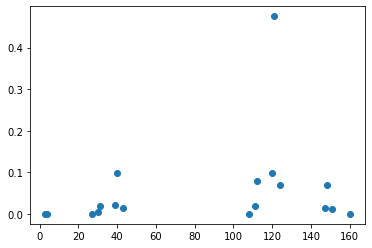

In [128]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvectors[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")

In [129]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [130]:
#cost function of the initial state
expt_value = 0
matvec_h = full_ham_matrix@psi_0
matvec_c = constraint_full_matrix@psi_0
for i in range(basis.Ns):
    expt_value += np.conj(psi_0[i])*(matvec_h[i]+matvec_c[i])
print(np.real(expt_value))

0.0


In [131]:
expt_value = 0
matvec = full_ham_matrix@psi_0
for i in range(basis.Ns):
    expt_value += np.conj(psi_0[i])*matvec[i]
print(expt_value)

0j


In [132]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma/2)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_ms(k,i,j,phi,theta):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    power_matrix = scipy.sparse.kron(sigma,sparse.identity(2*l+1))+scipy.sparse.kron(sparse.identity(2*l+1),sigma)
    rot_matrix = scipy.sparse.linalg.expm(-1j*power_matrix@power_matrix*theta/4)
    if k == 0:
        tensprod = rot_matrix
        for i in range(L-2):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+2,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_ms_e(i,j,phi,theta):
    ms_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        ms_e = rot_ms(2*k,i,j,phi,theta)@ms_e
    return(ms_e)

def rot_ms_o(i,j,phi,theta):
    ms_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)-1):
        ms_o = rot_ms(2*k+1,i,j,phi,theta)@ms_o
    return(ms_o)

def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_all(i,j,phi,theta):
    sigma_all = sparse.identity(basis.Ns,dtype = complex)
    for k in range(L):
        sigma_all = rot_sigma(k,i,j,phi,theta)@sigma_all
    return(sigma_all)

In [133]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta/4)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    

In [134]:
import datetime
print(datetime.datetime.now())
a = ms_gate_global(np.pi)
print(datetime.datetime.now())
b = rot_sigma_e(0,1,0,np.pi)
print(datetime.datetime.now())
a@b
print(datetime.datetime.now())

2022-04-11 14:36:26.288893
2022-04-11 14:36:26.296657
2022-04-11 14:36:26.312209
2022-04-11 14:36:26.313799


In [135]:

def sigma_sigma(m,n,theta):
    sigma_sigma = sparse.lil_matrix((basis.Ns,basis.Ns),dtype = complex)
    temp1 = np.cos(theta/2)
    temp2 = -1j*np.sin(theta/2)
    for i in range(basis.Ns):
        sigma_sigma[i,i] = 1.
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "1")):
            
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "2","2"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2

        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "2")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "2","1"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2


        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "1")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "1","2"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2


        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "2")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "1","1"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2

            
    return sigma_sigma

def id_id(m,theta):
    id_id = sparse.lil_matrix((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        id_id[i,i] = 1.
        
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1"):
            id_id[i,i] = (np.cos(theta/4)-1j*np.sin(theta/4))
            
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2"):
            id_id[i,i] = (np.cos(theta/4)-1j*np.sin(theta/4)) 
            
    return id_id


def ms_global_sparse(theta):
    ms_global = sparse.identity(basis.Ns)
    for m in range(L):
        ms_global = id_id(m,theta)@ms_global
        for n in range(m+1,L):
            ms_global = sigma_sigma(m,n,theta)@ms_global
    return ms_global

#print(np.allclose(ms_global_sparse(np.pi/4).toarray(),ms_gate_global(np.pi/4), atol= 1e-3,rtol=1e-3))
#print(np.allclose(ms_global_sparse(np.pi/3).toarray().conj().T@ms_global_sparse(np.pi/3).toarray(),np.identity(basis.Ns), atol= 1e-8,rtol=1e-8))

%time sigma_sigma(0,1,np.pi/3)

CPU times: user 28.3 ms, sys: 2 µs, total: 28.3 ms
Wall time: 26.8 ms


<243x243 sparse matrix of type '<class 'numpy.complex128'>'
	with 351 stored elements in List of Lists format>

In [136]:
#import timeit
#print(timeit.timeit('[ms_gate_global(0,2,np.pi)]', globals=globals()))
import datetime
print(datetime.datetime.now())
a = ms_gate_global(np.pi)
print(datetime.datetime.now())
print(np.size(a))


2022-04-11 14:36:26.861670
2022-04-11 14:36:26.870369
59049


In [137]:
def cost_function_sigma(theta):
    psi_var = psi_0
    for i in range(N):
        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(1,2,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var

    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

import datetime

print(datetime.datetime.now())
a = cost_function_sigma(np.pi*np.ones(5*N))
print(datetime.datetime.now())

2022-04-11 14:36:27.167906
2022-04-11 14:36:27.366982


In [138]:
opt_params = []
function_values = []
def callback_function(x,fun,context):
    opt_params.append(x)
    function_values.append(fun)


In [139]:
full_ham_matrix = sparse.csc_matrix(full_ham_matrix)

In [140]:
Energy = np.zeros(5)
Fidelity = np.zeros(5)

In [ ]:
import optuna
#for N in range(1,6):
theta = np.zeros(5*N)
#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        theta[5*i+0] = trial.suggest_float("5*"+str(i)+"+0", -3*np.pi, 3*np.pi)
        theta[5*i+1] = trial.suggest_float("5*"+str(i)+"+1", -3*np.pi, 3*np.pi)
        theta[5*i+2] = trial.suggest_float("5*"+str(i)+"+2", -3*np.pi, 3*np.pi)
        theta[5*i+3] = trial.suggest_float("5*"+str(i)+"+3", -3*np.pi, 3*np.pi)
        theta[5*i+4] = trial.suggest_float("5*"+str(i)+"+4", -3*np.pi, 3*np.pi)


        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(1,2,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var

    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

if __name__ == "__main__":
    sampler = optuna.samplers.CmaEsSampler()
    study = optuna.create_study(sampler=sampler)
    study.optimize(cost_function_sigma, n_trials=8000)
    

"""""""""""""""""""""
k=0
for value in study.best_trial.params.items():
    theta[k] = value[1]
    k+=1

psi_var = psi_0
for i in range(N):
    psi_var = ms_gate_global(theta[5*i+0])@psi_var
    psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(0,1,0,theta[5*i+3])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var

    #Energy[N-1] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var)
    #Fidelity[N-1] = np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2
"""""""""""""""""""""

[I 2022-04-11 15:12:21,462] A new study created in memory with name: no-name-232aa777-c7a7-4a03-ab66-8a5161379f59
[I 2022-04-11 15:12:21,646] Trial 0 finished with value: 3.5500900863034843 and parameters: {'5*0+0': 6.960748576993534, '5*0+1': 4.061508686551711, '5*0+2': 4.811612678809421, '5*0+3': 6.555313933311558, '5*0+4': -3.426929890240163, '5*1+0': -1.6359740928784579, '5*1+1': 7.315349235494558, '5*1+2': -0.9145065276706834, '5*1+3': 5.408845824872364, '5*1+4': 8.348550260735443, '5*2+0': 4.211150777884521, '5*2+1': 4.500075622840702, '5*2+2': 8.627173455094443, '5*2+3': 6.480406647550279, '5*2+4': 8.19823585623979, '5*3+0': -0.7793297988687478, '5*3+1': 7.44364583351415, '5*3+2': 4.063937562278596, '5*3+3': -2.3124321477652714, '5*3+4': -7.755312471592536}. Best is trial 0 with value: 3.5500900863034843.
[I 2022-04-11 15:12:21,794] Trial 1 finished with value: 3.8722659574208835 and parameters: {'5*0+0': -5.420625661987559, '5*0+1': 3.569853203699499, '5*0+2': 2.410845559161571

[I 2022-04-11 15:12:23,333] Trial 11 finished with value: 4.1345350337639815 and parameters: {'5*0+0': 4.067374618780158, '5*0+1': 0.25046152324592785, '5*0+2': 4.1405260263152375, '5*0+3': 0.7557219034350084, '5*0+4': -1.6347802621202334, '5*1+0': 0.07040490116491749, '5*1+1': -4.729990532289912, '5*1+2': -3.174943892851788, '5*1+3': -0.6858665324067469, '5*1+4': -1.693225211584117, '5*2+0': 1.8936739545199037, '5*2+1': -3.1720627834334167, '5*2+2': 1.7975586842690536, '5*2+3': -4.712396184212767, '5*2+4': -3.568247803839081, '5*3+0': -6.279492847608665, '5*3+1': -0.039128943880460565, '5*3+2': 3.286938853986361, '5*3+3': 2.5838248671662445, '5*3+4': -2.2585411083677736}. Best is trial 4 with value: 1.335938920280772.
[I 2022-04-11 15:12:23,495] Trial 12 finished with value: 3.670188951833109 and parameters: {'5*0+0': 2.1689544610159572, '5*0+1': 0.8541093706368742, '5*0+2': 2.2995328876127625, '5*0+3': 5.909536712253725, '5*0+4': 0.015121928619719697, '5*1+0': 2.2722855882160604, '5*

[I 2022-04-11 15:12:25,255] Trial 23 finished with value: 2.776133784706345 and parameters: {'5*0+0': -1.3964185430970688, '5*0+1': -3.469508320941178, '5*0+2': 3.611328671529011, '5*0+3': 0.28541542422767496, '5*0+4': -1.7070701050084043, '5*1+0': 1.1941078004538432, '5*1+1': -3.4084967077056785, '5*1+2': -3.0972999573428517, '5*1+3': 4.364144874094279, '5*1+4': -0.7258709649731352, '5*2+0': 0.07764308196427283, '5*2+1': -3.2511979382131795, '5*2+2': 2.624179859931789, '5*2+3': 3.0035287362872136, '5*2+4': 3.0060983844187676, '5*3+0': 2.6562347903674293, '5*3+1': 0.06566177879012747, '5*3+2': 4.555017421313714, '5*3+3': 4.305315181036782, '5*3+4': -6.266589007457634}. Best is trial 4 with value: 1.335938920280772.
[I 2022-04-11 15:12:25,403] Trial 24 finished with value: 11.7970494381742 and parameters: {'5*0+0': 0.2837388228725308, '5*0+1': 2.3217858201521238, '5*0+2': 5.709409872658148, '5*0+3': -2.8359226528467523, '5*0+4': 2.713320605982843, '5*1+0': 2.4853394468430854, '5*1+1': 3

[I 2022-04-11 15:12:27,097] Trial 35 finished with value: 3.85480138621609 and parameters: {'5*0+0': 0.317285786394091, '5*0+1': -0.5429771616838948, '5*0+2': 0.6555260508758485, '5*0+3': 0.033064524011200636, '5*0+4': -2.762711702551446, '5*1+0': -1.1867489900228632, '5*1+1': -0.4216525297555549, '5*1+2': -0.3991351593760779, '5*1+3': 0.5648691185619876, '5*1+4': -2.2245676061286614, '5*2+0': 0.13627314237997246, '5*2+1': -5.049807535855583, '5*2+2': 0.5442242898926825, '5*2+3': -0.0376448665057072, '5*2+4': 7.825300788876641, '5*3+0': 1.7177233920556065, '5*3+1': -1.5245848043719765, '5*3+2': 7.054765829834787, '5*3+3': 4.087847902943761, '5*3+4': 0.9105407541025494}. Best is trial 4 with value: 1.335938920280772.
[I 2022-04-11 15:12:27,244] Trial 36 finished with value: 5.9534734623044985 and parameters: {'5*0+0': 1.4500306858032506, '5*0+1': -1.0188206084380003, '5*0+2': 4.585540696505495, '5*0+3': 0.4088265562585157, '5*0+4': -3.237955336906592, '5*1+0': 3.7774767517484253, '5*1+1

[I 2022-04-11 15:12:29,061] Trial 47 finished with value: 6.390687684743938 and parameters: {'5*0+0': 1.901677095096309, '5*0+1': -5.346637173449726, '5*0+2': 0.01288704790820816, '5*0+3': 3.5613468168338227, '5*0+4': -0.9838777468470965, '5*1+0': 3.3335193143432704, '5*1+1': -0.4666429774297969, '5*1+2': 2.0096976985216166, '5*1+3': -0.9658066243362753, '5*1+4': 1.8687142851163292, '5*2+0': -5.373672653034095, '5*2+1': -0.42076287631075493, '5*2+2': 4.242218060479882, '5*2+3': 0.0015726259936574838, '5*2+4': -0.628796455885944, '5*3+0': -2.0981547797554185, '5*3+1': -0.10087084001061086, '5*3+2': 7.342414201111856, '5*3+3': 6.032773395999032, '5*3+4': -2.191840180625429}. Best is trial 4 with value: 1.335938920280772.
[I 2022-04-11 15:12:29,208] Trial 48 finished with value: 3.9205302873618035 and parameters: {'5*0+0': 3.046071280801038, '5*0+1': -4.401173431962461, '5*0+2': 2.4328957326328737, '5*0+3': 1.3593542156132816, '5*0+4': -4.49939786932429, '5*1+0': 1.1582575494477731, '5*1+

[I 2022-04-11 15:12:30,826] Trial 59 finished with value: 4.347945074026496 and parameters: {'5*0+0': -3.3296994225754366, '5*0+1': -4.896026888590007, '5*0+2': 2.6298449987094834, '5*0+3': -1.3796213058400757, '5*0+4': -4.656127858614271, '5*1+0': 3.5136838007582014, '5*1+1': -7.723007452535706, '5*1+2': -0.3879328653545451, '5*1+3': 0.3934051427622457, '5*1+4': 0.009325037190820118, '5*2+0': 1.135660048004241, '5*2+1': -4.221008298874214, '5*2+2': 5.107867715135021, '5*2+3': 3.1742101023881317, '5*2+4': 2.0684057594504743, '5*3+0': 4.12859008068452, '5*3+1': -2.1502741915852575, '5*3+2': 4.165684570034712, '5*3+3': 0.5648662303230743, '5*3+4': 0.795872610986502}. Best is trial 4 with value: 1.335938920280772.
[I 2022-04-11 15:12:30,973] Trial 60 finished with value: 4.707061297835003 and parameters: {'5*0+0': 1.7819896681938672, '5*0+1': -3.2666862508962167, '5*0+2': -0.13675968619761925, '5*0+3': -6.343346563295372, '5*0+4': -1.2843980161360975, '5*1+0': 2.428823208379135, '5*1+1': 

[I 2022-04-11 15:12:32,614] Trial 71 finished with value: 3.982955181186037 and parameters: {'5*0+0': 3.5776564361302094, '5*0+1': -1.5198834410194855, '5*0+2': 3.178233692548046, '5*0+3': 0.3822485178802948, '5*0+4': -4.146078657471478, '5*1+0': 2.097354031865395, '5*1+1': -4.588270900576358, '5*1+2': -1.950063021728584, '5*1+3': 2.9059068496437592, '5*1+4': 2.417370854581827, '5*2+0': 2.158005696103485, '5*2+1': -4.186888369139833, '5*2+2': 2.7899282371523646, '5*2+3': 3.8537634064970128, '5*2+4': 0.6097924342842147, '5*3+0': 3.161712138212623, '5*3+1': -3.494442040310696, '5*3+2': 2.864366225763933, '5*3+3': 3.3701476505727244, '5*3+4': 0.9086608712843711}. Best is trial 4 with value: 1.335938920280772.
[I 2022-04-11 15:12:32,762] Trial 72 finished with value: 4.997139718681126 and parameters: {'5*0+0': -4.353071809627441, '5*0+1': -9.072668544901589, '5*0+2': 4.693918329029784, '5*0+3': 1.2976564565515323, '5*0+4': -3.2803454898429534, '5*1+0': 0.5027374510393023, '5*1+1': -7.21477

[I 2022-04-11 15:12:34,432] Trial 83 finished with value: 4.007250720106349 and parameters: {'5*0+0': -5.5791580272567245, '5*0+1': -6.688510701089349, '5*0+2': 2.5956243756407464, '5*0+3': -2.7964612864640443, '5*0+4': 1.9335379791724607, '5*1+0': 4.409837728548295, '5*1+1': -5.394148467556461, '5*1+2': -5.487427553756932, '5*1+3': 4.027956645390383, '5*1+4': -1.0314489538506553, '5*2+0': 0.8187146980510989, '5*2+1': -1.5668564699554508, '5*2+2': 1.7980376782120913, '5*2+3': 1.3431954126506194, '5*2+4': 4.785474393497633, '5*3+0': -1.2368409224703454, '5*3+1': -3.4886333494277393, '5*3+2': 3.8625560444248896, '5*3+3': 3.411895383753073, '5*3+4': 0.39363169618136196}. Best is trial 4 with value: 1.335938920280772.
[I 2022-04-11 15:12:34,586] Trial 84 finished with value: 4.753839779520505 and parameters: {'5*0+0': 1.1636293591101126, '5*0+1': -1.8009165714267898, '5*0+2': 3.36927419038133, '5*0+3': -5.733089030324304, '5*0+4': -4.363577634982943, '5*1+0': 5.099393942510506, '5*1+1': -3

[I 2022-04-11 15:12:36,442] Trial 95 finished with value: 3.181844633585837 and parameters: {'5*0+0': -1.169619491172631, '5*0+1': 0.7987212705815461, '5*0+2': 4.9744504775264335, '5*0+3': -0.008976149610566253, '5*0+4': -0.36165733474311135, '5*1+0': 0.85007039084062, '5*1+1': -8.537782706264995, '5*1+2': -7.969849588802428, '5*1+3': -2.3893633073764824, '5*1+4': -1.782139189347531, '5*2+0': 4.2019359505462255, '5*2+1': -0.7482893251806195, '5*2+2': 1.0038359371506298, '5*2+3': 0.15251359311556556, '5*2+4': 5.429894240540347, '5*3+0': -0.6526308035710606, '5*3+1': -3.0477801198348926, '5*3+2': 3.928608921608844, '5*3+3': 1.375655898940956, '5*3+4': 2.4005488543475364}. Best is trial 4 with value: 1.335938920280772.
[I 2022-04-11 15:12:36,639] Trial 96 finished with value: 3.816887690386885 and parameters: {'5*0+0': -3.033236690243048, '5*0+1': -1.2563721247997732, '5*0+2': 3.9734267414360556, '5*0+3': -1.4537836310689631, '5*0+4': -0.16587968579525955, '5*1+0': 0.4217904067592323, '5*

[I 2022-04-11 15:12:39,159] Trial 107 finished with value: 3.613553392666558 and parameters: {'5*0+0': -0.6089213119801685, '5*0+1': -0.5393962359088827, '5*0+2': 7.656370508433076, '5*0+3': -2.1529253018142214, '5*0+4': 3.570297614643666, '5*1+0': 0.0953841589405916, '5*1+1': -7.155973134159568, '5*1+2': -6.788959641658669, '5*1+3': -3.862094191919962, '5*1+4': -3.5990474112371453, '5*2+0': 3.8650602526406406, '5*2+1': -7.5790052484875385, '5*2+2': 6.322760269790516, '5*2+3': -3.6707084135399146, '5*2+4': 6.045752586398376, '5*3+0': 3.7114870186534197, '5*3+1': -5.682990412990582, '5*3+2': 6.72699773804408, '5*3+3': 3.6724570421525287, '5*3+4': -0.999838993487508}. Best is trial 4 with value: 1.335938920280772.
[I 2022-04-11 15:12:39,375] Trial 108 finished with value: 4.193380769516044 and parameters: {'5*0+0': 2.5770480366993906, '5*0+1': -0.2759657177431233, '5*0+2': 3.8144812585658014, '5*0+3': -2.666135963424826, '5*0+4': -0.42117717251224773, '5*1+0': 3.3663860426441667, '5*1+1'

[I 2022-04-11 15:12:41,843] Trial 119 finished with value: 4.88565083861654 and parameters: {'5*0+0': -3.146034458849365, '5*0+1': -0.0359338513584222, '5*0+2': 4.929113689869614, '5*0+3': 0.21311577659542247, '5*0+4': -0.950545758790462, '5*1+0': 0.1977538573533179, '5*1+1': -7.339216568576289, '5*1+2': -4.945397279846281, '5*1+3': -2.621708083481002, '5*1+4': -4.162045028378598, '5*2+0': -3.614223810971013, '5*2+1': -2.760415915473357, '5*2+2': 3.5741656096395586, '5*2+3': 1.4864548993464761, '5*2+4': 5.384272351569754, '5*3+0': 0.14780011436939466, '5*3+1': -2.187676750563071, '5*3+2': 8.478850814643264, '5*3+3': 4.217039732450875, '5*3+4': 1.743144432305245}. Best is trial 4 with value: 1.335938920280772.
[I 2022-04-11 15:12:42,056] Trial 120 finished with value: 4.820922334329527 and parameters: {'5*0+0': -2.177471385419299, '5*0+1': -1.6008803750939737, '5*0+2': 5.414369965443347, '5*0+3': 1.8446067536455255, '5*0+4': -0.18574860244049707, '5*1+0': -0.38887417242179123, '5*1+1': 

[I 2022-04-11 15:12:44,432] Trial 131 finished with value: 3.824739070935787 and parameters: {'5*0+0': 0.3397311617733685, '5*0+1': -3.1930184287556704, '5*0+2': 0.12652736700112044, '5*0+3': 1.055776468133538, '5*0+4': 1.6429896319408532, '5*1+0': 0.19413860307224828, '5*1+1': -7.9657906113789645, '5*1+2': -0.5789812135320327, '5*1+3': 2.801860970543298, '5*1+4': -1.7734420641404012, '5*2+0': -1.0478101530076454, '5*2+1': -1.5661868327367419, '5*2+2': -2.635843066781588, '5*2+3': -0.44936360080920457, '5*2+4': 1.2389418474358955, '5*3+0': -0.19748238264203577, '5*3+1': -3.1089117104233663, '5*3+2': 3.5027726133975614, '5*3+3': 3.007782551059205, '5*3+4': -3.7538134933506964}. Best is trial 4 with value: 1.335938920280772.
[I 2022-04-11 15:12:44,645] Trial 132 finished with value: 4.794370763814452 and parameters: {'5*0+0': 1.9345334160934198, '5*0+1': -6.317998314748264, '5*0+2': 5.913419015203797, '5*0+3': 0.10633676377967516, '5*0+4': -1.1647593700889172, '5*1+0': 2.3523856130361662

[I 2022-04-11 15:12:46,918] Trial 143 finished with value: 5.15747977835491 and parameters: {'5*0+0': 1.2217412342343787, '5*0+1': -1.317896958964761, '5*0+2': 6.4653479954200455, '5*0+3': 0.6844761240629831, '5*0+4': 1.3610858205914032, '5*1+0': 2.482411410165321, '5*1+1': -4.140487194049673, '5*1+2': -3.3737876970733742, '5*1+3': -1.289469680264847, '5*1+4': 0.3305125649056738, '5*2+0': 0.48752140588426907, '5*2+1': -3.331721819666364, '5*2+2': -2.6896761336691566, '5*2+3': -1.710644554529702, '5*2+4': -0.017340113023063264, '5*3+0': 1.7522928838795218, '5*3+1': -2.2640960719139844, '5*3+2': 3.71135256713863, '5*3+3': 3.1941985307777823, '5*3+4': 0.8183496233163684}. Best is trial 4 with value: 1.335938920280772.
[I 2022-04-11 15:12:47,097] Trial 144 finished with value: 6.8086638484286635 and parameters: {'5*0+0': -3.1535091253193306, '5*0+1': -3.3688916468278016, '5*0+2': 5.270451206145867, '5*0+3': -0.8091694893996447, '5*0+4': 0.7387597835795113, '5*1+0': 1.4348418940071672, '5*1

[I 2022-04-11 15:12:49,058] Trial 155 finished with value: 6.496441890149471 and parameters: {'5*0+0': 1.7782878483047038, '5*0+1': -1.6272685818924093, '5*0+2': 6.913335397082032, '5*0+3': -1.6804102300197088, '5*0+4': 2.005684224048103, '5*1+0': 1.783491187891308, '5*1+1': -7.3427265239954735, '5*1+2': -5.535005375113281, '5*1+3': -1.4482458296174854, '5*1+4': -0.9045937881699292, '5*2+0': -0.7224606982909463, '5*2+1': -6.9328236880108305, '5*2+2': 2.704604307201092, '5*2+3': -2.150423440519731, '5*2+4': 5.271649860573865, '5*3+0': -0.8535244100158677, '5*3+1': -1.3647688284301034, '5*3+2': 3.3379007450923606, '5*3+3': 5.1932999771354105, '5*3+4': 2.7726160002276856}. Best is trial 4 with value: 1.335938920280772.
[I 2022-04-11 15:12:49,242] Trial 156 finished with value: 2.4939275944017503 and parameters: {'5*0+0': 1.5003172957581548, '5*0+1': -4.764517018952619, '5*0+2': 6.457599377190021, '5*0+3': -1.4964467573245654, '5*0+4': 0.26321933931799446, '5*1+0': -1.41417331336994, '5*1+

[I 2022-04-11 15:12:51,189] Trial 167 finished with value: 3.0832428860454186 and parameters: {'5*0+0': -1.0559584763927075, '5*0+1': -3.654150452166129, '5*0+2': 6.885733732802096, '5*0+3': -0.5196442523817805, '5*0+4': 4.010249539553427, '5*1+0': -0.1459878044581111, '5*1+1': -9.10151130416041, '5*1+2': -6.69648547087805, '5*1+3': 2.513214678535585, '5*1+4': -2.3074333532688147, '5*2+0': -0.43900488036719504, '5*2+1': -8.219990869443865, '5*2+2': 2.5012457000319275, '5*2+3': -1.8530546063309994, '5*2+4': 2.5606345487496105, '5*3+0': 0.9290683380934797, '5*3+1': -4.225591390972396, '5*3+2': 3.2578770026586854, '5*3+3': 2.9154722834575453, '5*3+4': 0.09408702369139231}. Best is trial 4 with value: 1.335938920280772.
[I 2022-04-11 15:12:51,370] Trial 168 finished with value: 1.8194733051178915 and parameters: {'5*0+0': 2.024258597552952, '5*0+1': -2.369568769992344, '5*0+2': 3.7213993468147866, '5*0+3': -2.0487399214173974, '5*0+4': -0.8571337285741866, '5*1+0': -2.5504454351837733, '5*

[I 2022-04-11 15:12:53,358] Trial 179 finished with value: 5.192939114916527 and parameters: {'5*0+0': -1.73363570041201, '5*0+1': -2.0555003400521814, '5*0+2': 4.351090489563841, '5*0+3': -0.38135608603451765, '5*0+4': 0.2523334449178927, '5*1+0': 1.5556806934116931, '5*1+1': -4.61169397847584, '5*1+2': -5.49327352513853, '5*1+3': 1.1822578607261498, '5*1+4': -0.4703838620577611, '5*2+0': -0.6653843096817026, '5*2+1': -4.345062968209211, '5*2+2': -0.7647472751134652, '5*2+3': -0.7196205154897106, '5*2+4': 1.935231644595053, '5*3+0': -1.7015413115104834, '5*3+1': -3.441770766259369, '5*3+2': 4.951342244227782, '5*3+3': 2.1839118651966873, '5*3+4': -0.28221157860518015}. Best is trial 4 with value: 1.335938920280772.
[I 2022-04-11 15:12:53,538] Trial 180 finished with value: 4.777814887845478 and parameters: {'5*0+0': 1.1676097503578244, '5*0+1': -4.787577975810306, '5*0+2': 4.262571585736222, '5*0+3': -2.286082715853448, '5*0+4': -0.22363340820949396, '5*1+0': -1.1581308721847818, '5*1

[I 2022-04-11 15:12:55,493] Trial 191 finished with value: 2.611902988491775 and parameters: {'5*0+0': 2.8975150761135176, '5*0+1': -3.9705693304493828, '5*0+2': 2.413799839478596, '5*0+3': 1.3735056428131824, '5*0+4': 0.08830928814086753, '5*1+0': -2.2817261960942172, '5*1+1': -5.225106410304498, '5*1+2': -4.161940615745489, '5*1+3': 2.048228208149312, '5*1+4': -0.7331282061899177, '5*2+0': 2.878473276076191, '5*2+1': -6.297937595263295, '5*2+2': 1.8930690291595562, '5*2+3': 0.356792070112545, '5*2+4': 4.967550121100549, '5*3+0': -0.915023065252144, '5*3+1': -0.03324537655848392, '5*3+2': 3.4797646253393664, '5*3+3': 1.5830435190477088, '5*3+4': 1.992786349550895}. Best is trial 188 with value: 1.0815843594432262.
[I 2022-04-11 15:12:55,666] Trial 192 finished with value: 2.7281256060729246 and parameters: {'5*0+0': 2.6532502379871414, '5*0+1': -3.0672034616320074, '5*0+2': 4.037872846626676, '5*0+3': -1.4712708977803786, '5*0+4': -0.3274382851694018, '5*1+0': -1.6171322901034024, '5*

[I 2022-04-11 15:12:57,585] Trial 203 finished with value: 4.691742733567104 and parameters: {'5*0+0': 0.8142115692029142, '5*0+1': -4.315368454281349, '5*0+2': 4.799097796195236, '5*0+3': 1.2020988014714886, '5*0+4': 1.8235786554188567, '5*1+0': -2.636923198825323, '5*1+1': -8.524942886633673, '5*1+2': -0.6084063648197477, '5*1+3': 1.1984215883214984, '5*1+4': -3.5369885240610075, '5*2+0': 1.4920396210595799, '5*2+1': -6.026269087672035, '5*2+2': -1.4707320747056, '5*2+3': 0.06845344033885392, '5*2+4': 4.23541486908985, '5*3+0': 0.3665315128673784, '5*3+1': -1.591209694884464, '5*3+2': 3.6532466090188453, '5*3+3': 2.652720985196619, '5*3+4': 1.2424215431810242}. Best is trial 188 with value: 1.0815843594432262.
[I 2022-04-11 15:12:57,754] Trial 204 finished with value: 5.550845263402712 and parameters: {'5*0+0': 3.913562552698071, '5*0+1': -1.4720876666080782, '5*0+2': 3.985246135065888, '5*0+3': 1.3110758813231551, '5*0+4': -0.4930501758027198, '5*1+0': 1.9284009451471356, '5*1+1': -

[I 2022-04-11 15:12:59,755] Trial 215 finished with value: 3.1813601428935634 and parameters: {'5*0+0': 2.1867659934286765, '5*0+1': -1.9725917417083791, '5*0+2': 2.780051766467065, '5*0+3': 1.5239956319298393, '5*0+4': -2.2034920112008085, '5*1+0': -2.454523100266982, '5*1+1': -6.530211310621565, '5*1+2': -1.8725851543563492, '5*1+3': 0.9546426433600506, '5*1+4': -1.1432359506629532, '5*2+0': 1.0472953511991645, '5*2+1': -5.234606174813536, '5*2+2': 0.3252389507274704, '5*2+3': 2.581138037410073, '5*2+4': 3.9730600576867605, '5*3+0': -0.37189734771327065, '5*3+1': -2.717727711678417, '5*3+2': 5.171223199193641, '5*3+3': 1.2882956982625393, '5*3+4': -1.0873242418504072}. Best is trial 206 with value: 0.9347560419952274.
[I 2022-04-11 15:12:59,978] Trial 216 finished with value: 4.124726893424371 and parameters: {'5*0+0': 2.3083957558599097, '5*0+1': -1.9983306325867465, '5*0+2': -0.04135430966330178, '5*0+3': -0.8515396554382709, '5*0+4': -0.30915991975235363, '5*1+0': -1.1550406838565

[I 2022-04-11 15:13:02,255] Trial 227 finished with value: 3.609386151315615 and parameters: {'5*0+0': 1.1688544828442418, '5*0+1': -0.42212015915600176, '5*0+2': 3.8552140680565232, '5*0+3': -1.8799891518626903, '5*0+4': 1.1891789745930537, '5*1+0': -4.461402112454405, '5*1+1': -5.559173445971179, '5*1+2': 0.26771881383820495, '5*1+3': -1.7679833709319657, '5*1+4': -0.7980344543290399, '5*2+0': -1.3295073771741608, '5*2+1': -6.131246509680066, '5*2+2': -0.8196733258741488, '5*2+3': -0.6427730132033957, '5*2+4': 6.307371024854906, '5*3+0': -1.6677351193712515, '5*3+1': -0.3045649084865023, '5*3+2': 5.970574272823139, '5*3+3': -1.8209848863627869, '5*3+4': 2.519854033725066}. Best is trial 206 with value: 0.9347560419952274.
[I 2022-04-11 15:13:02,451] Trial 228 finished with value: 2.4707106375875263 and parameters: {'5*0+0': 2.4884419505089133, '5*0+1': 0.1237115008423939, '5*0+2': 1.3190947124417611, '5*0+3': 1.8140107666522303, '5*0+4': 0.6577776480651716, '5*1+0': -5.86601320749276

[I 2022-04-11 15:13:04,860] Trial 239 finished with value: 2.4641427040058153 and parameters: {'5*0+0': 2.4210095233660915, '5*0+1': -3.9652988213171914, '5*0+2': 1.2659375479659496, '5*0+3': 1.8873764239287771, '5*0+4': -1.2872114565173194, '5*1+0': -2.5443894000890492, '5*1+1': -5.7542056917045095, '5*1+2': 0.12085884969263905, '5*1+3': 0.5957575878980447, '5*1+4': 1.6924068652307513, '5*2+0': 0.6494003892988518, '5*2+1': -3.6319464902777074, '5*2+2': 1.1050941090194266, '5*2+3': 3.2362611010201503, '5*2+4': 4.606971438501144, '5*3+0': -0.021101245731956347, '5*3+1': -1.4709886164523467, '5*3+2': 6.084218431612771, '5*3+3': 1.0968257539507946, '5*3+4': 0.06969693577562269}. Best is trial 234 with value: 0.466198424611874.
[I 2022-04-11 15:13:05,082] Trial 240 finished with value: 3.7813795579860026 and parameters: {'5*0+0': 2.5337026218320693, '5*0+1': -2.6088221246188086, '5*0+2': 3.075881253027716, '5*0+3': -3.149497299589713, '5*0+4': 1.0872389163775156, '5*1+0': -4.31598624316052

[I 2022-04-11 15:13:07,670] Trial 251 finished with value: 1.3733275604505903 and parameters: {'5*0+0': -0.4012010549755831, '5*0+1': -2.998216336146179, '5*0+2': 3.069711267036845, '5*0+3': 0.8634462179918213, '5*0+4': -1.5017164977013864, '5*1+0': -2.879423483667184, '5*1+1': -4.044539815956609, '5*1+2': -0.5911769074052242, '5*1+3': -0.9119691023336362, '5*1+4': -1.1762291556404465, '5*2+0': 0.17511965278363167, '5*2+1': -4.42068715053488, '5*2+2': -0.4094476547326027, '5*2+3': 2.0862964331176608, '5*2+4': 4.3969936728366195, '5*3+0': -1.1158878524825935, '5*3+1': -2.0967679450724077, '5*3+2': 5.316771669810064, '5*3+3': -0.3084452245160565, '5*3+4': 1.466148297307904}. Best is trial 234 with value: 0.466198424611874.
[I 2022-04-11 15:13:07,891] Trial 252 finished with value: 3.0290940331344904 and parameters: {'5*0+0': -0.9026391358788335, '5*0+1': -6.142560143168139, '5*0+2': 2.5156395464523786, '5*0+3': 0.771686272490599, '5*0+4': -0.3961301837038702, '5*1+0': -1.3249611263508287

[I 2022-04-11 15:13:10,340] Trial 263 finished with value: 2.6498647301562115 and parameters: {'5*0+0': 1.0641581922334022, '5*0+1': -3.270959265742336, '5*0+2': 0.2992062037575107, '5*0+3': -0.513063135856537, '5*0+4': -3.374299922836091, '5*1+0': -4.978960378355344, '5*1+1': -3.9796975718826553, '5*1+2': 0.053580753300703776, '5*1+3': -0.7809789874128372, '5*1+4': -0.7156833088899862, '5*2+0': 0.34894013798794643, '5*2+1': -5.109150986628338, '5*2+2': -0.8865439881831859, '5*2+3': 3.7429358369691093, '5*2+4': 6.524360432314681, '5*3+0': -1.0075696556081801, '5*3+1': -0.8903319580901754, '5*3+2': 6.583629291961745, '5*3+3': 0.9429578266863652, '5*3+4': 1.158798511752109}. Best is trial 234 with value: 0.466198424611874.
[I 2022-04-11 15:13:10,565] Trial 264 finished with value: 2.0244623505094617 and parameters: {'5*0+0': 3.475713148064547, '5*0+1': -4.449136151597147, '5*0+2': 4.963264397681931, '5*0+3': 0.6492677995361561, '5*0+4': -0.4698862592615086, '5*1+0': -3.028933008008371, '

[I 2022-04-11 15:13:13,011] Trial 275 finished with value: 2.3732530332818964 and parameters: {'5*0+0': -1.7281915332201891, '5*0+1': -4.161896600223423, '5*0+2': 2.8349592639351733, '5*0+3': 1.3431888533310483, '5*0+4': 0.4496615604947012, '5*1+0': -2.303827882314878, '5*1+1': -7.617907838747361, '5*1+2': -2.52480555522202, '5*1+3': 0.9895290433260162, '5*1+4': -2.061673026052132, '5*2+0': -1.3465688834589409, '5*2+1': -2.2667196030175214, '5*2+2': -0.05138529141909465, '5*2+3': 0.3659789424158924, '5*2+4': 5.004727652801542, '5*3+0': -0.7662870734699191, '5*3+1': -1.3535421124857663, '5*3+2': 5.155097303363121, '5*3+3': -1.8200319902752375, '5*3+4': 0.9236713627523941}. Best is trial 234 with value: 0.466198424611874.
[I 2022-04-11 15:13:13,239] Trial 276 finished with value: 1.6680477837932188 and parameters: {'5*0+0': 0.7371665488792398, '5*0+1': -2.903093525675298, '5*0+2': 3.220760471915507, '5*0+3': -0.5361055652701561, '5*0+4': -1.8974230626807558, '5*1+0': -1.3272905002878301,

[I 2022-04-11 15:13:15,589] Trial 287 finished with value: 1.5176535860405989 and parameters: {'5*0+0': 1.2198864879967894, '5*0+1': -4.539532738274962, '5*0+2': 3.556896782888166, '5*0+3': 0.7065281364096645, '5*0+4': -2.602082821723729, '5*1+0': -1.3034102328400454, '5*1+1': -5.535390299052226, '5*1+2': -3.4977027892464996, '5*1+3': 3.002531334911909, '5*1+4': -1.6829747479304635, '5*2+0': -2.70663559539818, '5*2+1': -4.737522717739243, '5*2+2': 2.330423693398274, '5*2+3': 0.7158889253347624, '5*2+4': 5.075305815619529, '5*3+0': -0.45326872638175997, '5*3+1': -0.7481820026846865, '5*3+2': 7.460452984761348, '5*3+3': -1.2668131111421461, '5*3+4': 0.9492012444713895}. Best is trial 234 with value: 0.466198424611874.
[I 2022-04-11 15:13:15,811] Trial 288 finished with value: 2.8659005271447873 and parameters: {'5*0+0': 1.1225512982643473, '5*0+1': -2.3128418077847237, '5*0+2': 6.341106162612023, '5*0+3': 1.9285171597187392, '5*0+4': -2.176558193660811, '5*1+0': -1.8076868652886562, '5*1

[I 2022-04-11 15:13:18,285] Trial 299 finished with value: 2.5308420428010963 and parameters: {'5*0+0': 1.572954886668073, '5*0+1': -3.303117542223018, '5*0+2': 4.1322672210885205, '5*0+3': 1.8052248577762993, '5*0+4': -2.750199904292227, '5*1+0': -0.020107303489895645, '5*1+1': -2.8550401863736927, '5*1+2': -2.812838139122424, '5*1+3': 1.2452228622230308, '5*1+4': 0.7702130395106974, '5*2+0': -3.764688772242705, '5*2+1': -4.668741980379239, '5*2+2': 0.6632140278340626, '5*2+3': 1.571871283998478, '5*2+4': 5.425353252980844, '5*3+0': -0.20165929279184172, '5*3+1': 0.0011019643346277253, '5*3+2': 5.85316468469624, '5*3+3': -1.4781551273910276, '5*3+4': 2.4819724255569398}. Best is trial 234 with value: 0.466198424611874.
[I 2022-04-11 15:13:18,504] Trial 300 finished with value: 2.892876248927867 and parameters: {'5*0+0': 1.81478630373288, '5*0+1': -2.760407938662116, '5*0+2': 4.660997098978276, '5*0+3': 1.1002800304241174, '5*0+4': 0.820480109802451, '5*1+0': 1.2272147917158052, '5*1+1

[I 2022-04-11 15:13:21,102] Trial 311 finished with value: 2.840790935875898 and parameters: {'5*0+0': 1.6950832823067028, '5*0+1': -2.7463696309845465, '5*0+2': 5.011445350840375, '5*0+3': -0.4204814048315325, '5*0+4': -2.423482476521602, '5*1+0': 0.22624266446720753, '5*1+1': -3.9498695002637625, '5*1+2': -2.3145282850609785, '5*1+3': 1.7467838921815324, '5*1+4': 0.5258194844043955, '5*2+0': -1.7588746985082753, '5*2+1': -4.556394151039633, '5*2+2': 1.0305285320926556, '5*2+3': 1.1371213403261677, '5*2+4': 3.8543352049183115, '5*3+0': 1.051176308359857, '5*3+1': 1.8224860343779188, '5*3+2': 5.786596924987416, '5*3+3': 0.5298905901257608, '5*3+4': 2.914659872196143}. Best is trial 234 with value: 0.466198424611874.
[I 2022-04-11 15:13:21,324] Trial 312 finished with value: 3.358943647169908 and parameters: {'5*0+0': 2.4613571742109, '5*0+1': -2.3414643328747133, '5*0+2': 3.938932497099296, '5*0+3': 1.1233190802458757, '5*0+4': -3.342980615459034, '5*1+0': 0.1946337753736368, '5*1+1': 

[I 2022-04-11 15:13:23,770] Trial 323 finished with value: 0.5234811886427893 and parameters: {'5*0+0': 0.6052579280304968, '5*0+1': -2.902436237024775, '5*0+2': 1.7656327797166305, '5*0+3': -0.5429277430732969, '5*0+4': -4.426718996085789, '5*1+0': -0.5179247642824806, '5*1+1': -5.001250864108281, '5*1+2': -2.3903538249076877, '5*1+3': 0.18381718812825554, '5*1+4': 0.1079963371703124, '5*2+0': -0.9960395009268702, '5*2+1': -4.197431008086777, '5*2+2': 0.39043103170383187, '5*2+3': 1.1620270268478659, '5*2+4': 4.518142755826451, '5*3+0': 0.5772951159179553, '5*3+1': -0.8345835457860428, '5*3+2': 9.07533367630867, '5*3+3': 0.010932386395492322, '5*3+4': -0.4230930401766009}. Best is trial 234 with value: 0.466198424611874.
[I 2022-04-11 15:13:23,984] Trial 324 finished with value: 1.9580883234072446 and parameters: {'5*0+0': -0.6405274304021036, '5*0+1': -1.495051432041225, '5*0+2': 4.434470150957644, '5*0+3': -1.1541398801341605, '5*0+4': -1.718657693216894, '5*1+0': -0.71154167197483,

[I 2022-04-11 15:13:26,371] Trial 335 finished with value: 1.9700473917265515 and parameters: {'5*0+0': 1.0575567170374756, '5*0+1': -3.3523717347721997, '5*0+2': 3.2250140634877678, '5*0+3': -1.6232902201220312, '5*0+4': -3.2937347309048723, '5*1+0': 0.8070359895368369, '5*1+1': -4.670093460369108, '5*1+2': -4.745347516619921, '5*1+3': 0.3212120705939314, '5*1+4': 1.2329285633099114, '5*2+0': -1.0039760136297886, '5*2+1': -4.511827549447928, '5*2+2': -0.6833504550379382, '5*2+3': 2.3636599607476785, '5*2+4': 6.482156681525904, '5*3+0': 0.4047718267856653, '5*3+1': -1.1185551666397613, '5*3+2': 6.861080533062277, '5*3+3': 0.35413040428875947, '5*3+4': 0.679317335763576}. Best is trial 234 with value: 0.466198424611874.
[I 2022-04-11 15:13:26,576] Trial 336 finished with value: 2.2717730782644736 and parameters: {'5*0+0': -0.08579692140650885, '5*0+1': -2.073375166945525, '5*0+2': 5.2060435884487894, '5*0+3': 0.6140705667903504, '5*0+4': -3.5138735067196696, '5*1+0': -0.3955755548217131

[I 2022-04-11 15:13:28,904] Trial 347 finished with value: 2.7849149681133323 and parameters: {'5*0+0': 1.2010794641443745, '5*0+1': -1.323370527917833, '5*0+2': 3.4755428621787248, '5*0+3': -3.406192305506095, '5*0+4': -3.4775445442865482, '5*1+0': -2.4474210024995697, '5*1+1': -5.276706146769084, '5*1+2': -3.510907223186046, '5*1+3': 1.0896026002478962, '5*1+4': 1.793798082237247, '5*2+0': 0.4861080312415198, '5*2+1': -3.948922354766562, '5*2+2': 0.846616384534433, '5*2+3': 2.524632550170704, '5*2+4': 4.809567958765332, '5*3+0': -1.1382517594441035, '5*3+1': -1.9556225755146248, '5*3+2': 7.48047140553956, '5*3+3': 0.34314591726999766, '5*3+4': -1.6664399835914367}. Best is trial 342 with value: 0.24606511734946343.
[I 2022-04-11 15:13:29,103] Trial 348 finished with value: 2.658587103892889 and parameters: {'5*0+0': -0.08202009635605567, '5*0+1': -3.152691130465122, '5*0+2': 4.405818567734657, '5*0+3': -0.4724231113947541, '5*0+4': -5.607645787895104, '5*1+0': -0.07267115185016126, '

[I 2022-04-11 15:13:31,563] Trial 359 finished with value: 3.543668285629183 and parameters: {'5*0+0': 2.4965337781680805, '5*0+1': -3.77226493459796, '5*0+2': 0.8400921671108359, '5*0+3': -1.9126740005933243, '5*0+4': -3.95121113286323, '5*1+0': -0.17120382456626493, '5*1+1': -4.24203971742689, '5*1+2': -2.060112937308882, '5*1+3': 0.3457576637903001, '5*1+4': -0.3081978171808765, '5*2+0': 1.6888403101716323, '5*2+1': -4.340569690220785, '5*2+2': 2.626461744630043, '5*2+3': -0.996679543402805, '5*2+4': 6.754561889184104, '5*3+0': 0.8584759334484526, '5*3+1': -1.4350140128087496, '5*3+2': 7.0835920939789485, '5*3+3': -0.1419432091079228, '5*3+4': -2.4299726170812423}. Best is trial 342 with value: 0.24606511734946343.
[I 2022-04-11 15:13:31,776] Trial 360 finished with value: 2.4137008558828033 and parameters: {'5*0+0': 1.5866822740919186, '5*0+1': -2.614288158908988, '5*0+2': 2.9807720512403586, '5*0+3': -1.148937842719716, '5*0+4': -3.2157138679859996, '5*1+0': 0.361186277576953, '5*

[I 2022-04-11 15:13:34,184] Trial 371 finished with value: 0.9747008989589988 and parameters: {'5*0+0': 0.502821570478883, '5*0+1': -2.0043108813805985, '5*0+2': 3.71940135127183, '5*0+3': -1.9161485044108235, '5*0+4': -4.754642512214832, '5*1+0': -0.5632491744099141, '5*1+1': -5.455309578193507, '5*1+2': -3.263475642067449, '5*1+3': 1.1969871832499703, '5*1+4': -0.4698632671698833, '5*2+0': 1.2507262390631344, '5*2+1': -4.263477850067601, '5*2+2': 2.1541366565495883, '5*2+3': 0.7004338399527663, '5*2+4': 4.723067848428521, '5*3+0': 0.2611559707597974, '5*3+1': -3.9077018781584534, '5*3+2': 6.802187859121114, '5*3+3': 0.6445255967788313, '5*3+4': 0.1875176033579129}. Best is trial 342 with value: 0.24606511734946343.
[I 2022-04-11 15:13:34,386] Trial 372 finished with value: 2.7372522198449136 and parameters: {'5*0+0': 0.5967289692719833, '5*0+1': -0.8085867970264573, '5*0+2': 3.044871561196991, '5*0+3': -0.5620099051281395, '5*0+4': -4.751763501392309, '5*1+0': -1.1750812899180798, '5

[I 2022-04-11 15:13:36,594] Trial 382 finished with value: 0.6998195778913987 and parameters: {'5*0+0': -0.23867762190516317, '5*0+1': -2.329821266893547, '5*0+2': 4.085740397404783, '5*0+3': -1.1172093814169672, '5*0+4': -4.689096271319827, '5*1+0': -0.33610746870957287, '5*1+1': -4.256729013751603, '5*1+2': -2.7264518370825988, '5*1+3': 2.6126847405274702, '5*1+4': -0.4128521981475296, '5*2+0': 2.339503483302923, '5*2+1': -3.49286834158799, '5*2+2': 0.8207583197938579, '5*2+3': 0.5528500204262046, '5*2+4': 4.406957354761663, '5*3+0': -0.2130977056648814, '5*3+1': -3.9255261031158772, '5*3+2': 5.204083383863442, '5*3+3': 0.619155306457709, '5*3+4': 0.8870783898300159}. Best is trial 342 with value: 0.24606511734946343.
[I 2022-04-11 15:13:36,808] Trial 383 finished with value: 1.3646972454427564 and parameters: {'5*0+0': 0.8718724197855816, '5*0+1': -1.8224687233947532, '5*0+2': 1.9528868889319946, '5*0+3': -2.737235540539088, '5*0+4': -3.7920050675828656, '5*1+0': -0.4915893118347051

[I 2022-04-11 15:13:39,299] Trial 394 finished with value: 1.3555223387340323 and parameters: {'5*0+0': 0.2851140651716078, '5*0+1': -2.09154692842082, '5*0+2': 3.1343568484560964, '5*0+3': -0.07940111452361076, '5*0+4': -3.519476310140406, '5*1+0': 0.8679107970689783, '5*1+1': -4.86970536488926, '5*1+2': -2.5537157848192003, '5*1+3': 0.9987390712556273, '5*1+4': 0.555854724050387, '5*2+0': 1.1857296602857281, '5*2+1': -3.6097738504283443, '5*2+2': 0.40048393816157396, '5*2+3': 1.0271758338504764, '5*2+4': 4.8513827922280175, '5*3+0': -0.6634418224602188, '5*3+1': -2.8261562148455424, '5*3+2': 3.2919393577418585, '5*3+3': 2.8303560990296006, '5*3+4': 1.6818018499597196}. Best is trial 342 with value: 0.24606511734946343.
[I 2022-04-11 15:13:39,517] Trial 395 finished with value: 1.3679167043703861 and parameters: {'5*0+0': -0.22362215922952106, '5*0+1': -1.1852476323461993, '5*0+2': 2.779674517031482, '5*0+3': -1.2474701534311587, '5*0+4': -4.631709486347562, '5*1+0': -0.80366028452477

[I 2022-04-11 15:13:41,883] Trial 406 finished with value: 0.6645163197552744 and parameters: {'5*0+0': 0.43746541225034086, '5*0+1': -0.701983397472826, '5*0+2': 3.1951394778096454, '5*0+3': -0.12028841383052113, '5*0+4': -4.793828491328147, '5*1+0': -0.80629928416138, '5*1+1': -5.178085060399011, '5*1+2': -1.588518666998668, '5*1+3': 0.28390023197167036, '5*1+4': 1.2119221428065652, '5*2+0': 0.05958969380514545, '5*2+1': -4.221762900829141, '5*2+2': 0.9994847734374851, '5*2+3': -0.3238484556260079, '5*2+4': 4.934514980398932, '5*3+0': -0.17819157463248073, '5*3+1': -4.657917307983754, '5*3+2': 4.480971613803655, '5*3+3': 0.6196122283746591, '5*3+4': 0.03645552088898402}. Best is trial 342 with value: 0.24606511734946343.
[I 2022-04-11 15:13:42,096] Trial 407 finished with value: 0.49368413037137554 and parameters: {'5*0+0': 0.0662956799900683, '5*0+1': -1.3113995291938414, '5*0+2': 3.535337376665456, '5*0+3': -0.792862736070011, '5*0+4': -5.16582329513201, '5*1+0': -0.231803403976125

[I 2022-04-11 15:13:44,323] Trial 418 finished with value: 1.5126633105408587 and parameters: {'5*0+0': -0.242071413822172, '5*0+1': -1.2149369845974536, '5*0+2': 3.3745998973390665, '5*0+3': -0.8404222823142778, '5*0+4': -6.287249088029927, '5*1+0': -0.8961779350381984, '5*1+1': -5.629861225659405, '5*1+2': -3.8333270768797707, '5*1+3': 0.5062591421844383, '5*1+4': 1.1162824000634601, '5*2+0': 2.0854011586185766, '5*2+1': -2.67777960016536, '5*2+2': 1.0303582432386929, '5*2+3': 0.2534492190277744, '5*2+4': 4.067812098097228, '5*3+0': 0.3577425987526103, '5*3+1': -3.007823522801872, '5*3+2': 5.423235291976262, '5*3+3': 1.0936974888560367, '5*3+4': 0.3531090519648756}. Best is trial 342 with value: 0.24606511734946343.
[I 2022-04-11 15:13:44,519] Trial 419 finished with value: 1.1643229885751567 and parameters: {'5*0+0': 0.19312061289974186, '5*0+1': -2.3172778269020804, '5*0+2': 4.472920952795638, '5*0+3': -1.3442761477894627, '5*0+4': -4.279979311805085, '5*1+0': -0.9232973610543604, 

[I 2022-04-11 15:13:46,526] Trial 429 finished with value: 1.0733564164502742 and parameters: {'5*0+0': -0.414213251241449, '5*0+1': -2.2872500541979455, '5*0+2': 2.541869719880271, '5*0+3': -0.12383623661079501, '5*0+4': -5.580825744219017, '5*1+0': -1.5768586928089066, '5*1+1': -4.537851091692776, '5*1+2': -1.5290698062770232, '5*1+3': 0.9511813587784852, '5*1+4': 1.902916053448962, '5*2+0': 0.37759684144096095, '5*2+1': -4.277790202290972, '5*2+2': 1.181515873012881, '5*2+3': 0.7581246368749679, '5*2+4': 4.137168746742792, '5*3+0': 0.5477645199549762, '5*3+1': -3.6918267614662055, '5*3+2': 5.081097847906463, '5*3+3': 1.188493369904531, '5*3+4': 0.8381751219155228}. Best is trial 342 with value: 0.24606511734946343.
[I 2022-04-11 15:13:46,721] Trial 430 finished with value: 2.1825974124394087 and parameters: {'5*0+0': -1.2697158195755907, '5*0+1': -1.5786228421137913, '5*0+2': 4.3780644515241205, '5*0+3': -2.389301161620265, '5*0+4': -6.228158926626901, '5*1+0': -0.8963297915445634, 

[I 2022-04-11 15:13:48,705] Trial 440 finished with value: 3.157156657839079 and parameters: {'5*0+0': -0.9405841516701988, '5*0+1': -1.513044046558508, '5*0+2': 3.3544383402944526, '5*0+3': -2.362900742417179, '5*0+4': -4.534682648479563, '5*1+0': -0.3457562053853411, '5*1+1': -4.906767698569468, '5*1+2': -1.0132815929527683, '5*1+3': 0.1716980184161011, '5*1+4': -0.1360208545467848, '5*2+0': 0.5122728054366569, '5*2+1': -3.9364129419648624, '5*2+2': 1.963354331102463, '5*2+3': 0.3971302763443108, '5*2+4': 4.527430513042731, '5*3+0': 0.4755000096184354, '5*3+1': -1.933326129102427, '5*3+2': 6.343274357429266, '5*3+3': -0.1689838039130912, '5*3+4': -0.7032636272762415}. Best is trial 342 with value: 0.24606511734946343.
[I 2022-04-11 15:13:48,897] Trial 441 finished with value: 0.6933471160556947 and parameters: {'5*0+0': 0.400576864547727, '5*0+1': -1.776941311445335, '5*0+2': 3.343178131616163, '5*0+3': -0.13862143758872447, '5*0+4': -4.830213343755454, '5*1+0': 0.06988370073532171, 

[I 2022-04-11 15:13:51,079] Trial 452 finished with value: 1.0447696217125606 and parameters: {'5*0+0': -0.9318475045762545, '5*0+1': -2.940999806002757, '5*0+2': 2.551770432505921, '5*0+3': -1.2015502644277374, '5*0+4': -4.990111914816166, '5*1+0': 0.7130593952611128, '5*1+1': -4.780971810879676, '5*1+2': -2.1587896555311485, '5*1+3': 1.4573780156278853, '5*1+4': 0.926308671551774, '5*2+0': 0.4924381409653885, '5*2+1': -3.305818762981647, '5*2+2': 1.1003738059910115, '5*2+3': 0.4669448594575119, '5*2+4': 5.02908610143798, '5*3+0': -0.19824368535324866, '5*3+1': -1.2487063886504999, '5*3+2': 4.854910430282485, '5*3+3': -0.14393090356011118, '5*3+4': 1.6404919002582286}. Best is trial 450 with value: 0.11015458649818055.
[I 2022-04-11 15:13:51,269] Trial 453 finished with value: 1.0066717420750977 and parameters: {'5*0+0': 0.3296110405076791, '5*0+1': -2.3829683841635556, '5*0+2': 3.390442721081032, '5*0+3': -1.3785126709854867, '5*0+4': -5.017451132349805, '5*1+0': 0.10963841098970978,

[I 2022-04-11 15:13:53,348] Trial 463 finished with value: 1.0468490521202627 and parameters: {'5*0+0': 0.12636611794885438, '5*0+1': -1.0629431323208665, '5*0+2': 3.1956880812445134, '5*0+3': -0.8611644734094284, '5*0+4': -3.661793306255027, '5*1+0': -0.3577248991494088, '5*1+1': -4.741350525553198, '5*1+2': -2.3584149903849196, '5*1+3': -0.5432512473506319, '5*1+4': -1.042824599299449, '5*2+0': -0.5225159386907609, '5*2+1': -2.25444778978155, '5*2+2': 0.908042317392739, '5*2+3': 0.8757737123114222, '5*2+4': 5.474489755985068, '5*3+0': -0.6820544323683488, '5*3+1': -3.36803843958576, '5*3+2': 4.945271165325242, '5*3+3': -0.33713595515025263, '5*3+4': 0.5317397190713788}. Best is trial 450 with value: 0.11015458649818055.
[I 2022-04-11 15:13:53,542] Trial 464 finished with value: 0.8615403560044835 and parameters: {'5*0+0': -0.09015016411532971, '5*0+1': -2.3594376065936418, '5*0+2': 2.4768871321288866, '5*0+3': -0.940521115404902, '5*0+4': -5.967812136664387, '5*1+0': -0.6587876430060

[I 2022-04-11 15:13:55,491] Trial 474 finished with value: 2.1357862832860532 and parameters: {'5*0+0': -0.7206917821680164, '5*0+1': -1.6387361643558254, '5*0+2': 2.3545133125644804, '5*0+3': 0.2507891817404553, '5*0+4': -3.913710290875848, '5*1+0': 0.5784463397674692, '5*1+1': -5.319994095420906, '5*1+2': -3.134214547490608, '5*1+3': 0.894765769947924, '5*1+4': -0.2938754524336731, '5*2+0': -0.7634314551293075, '5*2+1': -2.620305632691464, '5*2+2': 1.04509101292793, '5*2+3': 0.5347671100495819, '5*2+4': 5.30381371936015, '5*3+0': 0.42860812637266105, '5*3+1': -3.802496647356514, '5*3+2': 4.556366135696787, '5*3+3': 1.5348075285736178, '5*3+4': -0.4532957365481196}. Best is trial 450 with value: 0.11015458649818055.
[I 2022-04-11 15:13:55,686] Trial 475 finished with value: 0.7998783966042149 and parameters: {'5*0+0': 0.4214976481091488, '5*0+1': -1.7262237621724248, '5*0+2': 2.8722941485506333, '5*0+3': -1.2314947156981457, '5*0+4': -5.404394011330612, '5*1+0': -0.8542471339760329, '

[I 2022-04-11 15:13:57,624] Trial 485 finished with value: 0.5901215842324166 and parameters: {'5*0+0': 0.7704852014934879, '5*0+1': -1.9097204371966179, '5*0+2': 2.560161170101106, '5*0+3': -1.8755801774617233, '5*0+4': -4.5310761135863435, '5*1+0': -0.34811277083812864, '5*1+1': -4.542842848370575, '5*1+2': -2.684733824333885, '5*1+3': -0.35663368668701306, '5*1+4': -0.3573887240967318, '5*2+0': 0.22116990558378724, '5*2+1': -2.905831930507257, '5*2+2': 2.0057644074033956, '5*2+3': 1.1541339125691492, '5*2+4': 4.680951586219926, '5*3+0': -0.7365424997806381, '5*3+1': -3.1838740788266042, '5*3+2': 4.50766283546725, '5*3+3': 0.9440354068068925, '5*3+4': -0.7008256646524513}. Best is trial 450 with value: 0.11015458649818055.
[I 2022-04-11 15:13:57,836] Trial 486 finished with value: 0.6915734453021669 and parameters: {'5*0+0': 0.985531246479391, '5*0+1': -1.5039177815141092, '5*0+2': 2.2216977909538107, '5*0+3': -1.3993111642402862, '5*0+4': -4.761614711845127, '5*1+0': -0.375806253771

[I 2022-04-11 15:13:59,773] Trial 496 finished with value: 0.4059942406652377 and parameters: {'5*0+0': 0.5357248322006546, '5*0+1': -1.3249741193798532, '5*0+2': 2.888836996779024, '5*0+3': 0.1625027926566317, '5*0+4': -4.507194871938583, '5*1+0': -0.7893805382689567, '5*1+1': -4.7606480492009196, '5*1+2': -3.4512550554440837, '5*1+3': -0.32623770039644273, '5*1+4': -0.2915684152805476, '5*2+0': -0.6444361029156962, '5*2+1': -2.45988699765126, '5*2+2': 2.125389366225367, '5*2+3': -0.21920828847363205, '5*2+4': 4.366335676551835, '5*3+0': -0.04799518459544655, '5*3+1': -3.823487427750075, '5*3+2': 4.658561208957481, '5*3+3': 0.5660773095291487, '5*3+4': 0.8826443787097393}. Best is trial 450 with value: 0.11015458649818055.
[I 2022-04-11 15:13:59,967] Trial 497 finished with value: 0.7784210504063271 and parameters: {'5*0+0': 0.3162271507179331, '5*0+1': -1.4372767852108916, '5*0+2': 2.0490355165759935, '5*0+3': -2.4689556984575303, '5*0+4': -5.560348053896445, '5*1+0': 0.0579108212858

[I 2022-04-11 15:14:01,965] Trial 507 finished with value: 0.60483346386563 and parameters: {'5*0+0': 0.4605508514812293, '5*0+1': -1.3818451817833122, '5*0+2': 2.2629315624254964, '5*0+3': -0.6725633283872438, '5*0+4': -4.465897223382388, '5*1+0': -0.590544326086329, '5*1+1': -4.106092083095272, '5*1+2': -2.653639518686355, '5*1+3': 0.9028829320857854, '5*1+4': -0.2246846427235265, '5*2+0': -0.3571555194230629, '5*2+1': -2.5050739589083975, '5*2+2': 2.697122946159389, '5*2+3': 0.7138368518224392, '5*2+4': 4.28729299544409, '5*3+0': -0.1829480442056, '5*3+1': -4.516961745939681, '5*3+2': 4.516352983434094, '5*3+3': 1.4329494707392452, '5*3+4': 1.0950340826702945}. Best is trial 499 with value: 0.051770881839007965.
[I 2022-04-11 15:14:02,157] Trial 508 finished with value: 0.46939060247413805 and parameters: {'5*0+0': 1.0751523142180734, '5*0+1': -1.3339357167340937, '5*0+2': 2.5755808492660544, '5*0+3': -0.860019021353694, '5*0+4': -4.431135702015945, '5*1+0': -1.5863575113642505, '5*

[I 2022-04-11 15:14:04,101] Trial 518 finished with value: 0.4052219144779088 and parameters: {'5*0+0': 0.007716972393720434, '5*0+1': -0.7007996484116321, '5*0+2': 2.744173891470308, '5*0+3': -1.368164427453137, '5*0+4': -4.763188141376299, '5*1+0': -0.29544386445829185, '5*1+1': -4.780258929552687, '5*1+2': -2.520099878682565, '5*1+3': -0.037041015866322136, '5*1+4': 0.27477474288514625, '5*2+0': 0.010003889328083715, '5*2+1': -2.311932175843601, '5*2+2': 2.2113645687298824, '5*2+3': 0.9282531869057737, '5*2+4': 3.982816650792838, '5*3+0': 1.0719280840923742, '5*3+1': -4.109878253852823, '5*3+2': 3.4694079453745257, '5*3+3': 1.4859763042487681, '5*3+4': -0.07698389787693916}. Best is trial 499 with value: 0.051770881839007965.
[I 2022-04-11 15:14:04,294] Trial 519 finished with value: 0.22866851972045327 and parameters: {'5*0+0': 0.4055388082622071, '5*0+1': -1.5730564323982088, '5*0+2': 2.8529015620692055, '5*0+3': -0.32898838725143364, '5*0+4': -5.321253535924198, '5*1+0': -1.04318

[I 2022-04-11 15:14:06,241] Trial 529 finished with value: 0.6055929264776554 and parameters: {'5*0+0': 0.3825536407762279, '5*0+1': -1.6324749137192822, '5*0+2': 1.945742065377167, '5*0+3': -0.6739216022445528, '5*0+4': -4.510736371511764, '5*1+0': -1.0930661144323421, '5*1+1': -4.850441422858078, '5*1+2': -0.9746425236089553, '5*1+3': -0.18737199548236222, '5*1+4': -0.17012428299228471, '5*2+0': 0.952910092203605, '5*2+1': -3.632907513935108, '5*2+2': 1.1366923354257237, '5*2+3': 0.03020484697772724, '5*2+4': 4.30217440942315, '5*3+0': 0.4157359946795385, '5*3+1': -4.3145531328994124, '5*3+2': 3.8493346983842844, '5*3+3': 1.3174667167589642, '5*3+4': 0.3657254721475498}. Best is trial 499 with value: 0.051770881839007965.
[I 2022-04-11 15:14:06,437] Trial 530 finished with value: 0.5207096970574886 and parameters: {'5*0+0': 0.6000767599682566, '5*0+1': -1.7502080588722246, '5*0+2': 1.8451887662192281, '5*0+3': -1.0860660991982187, '5*0+4': -4.890201880194955, '5*1+0': 0.2092194975310

[I 2022-04-11 15:14:08,409] Trial 540 finished with value: 1.1034669888377604 and parameters: {'5*0+0': 0.14834933407063078, '5*0+1': -1.9478330586438617, '5*0+2': 2.659127387659169, '5*0+3': 0.19667867099130432, '5*0+4': -5.709804484342539, '5*1+0': -0.6864378484742889, '5*1+1': -3.3695652621765007, '5*1+2': -1.9961409179102199, '5*1+3': -1.3857892970553631, '5*1+4': -0.49714945466852645, '5*2+0': -0.95899989110507, '5*2+1': -2.8405138380157955, '5*2+2': 2.9379649761397397, '5*2+3': 0.27531693769008647, '5*2+4': 5.308329544552027, '5*3+0': -0.4884533306488624, '5*3+1': -4.038589143417291, '5*3+2': 3.538402810120685, '5*3+3': 0.9306766645027609, '5*3+4': 0.8272443852341497}. Best is trial 499 with value: 0.051770881839007965.
[I 2022-04-11 15:14:08,605] Trial 541 finished with value: 0.5655910548058676 and parameters: {'5*0+0': 0.850963086134111, '5*0+1': -1.389033892925706, '5*0+2': 2.5615853810687836, '5*0+3': -0.6546605602956034, '5*0+4': -4.392463587818079, '5*1+0': 0.0828296373811

[I 2022-04-11 15:14:10,676] Trial 551 finished with value: 0.4579545622258241 and parameters: {'5*0+0': 0.5412689457398868, '5*0+1': -2.486070330300629, '5*0+2': 2.265390506196797, '5*0+3': 0.34625125511654686, '5*0+4': -3.8711167441737047, '5*1+0': -1.3274976412010178, '5*1+1': -4.257411268458128, '5*1+2': -3.3232863179609633, '5*1+3': -1.2488680278834194, '5*1+4': -0.0029096485586486143, '5*2+0': -0.8293441732017398, '5*2+1': -3.6292362307929635, '5*2+2': 2.2876227592578116, '5*2+3': 1.1251402096468468, '5*2+4': 4.111986647169678, '5*3+0': 0.15295101612112222, '5*3+1': -2.268577229345203, '5*3+2': 4.745852480567978, '5*3+3': 0.9464026298712378, '5*3+4': 1.6340045619453971}. Best is trial 499 with value: 0.051770881839007965.
[I 2022-04-11 15:14:10,876] Trial 552 finished with value: 0.3363549100108202 and parameters: {'5*0+0': -0.12679415967539737, '5*0+1': -1.4515266654988097, '5*0+2': 3.2049969313320705, '5*0+3': -0.5611853781038378, '5*0+4': -4.168017306539225, '5*1+0': -0.7693081

[I 2022-04-11 15:14:12,838] Trial 562 finished with value: 0.6490470959711205 and parameters: {'5*0+0': -0.5329837973253653, '5*0+1': -1.8802303305263535, '5*0+2': 3.122290281880681, '5*0+3': -1.2438020391712565, '5*0+4': -4.665814301268168, '5*1+0': -0.008896565526173295, '5*1+1': -4.364210646485914, '5*1+2': -2.9019429184218124, '5*1+3': -0.6387498484607531, '5*1+4': -1.5819610330222877, '5*2+0': 0.22484607344986787, '5*2+1': -3.5593952159283937, '5*2+2': 2.661593859091906, '5*2+3': 0.1888728261181648, '5*2+4': 4.857662864970859, '5*3+0': 0.8052671229747079, '5*3+1': -3.191915300849253, '5*3+2': 4.906674609077406, '5*3+3': 0.7049445135591874, '5*3+4': 0.34399898144279106}. Best is trial 499 with value: 0.051770881839007965.
[I 2022-04-11 15:14:13,036] Trial 563 finished with value: 0.256415476861598 and parameters: {'5*0+0': -0.5219837005944714, '5*0+1': -1.344235937128404, '5*0+2': 3.232479236126323, '5*0+3': -1.8146324842328432, '5*0+4': -5.4976541971393, '5*1+0': -0.13354108604787

[I 2022-04-11 15:14:15,007] Trial 573 finished with value: 0.5460904429952168 and parameters: {'5*0+0': 0.6211516852875789, '5*0+1': -1.2265898262067791, '5*0+2': 2.821119889051208, '5*0+3': -0.6334069949493794, '5*0+4': -5.3624444215995055, '5*1+0': -0.1606653777066295, '5*1+1': -3.907467332058258, '5*1+2': -3.465227783485911, '5*1+3': -0.2945818398154478, '5*1+4': -0.2436441192958766, '5*2+0': 0.24422685719463627, '5*2+1': -3.1897965435798765, '5*2+2': 2.821403817236725, '5*2+3': -1.1118320780794912, '5*2+4': 4.347288667157954, '5*3+0': 0.9452067655707496, '5*3+1': -3.9213194382726093, '5*3+2': 5.073453179092214, '5*3+3': 0.5555654352381701, '5*3+4': 0.7972098742021949}. Best is trial 499 with value: 0.051770881839007965.
[I 2022-04-11 15:14:15,203] Trial 574 finished with value: 0.004167789183372824 and parameters: {'5*0+0': 0.11918902955658832, '5*0+1': -1.9977501507633337, '5*0+2': 3.638301688759342, '5*0+3': -1.5834258321347874, '5*0+4': -4.361383804937849, '5*1+0': -0.3155103716

[I 2022-04-11 15:14:17,220] Trial 584 finished with value: 0.2802687590307567 and parameters: {'5*0+0': -0.3233165672505777, '5*0+1': -1.3365874551038033, '5*0+2': 2.7871347692067654, '5*0+3': -0.6711946966174152, '5*0+4': -5.684008781174123, '5*1+0': -0.5340874437336104, '5*1+1': -3.400746865936459, '5*1+2': -2.6148784246321264, '5*1+3': -0.020620206024056786, '5*1+4': -0.10218979507375958, '5*2+0': -0.30600236217212806, '5*2+1': -4.410712219880715, '5*2+2': 2.3315350106524755, '5*2+3': 0.1840599868104304, '5*2+4': 5.296035754186528, '5*3+0': -0.12493917651166087, '5*3+1': -4.719871226644913, '5*3+2': 4.376677354380501, '5*3+3': 0.8993929316140593, '5*3+4': 2.009059648668976}. Best is trial 574 with value: 0.004167789183372824.
[I 2022-04-11 15:14:17,415] Trial 585 finished with value: 0.20303113770263942 and parameters: {'5*0+0': 0.32677454495734304, '5*0+1': -2.5276801834036533, '5*0+2': 3.3923635238062086, '5*0+3': -1.2400086466492537, '5*0+4': -5.1373497293435975, '5*1+0': -0.6672

[I 2022-04-11 15:14:19,391] Trial 595 finished with value: 0.6643467068908173 and parameters: {'5*0+0': 0.30300050568181247, '5*0+1': -2.3750399770840374, '5*0+2': 2.9748543645815246, '5*0+3': -2.41914546940968, '5*0+4': -4.221484442156085, '5*1+0': 0.46414917074903894, '5*1+1': -4.133311957301825, '5*1+2': -3.1733249907435157, '5*1+3': -0.6153694390209388, '5*1+4': -0.14377019356926557, '5*2+0': 0.02605773195691924, '5*2+1': -3.686240186333967, '5*2+2': 3.3565668788964604, '5*2+3': -0.5186291098833586, '5*2+4': 4.500101431466791, '5*3+0': 0.7831131669643943, '5*3+1': -3.6040473911468505, '5*3+2': 5.303927276194196, '5*3+3': 1.8554588419764302, '5*3+4': 0.4241994775533475}. Best is trial 574 with value: 0.004167789183372824.
[I 2022-04-11 15:14:19,586] Trial 596 finished with value: 0.3770549273523604 and parameters: {'5*0+0': 0.22048109787071807, '5*0+1': -1.912296982846283, '5*0+2': 2.9766413916391397, '5*0+3': -1.0198974576701967, '5*0+4': -5.354921842117194, '5*1+0': 0.393082959688

[I 2022-04-11 15:14:21,578] Trial 606 finished with value: 0.5695451203195031 and parameters: {'5*0+0': 0.7812749064757615, '5*0+1': -2.9761794564343163, '5*0+2': 2.9329422621731207, '5*0+3': -1.6963223882667016, '5*0+4': -5.011879908449163, '5*1+0': -0.1208562183436675, '5*1+1': -4.057942873384912, '5*1+2': -3.6163302041769114, '5*1+3': 0.00532344000303725, '5*1+4': -1.2914200533309175, '5*2+0': 0.0956140894455275, '5*2+1': -2.5042695209164814, '5*2+2': 3.210632626793338, '5*2+3': -0.6482184946770506, '5*2+4': 4.397746250550967, '5*3+0': -0.3725718789425264, '5*3+1': -3.19572825384705, '5*3+2': 4.757102305433912, '5*3+3': 1.6293642670891686, '5*3+4': 2.175927429406358}. Best is trial 603 with value: -0.009346421464433626.
[I 2022-04-11 15:14:21,773] Trial 607 finished with value: 0.6253227798789717 and parameters: {'5*0+0': 0.6230518611381924, '5*0+1': -2.5730229948958083, '5*0+2': 2.943745401473331, '5*0+3': -0.825748439550684, '5*0+4': -4.549527873531602, '5*1+0': -0.626258044808526

[I 2022-04-11 15:14:23,805] Trial 617 finished with value: 0.2559592416731116 and parameters: {'5*0+0': 0.2950412329455808, '5*0+1': -3.0229328514119835, '5*0+2': 2.126607954091027, '5*0+3': -1.6087138681111772, '5*0+4': -3.527003185189159, '5*1+0': -1.1893240585073686, '5*1+1': -4.636248614171487, '5*1+2': -3.8693331142784397, '5*1+3': -0.11630419434850889, '5*1+4': -0.9212571121571058, '5*2+0': -0.0460313650662611, '5*2+1': -3.7156657123706323, '5*2+2': 2.6674118248525907, '5*2+3': -0.0901957321035378, '5*2+4': 4.413483035063519, '5*3+0': 0.07589201583884114, '5*3+1': -3.1193540766697607, '5*3+2': 4.942037684764201, '5*3+3': 2.6758867272237605, '5*3+4': 1.5072239694525422}. Best is trial 603 with value: -0.009346421464433626.
[I 2022-04-11 15:14:24,033] Trial 618 finished with value: 0.6845154459498082 and parameters: {'5*0+0': 0.0036445481920353157, '5*0+1': -1.834987582487242, '5*0+2': 1.499458708373546, '5*0+3': -1.4341547712350247, '5*0+4': -4.1801922239590095, '5*1+0': -1.075280

[I 2022-04-11 15:14:26,004] Trial 628 finished with value: 0.18216347244122955 and parameters: {'5*0+0': 0.2628160846344865, '5*0+1': -2.595656259771411, '5*0+2': 2.4770030512331593, '5*0+3': -2.3527773037324686, '5*0+4': -4.864064785786954, '5*1+0': -1.252053840456992, '5*1+1': -3.6367762897191973, '5*1+2': -3.785588175025721, '5*1+3': -0.12930832452608335, '5*1+4': -1.846046129306754, '5*2+0': 0.18107601493118475, '5*2+1': -2.4901613612685294, '5*2+2': 2.8370029847908955, '5*2+3': -0.4797213481874717, '5*2+4': 4.479072239162066, '5*3+0': 0.025772201656524413, '5*3+1': -3.489737827384201, '5*3+2': 3.720591707810106, '5*3+3': 2.3056983049631787, '5*3+4': 2.4194237473589237}. Best is trial 603 with value: -0.009346421464433626.
[I 2022-04-11 15:14:26,200] Trial 629 finished with value: 0.28980518828894064 and parameters: {'5*0+0': 0.060381320034322866, '5*0+1': -2.5770599200647966, '5*0+2': 2.8043772684486727, '5*0+3': -1.8054700048236358, '5*0+4': -4.620183423352409, '5*1+0': -0.259988

[I 2022-04-11 15:14:28,172] Trial 639 finished with value: 0.054413089099087854 and parameters: {'5*0+0': 0.22002538962183632, '5*0+1': -2.3836897747857453, '5*0+2': 2.017399404850459, '5*0+3': -0.8996645878214038, '5*0+4': -5.152202574227431, '5*1+0': -0.6449344254431727, '5*1+1': -4.298392137620559, '5*1+2': -2.619080934958663, '5*1+3': -0.6896301463859702, '5*1+4': -1.2396333480369552, '5*2+0': 0.5776245626832239, '5*2+1': -2.683474227524954, '5*2+2': 2.301495078835189, '5*2+3': 0.03055204829487551, '5*2+4': 4.751729940434405, '5*3+0': 0.08887945555922296, '5*3+1': -3.8416493568836088, '5*3+2': 4.173375791197364, '5*3+3': 0.7219108263433083, '5*3+4': 1.7294427598222568}. Best is trial 638 with value: -0.04194965485303173.
[I 2022-04-11 15:14:28,369] Trial 640 finished with value: -0.08831423687023666 and parameters: {'5*0+0': -0.012569540880452368, '5*0+1': -3.0828212363329675, '5*0+2': 3.178723310898286, '5*0+3': -1.5818566018597904, '5*0+4': -5.265612738494543, '5*1+0': -1.4587929

[I 2022-04-11 15:14:30,342] Trial 650 finished with value: -0.17261132961829798 and parameters: {'5*0+0': 0.2626141121906948, '5*0+1': -3.3267033337799554, '5*0+2': 3.455690998410898, '5*0+3': -1.055663047257962, '5*0+4': -4.344436451537277, '5*1+0': -1.1499183323552362, '5*1+1': -4.519826165045615, '5*1+2': -4.098675153261071, '5*1+3': 0.48480629603390235, '5*1+4': -0.5574882924765353, '5*2+0': -0.07798156109769006, '5*2+1': -2.1597585160954558, '5*2+2': 2.291287876455039, '5*2+3': 0.46909039110620815, '5*2+4': 4.216186254529886, '5*3+0': 0.639672688892346, '5*3+1': -4.113060273382371, '5*3+2': 4.759764264499034, '5*3+3': 1.8298062449979322, '5*3+4': 2.9866009978175434}. Best is trial 650 with value: -0.17261132961829798.
[I 2022-04-11 15:14:30,540] Trial 651 finished with value: -0.027718628327913525 and parameters: {'5*0+0': 0.21171780764469106, '5*0+1': -3.177026336261395, '5*0+2': 3.182305768228866, '5*0+3': -1.0426579271729532, '5*0+4': -4.149354218061825, '5*1+0': -0.86000190831

[I 2022-04-11 15:14:32,529] Trial 661 finished with value: 0.16361643699096268 and parameters: {'5*0+0': 0.06570539706516712, '5*0+1': -3.7322555503757613, '5*0+2': 2.9894132533579705, '5*0+3': -0.46887443768022785, '5*0+4': -4.426359341374199, '5*1+0': -1.2693150719652877, '5*1+1': -4.595700879979801, '5*1+2': -3.914065465412074, '5*1+3': 0.2958456332402739, '5*1+4': -0.5807465484860785, '5*2+0': 0.0467584326989591, '5*2+1': -2.7395327466275123, '5*2+2': 2.364740036052237, '5*2+3': 0.07764809843911899, '5*2+4': 3.6273811455600775, '5*3+0': 0.9222019339043963, '5*3+1': -3.9069390179426136, '5*3+2': 4.278607571047894, '5*3+3': 1.517201917166846, '5*3+4': 2.6498948107572065}. Best is trial 650 with value: -0.17261132961829798.
[I 2022-04-11 15:14:32,726] Trial 662 finished with value: -0.0954713766358577 and parameters: {'5*0+0': 0.4172958141944405, '5*0+1': -3.6643755464885777, '5*0+2': 3.5261747987237615, '5*0+3': -1.5172693110654256, '5*0+4': -4.602302253381682, '5*1+0': -1.1626315080

[I 2022-04-11 15:14:34,710] Trial 672 finished with value: -0.012305485027911567 and parameters: {'5*0+0': 0.39711215811410255, '5*0+1': -3.0922363695872126, '5*0+2': 3.3049348415570803, '5*0+3': -1.668426651922117, '5*0+4': -4.1183522598836175, '5*1+0': -1.346177224702379, '5*1+1': -4.039474556208168, '5*1+2': -3.77233761342628, '5*1+3': -0.6244811684776662, '5*1+4': -1.113671734423812, '5*2+0': 0.6046987650651401, '5*2+1': -2.5615084927878637, '5*2+2': 1.6141684744699991, '5*2+3': 0.6680729790388819, '5*2+4': 3.956511361036246, '5*3+0': 0.5047940697037201, '5*3+1': -3.100324315091447, '5*3+2': 4.037378155626186, '5*3+3': 1.7373097966244844, '5*3+4': 3.135381721759358}. Best is trial 670 with value: -0.247184830900366.
[I 2022-04-11 15:14:34,912] Trial 673 finished with value: 0.4305930296384291 and parameters: {'5*0+0': -0.08063973276794523, '5*0+1': -3.412511078161856, '5*0+2': 3.0336751592460756, '5*0+3': -1.435212391226094, '5*0+4': -5.050833823570336, '5*1+0': -1.0135075694926245

[I 2022-04-11 15:14:36,883] Trial 683 finished with value: -0.05469023186147367 and parameters: {'5*0+0': 0.8947768219409804, '5*0+1': -3.720660388772474, '5*0+2': 2.718989468447912, '5*0+3': -1.8159881534933833, '5*0+4': -4.971573295269653, '5*1+0': -1.539788936620956, '5*1+1': -4.760614657868769, '5*1+2': -3.845378400579572, '5*1+3': 0.8207432005009831, '5*1+4': -1.0293490987891103, '5*2+0': 0.16430929748345188, '5*2+1': -2.066396956161579, '5*2+2': 2.3243481258314667, '5*2+3': 0.12001209856548506, '5*2+4': 4.046015422941174, '5*3+0': 0.20869624188158062, '5*3+1': -2.9827244372414947, '5*3+2': 4.019464365129397, '5*3+3': 1.5047243101695025, '5*3+4': 1.9914957397195034}. Best is trial 670 with value: -0.247184830900366.
[I 2022-04-11 15:14:37,083] Trial 684 finished with value: 0.024432866495296635 and parameters: {'5*0+0': -0.017427478841857746, '5*0+1': -3.64973755448672, '5*0+2': 3.1239857529008868, '5*0+3': -1.0184594758655208, '5*0+4': -4.448285712745448, '5*1+0': -1.304134474291

[I 2022-04-11 15:14:39,269] Trial 695 finished with value: -0.1299402437800256 and parameters: {'5*0+0': -0.22772990406225135, '5*0+1': -4.028495494068202, '5*0+2': 3.7582701030758687, '5*0+3': -1.9994597388382234, '5*0+4': -4.480442055680349, '5*1+0': -1.3931470384501523, '5*1+1': -4.398049816882291, '5*1+2': -3.9326029678905607, '5*1+3': 0.6953981113182487, '5*1+4': -1.1508454136159316, '5*2+0': 1.0992299514199402, '5*2+1': -3.140740482279498, '5*2+2': 1.9417175185188829, '5*2+3': -0.8623967716530742, '5*2+4': 4.263637646481851, '5*3+0': -0.5996594224483895, '5*3+1': -2.9846807297901843, '5*3+2': 4.588336608610871, '5*3+3': 2.34297514292759, '5*3+4': 2.9220859507427095}. Best is trial 670 with value: -0.247184830900366.
[I 2022-04-11 15:14:39,468] Trial 696 finished with value: 0.3901128684857259 and parameters: {'5*0+0': 0.7325611380590917, '5*0+1': -4.280514891562325, '5*0+2': 4.528876994386729, '5*0+3': -1.5770523871195807, '5*0+4': -4.570599094895071, '5*1+0': -2.107021176320356,

[I 2022-04-11 15:14:41,753] Trial 706 finished with value: 0.05400838193834402 and parameters: {'5*0+0': -0.45694431691407145, '5*0+1': -3.801667024824237, '5*0+2': 3.2743035183874176, '5*0+3': -1.809714918725668, '5*0+4': -4.140264900223716, '5*1+0': -0.8368598215492369, '5*1+1': -3.7319460873374837, '5*1+2': -3.9521807953088137, '5*1+3': -0.2222360142734338, '5*1+4': -1.294464585215682, '5*2+0': 0.9799589797667299, '5*2+1': -3.386258193122335, '5*2+2': 2.35525300432096, '5*2+3': -0.7034927399864994, '5*2+4': 4.329499680105264, '5*3+0': 0.07209310614524644, '5*3+1': -3.4898850226416043, '5*3+2': 4.717269476076836, '5*3+3': 2.3094112534362097, '5*3+4': 3.838376843109579}. Best is trial 670 with value: -0.247184830900366.
[I 2022-04-11 15:14:42,007] Trial 707 finished with value: 0.00493764739470505 and parameters: {'5*0+0': 0.5127025908034639, '5*0+1': -3.612341990251379, '5*0+2': 2.4196552762929735, '5*0+3': -1.8599691170620136, '5*0+4': -4.296923687360128, '5*1+0': -1.140926698888550

[I 2022-04-11 15:14:44,459] Trial 717 finished with value: 0.5583817953678917 and parameters: {'5*0+0': -0.23460549444183487, '5*0+1': -3.2374861008975926, '5*0+2': 3.6248059921002027, '5*0+3': -2.3465934374245148, '5*0+4': -4.730280471490269, '5*1+0': -0.81311918778062, '5*1+1': -4.300177529475338, '5*1+2': -4.125409923279575, '5*1+3': 1.3345271454988876, '5*1+4': -0.7427450866513665, '5*2+0': 1.0755186692041327, '5*2+1': -3.9217935946016143, '5*2+2': 0.84580823741442, '5*2+3': -0.07857404079387859, '5*2+4': 3.8923552351182917, '5*3+0': 0.9378123476562517, '5*3+1': -3.5486831405089974, '5*3+2': 4.583439756547053, '5*3+3': 2.186894232704146, '5*3+4': 3.003436176205925}. Best is trial 670 with value: -0.247184830900366.
[I 2022-04-11 15:14:44,693] Trial 718 finished with value: 0.14517066495465308 and parameters: {'5*0+0': -0.4873283722312725, '5*0+1': -3.5028498046169885, '5*0+2': 3.522743936177841, '5*0+3': -2.5366288242565056, '5*0+4': -4.713780293547521, '5*1+0': -0.8685697157754441

[I 2022-04-11 15:14:47,058] Trial 728 finished with value: -0.0857988398017488 and parameters: {'5*0+0': 0.22138081882063315, '5*0+1': -3.5425661920535094, '5*0+2': 3.8374622435008003, '5*0+3': -1.3633196863592592, '5*0+4': -4.623773099752962, '5*1+0': -1.0707895860933072, '5*1+1': -3.139615360255162, '5*1+2': -3.6278505924624804, '5*1+3': 0.3540371369936321, '5*1+4': -0.9337227715306661, '5*2+0': 0.812216562932894, '5*2+1': -3.8274422484892274, '5*2+2': 0.7249119821939886, '5*2+3': -1.1008880089828965, '5*2+4': 3.9591095360547857, '5*3+0': 0.15558585821998347, '5*3+1': -3.8159917338630467, '5*3+2': 4.65845051830896, '5*3+3': 2.699594405228041, '5*3+4': 2.583269951458487}. Best is trial 724 with value: -0.2473383541887235.
[I 2022-04-11 15:14:47,291] Trial 729 finished with value: 0.5955560188641367 and parameters: {'5*0+0': 0.017275078046810194, '5*0+1': -2.938689269712911, '5*0+2': 3.3404367403060107, '5*0+3': -1.2209996924517679, '5*0+4': -4.8692523812015605, '5*1+0': -0.44104194228

[I 2022-04-11 15:14:49,498] Trial 739 finished with value: -0.09793932521000037 and parameters: {'5*0+0': 0.5329872958432719, '5*0+1': -2.9507877427342755, '5*0+2': 3.7659352413044345, '5*0+3': -1.427437438057156, '5*0+4': -4.632801320963494, '5*1+0': -1.0567774762284659, '5*1+1': -3.9943274700969074, '5*1+2': -3.316615575411324, '5*1+3': 0.749315483689619, '5*1+4': -0.7097013304287806, '5*2+0': 0.25182432236895136, '5*2+1': -3.537709480512587, '5*2+2': 1.7822185995451385, '5*2+3': -0.42234937368522785, '5*2+4': 5.114181729286681, '5*3+0': 0.16012516091516574, '5*3+1': -3.35705750038094, '5*3+2': 3.495104681270131, '5*3+3': 2.123920531973856, '5*3+4': 2.0608196344240506}. Best is trial 724 with value: -0.2473383541887235.
[I 2022-04-11 15:14:49,702] Trial 740 finished with value: -0.13793074608053216 and parameters: {'5*0+0': 0.3683908670439038, '5*0+1': -3.9557498073758373, '5*0+2': 3.6033585801417196, '5*0+3': -1.79190250878709, '5*0+4': -5.034035827111015, '5*1+0': -1.31941653687670

[I 2022-04-11 15:14:51,892] Trial 750 finished with value: 0.14760130847329536 and parameters: {'5*0+0': 0.35909668103113634, '5*0+1': -3.2540285720916753, '5*0+2': 3.4624097906917024, '5*0+3': -2.508261102288475, '5*0+4': -4.255078048208222, '5*1+0': -1.0413922904211255, '5*1+1': -3.2064431007641896, '5*1+2': -3.2484377225789633, '5*1+3': 0.49417102474064567, '5*1+4': -0.743735511069213, '5*2+0': 1.1656177990565952, '5*2+1': -3.182331820523055, '5*2+2': 1.4642858274359496, '5*2+3': -0.16350840285443374, '5*2+4': 4.342368739671998, '5*3+0': 0.1217862511550194, '5*3+1': -4.361282153709862, '5*3+2': 3.5303724419784683, '5*3+3': 1.738241438473696, '5*3+4': 1.7105363454869618}. Best is trial 743 with value: -0.2644006639223063.
[I 2022-04-11 15:14:52,091] Trial 751 finished with value: 0.4263709159025108 and parameters: {'5*0+0': 1.151236739922471, '5*0+1': -4.764393751421905, '5*0+2': 3.5707518981772983, '5*0+3': -1.553657207926712, '5*0+4': -4.834789533944881, '5*1+0': -1.173837824628566

[I 2022-04-11 15:14:54,168] Trial 761 finished with value: -0.14433199286745085 and parameters: {'5*0+0': 0.25867901339348975, '5*0+1': -3.517324198137935, '5*0+2': 3.5685509827901973, '5*0+3': -0.9369763279518919, '5*0+4': -4.560733192997142, '5*1+0': -1.8390832768493652, '5*1+1': -3.9605441377392476, '5*1+2': -3.5573508282174084, '5*1+3': -0.036891825167990944, '5*1+4': -1.2189477170131455, '5*2+0': 0.03246960274294508, '5*2+1': -3.688708601699809, '5*2+2': 1.5187461575976162, '5*2+3': 0.2796864566885592, '5*2+4': 4.510182107102122, '5*3+0': -0.2013227118141523, '5*3+1': -2.575707037384615, '5*3+2': 2.566339571204051, '5*3+3': 2.8585312060859307, '5*3+4': 2.8397229564010953}. Best is trial 754 with value: -0.2780418945694605.
[I 2022-04-11 15:14:54,367] Trial 762 finished with value: -0.20164983032880648 and parameters: {'5*0+0': 0.26988561651640797, '5*0+1': -2.898573297365847, '5*0+2': 3.362139062983797, '5*0+3': -1.1739385270918055, '5*0+4': -5.088814053497851, '5*1+0': -1.2919546

[I 2022-04-11 15:14:56,382] Trial 772 finished with value: -0.018757774888472037 and parameters: {'5*0+0': 0.475625174927238, '5*0+1': -2.9101704956918697, '5*0+2': 3.314986699915817, '5*0+3': -1.9571871374631336, '5*0+4': -4.853547870345054, '5*1+0': -1.3474335655599936, '5*1+1': -2.5754227870338884, '5*1+2': -3.8067446007928467, '5*1+3': 1.1091388681334593, '5*1+4': -0.8394158553005089, '5*2+0': 0.7762580874795829, '5*2+1': -3.574558641435565, '5*2+2': 1.4827800699306117, '5*2+3': -0.7464774185294304, '5*2+4': 3.512875761614307, '5*3+0': -0.35601493151252217, '5*3+1': -3.756143402133312, '5*3+2': 2.308037502004644, '5*3+3': 3.54724992419865, '5*3+4': 3.5975211854824707}. Best is trial 754 with value: -0.2780418945694605.
[I 2022-04-11 15:14:56,576] Trial 773 finished with value: -0.1418337211518471 and parameters: {'5*0+0': 0.7173929920822324, '5*0+1': -3.2295876590233035, '5*0+2': 3.59292999844901, '5*0+3': -0.9262057450547523, '5*0+4': -4.850529073328357, '5*1+0': -1.4329636087813,

[I 2022-04-11 15:14:58,531] Trial 783 finished with value: -0.2349083737495121 and parameters: {'5*0+0': 0.48336642295875243, '5*0+1': -3.982579920079001, '5*0+2': 3.561848456850317, '5*0+3': -1.3528288239673005, '5*0+4': -4.197257421082538, '5*1+0': -1.4491027014727136, '5*1+1': -2.7553866073132536, '5*1+2': -3.8257501887803738, '5*1+3': 0.9430489275523671, '5*1+4': -1.7511396386957747, '5*2+0': -0.29071453245675294, '5*2+1': -3.8145768003543346, '5*2+2': 0.6453207599027775, '5*2+3': -0.5808511024935071, '5*2+4': 3.5648672418144534, '5*3+0': 0.3149879943330364, '5*3+1': -3.5481184264496908, '5*3+2': 3.121465668056848, '5*3+3': 1.8955273362621932, '5*3+4': 3.2629068869244637}. Best is trial 754 with value: -0.2780418945694605.
[I 2022-04-11 15:14:58,723] Trial 784 finished with value: -0.23175382336075367 and parameters: {'5*0+0': 0.49942804843846766, '5*0+1': -3.1069538030763013, '5*0+2': 3.576530336811864, '5*0+3': -0.9642383677534996, '5*0+4': -5.659747283216919, '5*1+0': -1.7410586

[I 2022-04-11 15:15:00,703] Trial 794 finished with value: 0.2381729444245554 and parameters: {'5*0+0': 0.7919073466081223, '5*0+1': -3.2624683156765792, '5*0+2': 3.281126372998764, '5*0+3': -0.5409927545031684, '5*0+4': -4.792516955739334, '5*1+0': -1.5841597678198684, '5*1+1': -3.2294987424350188, '5*1+2': -3.8912046125156174, '5*1+3': 0.5483487584385474, '5*1+4': -1.4198585124040395, '5*2+0': 0.07137287288613305, '5*2+1': -3.6185216190581544, '5*2+2': 1.0132696133359058, '5*2+3': -1.0283662371399866, '5*2+4': 3.8391193281641898, '5*3+0': -0.4141736065901399, '5*3+1': -3.04850385762908, '5*3+2': 2.9993101079002615, '5*3+3': 1.4608224078756813, '5*3+4': 2.0953288494952864}. Best is trial 754 with value: -0.2780418945694605.
[I 2022-04-11 15:15:00,899] Trial 795 finished with value: 0.04430132267837425 and parameters: {'5*0+0': 0.040123266983327854, '5*0+1': -2.5527244105414937, '5*0+2': 3.0427585367426455, '5*0+3': -1.0947040721806947, '5*0+4': -4.676802232436525, '5*1+0': -1.30907632

[I 2022-04-11 15:15:02,898] Trial 805 finished with value: -0.11975279028417381 and parameters: {'5*0+0': 0.539863956127784, '5*0+1': -3.6561670639341908, '5*0+2': 3.699985213097177, '5*0+3': -1.0209092957638881, '5*0+4': -4.558575245457227, '5*1+0': -1.6834269663259425, '5*1+1': -4.5289700155365935, '5*1+2': -3.527050868456617, '5*1+3': 0.6013569055877303, '5*1+4': -1.517164199810267, '5*2+0': 0.6757639275696898, '5*2+1': -3.0501385674750217, '5*2+2': 0.838853189445341, '5*2+3': -0.33307127373105366, '5*2+4': 3.9186505511746548, '5*3+0': 0.2513782894945003, '5*3+1': -3.3993985943971414, '5*3+2': 3.8415386243163323, '5*3+3': 2.9467005769297954, '5*3+4': 2.3802482367392077}. Best is trial 754 with value: -0.2780418945694605.
[I 2022-04-11 15:15:03,092] Trial 806 finished with value: -0.06908901333828821 and parameters: {'5*0+0': 0.1107587931272417, '5*0+1': -3.9062719750328703, '5*0+2': 4.080255603799625, '5*0+3': -1.2836947768483549, '5*0+4': -5.069721775444066, '5*1+0': -1.56048251338

[I 2022-04-11 15:15:05,046] Trial 816 finished with value: -0.16987129829629916 and parameters: {'5*0+0': 0.6164937676300095, '5*0+1': -4.041634137402585, '5*0+2': 3.5049119289159862, '5*0+3': -1.0191655337829864, '5*0+4': -4.43776517930514, '5*1+0': -1.617923778643549, '5*1+1': -3.2207082782707164, '5*1+2': -3.4993275733269673, '5*1+3': 0.29984372039659046, '5*1+4': -1.8667337023859387, '5*2+0': 0.12306753553083911, '5*2+1': -3.5990534436719694, '5*2+2': 0.8905739070778694, '5*2+3': -0.6169552825751149, '5*2+4': 3.372556205897323, '5*3+0': 0.029362947777009926, '5*3+1': -3.0860433720992533, '5*3+2': 2.0721525270006973, '5*3+3': 2.0242129113847813, '5*3+4': 2.822357090799249}. Best is trial 754 with value: -0.2780418945694605.
[I 2022-04-11 15:15:05,241] Trial 817 finished with value: -0.16120399109358446 and parameters: {'5*0+0': 0.7172386373218375, '5*0+1': -3.529069343746668, '5*0+2': 3.824478236271176, '5*0+3': -0.6884338775047917, '5*0+4': -5.279149875273716, '5*1+0': -1.684414442

[I 2022-04-11 15:15:07,228] Trial 827 finished with value: -0.10701901986680204 and parameters: {'5*0+0': 0.11687057536779744, '5*0+1': -3.429876484138874, '5*0+2': 3.2676558694264046, '5*0+3': -1.4454596504812396, '5*0+4': -4.42785029801619, '5*1+0': -1.1842676054948158, '5*1+1': -3.5414866107745198, '5*1+2': -3.5869063971808206, '5*1+3': 0.7042602342409239, '5*1+4': -1.9371112370736148, '5*2+0': -0.24057071139541378, '5*2+1': -3.8586345655903043, '5*2+2': 1.924743284297481, '5*2+3': -0.8345791642295668, '5*2+4': 2.6842911031530545, '5*3+0': -0.5994192827141217, '5*3+1': -2.4479876841331247, '5*3+2': 2.803641282291569, '5*3+3': 2.634452932584385, '5*3+4': 2.6847053413462665}. Best is trial 754 with value: -0.2780418945694605.
[I 2022-04-11 15:15:07,454] Trial 828 finished with value: -0.3300459451037776 and parameters: {'5*0+0': 0.6050063846782663, '5*0+1': -3.615323584859039, '5*0+2': 3.695450287961584, '5*0+3': -1.1843933469517054, '5*0+4': -4.206238123028173, '5*1+0': -2.3463549875

[I 2022-04-11 15:15:09,445] Trial 838 finished with value: -0.003674838372308406 and parameters: {'5*0+0': 0.7568420228546018, '5*0+1': -2.7719148902786985, '5*0+2': 3.9563648643825844, '5*0+3': -1.1496654559505797, '5*0+4': -5.049148614852041, '5*1+0': -2.0963577670833526, '5*1+1': -3.712606975608106, '5*1+2': -3.351136585335607, '5*1+3': 0.915082858473313, '5*1+4': -1.9653902086777169, '5*2+0': -0.027498196347214954, '5*2+1': -3.142987944117157, '5*2+2': 0.3822747509174781, '5*2+3': 0.4695786639278025, '5*2+4': 3.1981908143924778, '5*3+0': 0.3565306629329217, '5*3+1': -3.56560781883008, '5*3+2': 2.224157753000604, '5*3+3': 2.3070926403480736, '5*3+4': 1.651457574098711}. Best is trial 828 with value: -0.3300459451037776.
[I 2022-04-11 15:15:09,638] Trial 839 finished with value: -0.1019222278339609 and parameters: {'5*0+0': 0.3734840437150823, '5*0+1': -3.566992436701153, '5*0+2': 3.4453997926424917, '5*0+3': -0.9492303188064604, '5*0+4': -4.801439184672657, '5*1+0': -1.5941540856753

[I 2022-04-11 15:15:11,596] Trial 849 finished with value: -0.13904131535567182 and parameters: {'5*0+0': -0.15105658628144808, '5*0+1': -3.7301918296709156, '5*0+2': 3.768627985753944, '5*0+3': -1.0859382780369078, '5*0+4': -4.903436016365938, '5*1+0': -1.975748805133779, '5*1+1': -3.88253877059523, '5*1+2': -3.341908090729, '5*1+3': 0.6975092282613511, '5*1+4': -1.1949070524630503, '5*2+0': 0.7530381642310469, '5*2+1': -3.727503624269387, '5*2+2': 0.5990479409154433, '5*2+3': -0.14906371879985533, '5*2+4': 4.375206458955749, '5*3+0': 0.28781256940360717, '5*3+1': -3.074007369414075, '5*3+2': 3.0608145882213664, '5*3+3': 2.7253520646752007, '5*3+4': 1.7702547189097}. Best is trial 828 with value: -0.3300459451037776.
[I 2022-04-11 15:15:11,788] Trial 850 finished with value: -0.20720481506217037 and parameters: {'5*0+0': -0.12452053487989118, '5*0+1': -3.773960022314008, '5*0+2': 3.335507301576193, '5*0+3': -0.7316401467099836, '5*0+4': -4.469627492293095, '5*1+0': -1.9179507205175068

[I 2022-04-11 15:15:13,743] Trial 860 finished with value: 0.2650643837915876 and parameters: {'5*0+0': 0.914882359038726, '5*0+1': -3.1440095790496265, '5*0+2': 3.8670848540022997, '5*0+3': -1.1039182859935295, '5*0+4': -4.708382643445747, '5*1+0': -1.9234994152000242, '5*1+1': -3.831043220256796, '5*1+2': -3.373973587185929, '5*1+3': 0.4774698974575392, '5*1+4': -1.9995268088904739, '5*2+0': 0.5296374354730345, '5*2+1': -3.702260193748588, '5*2+2': 0.8328247066554257, '5*2+3': -0.38903846381090834, '5*2+4': 3.1957887202614934, '5*3+0': 0.4274637231406031, '5*3+1': -1.5382426350189742, '5*3+2': 2.7162521243125957, '5*3+3': 2.8379474650389134, '5*3+4': 2.010683044098939}. Best is trial 828 with value: -0.3300459451037776.
[I 2022-04-11 15:15:13,940] Trial 861 finished with value: -0.0864896386495666 and parameters: {'5*0+0': 0.39100294584532425, '5*0+1': -3.095195287163326, '5*0+2': 4.558705253130094, '5*0+3': -0.6759914922368324, '5*0+4': -3.8291137583177566, '5*1+0': -2.4995989702077

[I 2022-04-11 15:15:15,933] Trial 871 finished with value: 0.03778895525518958 and parameters: {'5*0+0': 0.6338276390175108, '5*0+1': -3.1798059179906066, '5*0+2': 4.270687047092326, '5*0+3': -1.1194048454748102, '5*0+4': -4.741525010771515, '5*1+0': -1.3916339006144554, '5*1+1': -4.0849123728237435, '5*1+2': -4.075299614798082, '5*1+3': 0.33768454439001966, '5*1+4': -1.9666367185613107, '5*2+0': 1.026186439521915, '5*2+1': -3.3117468415585303, '5*2+2': 1.0125325060861472, '5*2+3': -0.4123696632215164, '5*2+4': 4.09809310972157, '5*3+0': 0.24426170906821573, '5*3+1': -2.7662250888893576, '5*3+2': 2.96363287269122, '5*3+3': 2.800817999816418, '5*3+4': 2.7975952769414625}. Best is trial 828 with value: -0.3300459451037776.
[I 2022-04-11 15:15:16,127] Trial 872 finished with value: 0.1795898887094353 and parameters: {'5*0+0': 1.0653174790345685, '5*0+1': -3.5724978427141214, '5*0+2': 4.247434153203049, '5*0+3': -0.9441973581729082, '5*0+4': -5.130760474339453, '5*1+0': -1.960960838382833,

[I 2022-04-11 15:15:18,316] Trial 883 finished with value: -0.22099956242891644 and parameters: {'5*0+0': 0.43693026236088195, '5*0+1': -3.2933957189321967, '5*0+2': 3.8858224089057467, '5*0+3': -1.2745481690996527, '5*0+4': -5.153852836012167, '5*1+0': -1.8870526139528194, '5*1+1': -4.424087221394664, '5*1+2': -3.538383325501861, '5*1+3': 0.08756278447997445, '5*1+4': -2.0551559991759003, '5*2+0': 1.1428920648830079, '5*2+1': -3.243351591494159, '5*2+2': 1.0254573764863812, '5*2+3': -0.6498798425721866, '5*2+4': 3.5550301107496014, '5*3+0': 0.6135033261923399, '5*3+1': -2.579321801851667, '5*3+2': 4.1068540995921, '5*3+3': 3.119597031699028, '5*3+4': 1.6209708098137812}. Best is trial 828 with value: -0.3300459451037776.
[I 2022-04-11 15:15:18,513] Trial 884 finished with value: -0.33703299376605445 and parameters: {'5*0+0': 0.5808441499021797, '5*0+1': -3.2631368034188446, '5*0+2': 3.8599464476332073, '5*0+3': -1.1382023606935552, '5*0+4': -4.6230954899953405, '5*1+0': -2.07435799450

[I 2022-04-11 15:15:20,684] Trial 894 finished with value: -0.16018638510092323 and parameters: {'5*0+0': 0.7650954083275266, '5*0+1': -3.2448283480524553, '5*0+2': 4.1786869750047275, '5*0+3': -0.7326172657090427, '5*0+4': -4.637815997507766, '5*1+0': -2.0180284048702135, '5*1+1': -3.8624196132965025, '5*1+2': -3.9315937623050043, '5*1+3': 0.470197418982394, '5*1+4': -2.411978209078443, '5*2+0': 0.8790477398607575, '5*2+1': -3.9494635420763085, '5*2+2': 1.0737462949181806, '5*2+3': -0.7794730495061513, '5*2+4': 3.4756038129796747, '5*3+0': 0.7233421790415732, '5*3+1': -3.131518837459199, '5*3+2': 2.878835161617005, '5*3+3': 3.141750790998872, '5*3+4': 1.359570733304224}. Best is trial 884 with value: -0.33703299376605445.
[I 2022-04-11 15:15:20,881] Trial 895 finished with value: -0.09914289504531175 and parameters: {'5*0+0': 0.48409143524493714, '5*0+1': -2.928268123626329, '5*0+2': 4.199332478473573, '5*0+3': -1.3583927986750326, '5*0+4': -5.117196689769688, '5*1+0': -1.928587971681

[I 2022-04-11 15:15:22,887] Trial 905 finished with value: -0.08788719559097236 and parameters: {'5*0+0': 0.07182512139943242, '5*0+1': -3.457492325242061, '5*0+2': 4.263216896814393, '5*0+3': -0.7361503533884279, '5*0+4': -4.937512997585926, '5*1+0': -1.720499580437869, '5*1+1': -3.881211067988161, '5*1+2': -3.451573151156737, '5*1+3': 0.04642642282260073, '5*1+4': -2.212517230698438, '5*2+0': 1.3221675381888767, '5*2+1': -3.448059942649362, '5*2+2': 1.5060739272405184, '5*2+3': -0.18289357775538878, '5*2+4': 3.8428983711324705, '5*3+0': 0.5194511645157154, '5*3+1': -2.8093286193741003, '5*3+2': 3.9133336603510855, '5*3+3': 2.0626096117853754, '5*3+4': 1.5111596558016431}. Best is trial 884 with value: -0.33703299376605445.
[I 2022-04-11 15:15:23,083] Trial 906 finished with value: -0.2302242578723997 and parameters: {'5*0+0': 0.6104881385204126, '5*0+1': -3.6910655916807116, '5*0+2': 3.5741111106399064, '5*0+3': -1.0023817833486195, '5*0+4': -5.268527103106291, '5*1+0': -1.7452806247

[I 2022-04-11 15:15:25,070] Trial 916 finished with value: -0.2249608050001768 and parameters: {'5*0+0': 0.7920332250702307, '5*0+1': -3.6093456251000413, '5*0+2': 3.7951822565523856, '5*0+3': -1.2396463972438698, '5*0+4': -4.210594613483065, '5*1+0': -1.9832402330939352, '5*1+1': -3.5296280940189355, '5*1+2': -3.4790674661476384, '5*1+3': 0.9495638521963186, '5*1+4': -1.8865011293836604, '5*2+0': 0.7186092548138727, '5*2+1': -3.7968947173340655, '5*2+2': 1.2629014884322596, '5*2+3': -0.03779488322306751, '5*2+4': 3.991980971070494, '5*3+0': 0.5665768223915496, '5*3+1': -2.542625290181468, '5*3+2': 3.721447329487924, '5*3+3': 2.6739789428053244, '5*3+4': 1.9847545064136232}. Best is trial 884 with value: -0.33703299376605445.
[I 2022-04-11 15:15:25,267] Trial 917 finished with value: -0.18048350507251792 and parameters: {'5*0+0': 0.4970765492679082, '5*0+1': -3.925472829600721, '5*0+2': 3.9737964527748715, '5*0+3': -0.9891140593988237, '5*0+4': -3.9559150458789207, '5*1+0': -1.64185529

[I 2022-04-11 15:15:27,291] Trial 927 finished with value: -0.17443172657391032 and parameters: {'5*0+0': 0.13932389899493156, '5*0+1': -3.809439123664974, '5*0+2': 4.071629629256002, '5*0+3': -0.8860547703240657, '5*0+4': -4.071636715220585, '5*1+0': -1.5144387296654762, '5*1+1': -3.484034562532387, '5*1+2': -3.346077819183461, '5*1+3': 0.7835835437228511, '5*1+4': -1.2301123404187688, '5*2+0': 0.0830305327533496, '5*2+1': -4.126671465978491, '5*2+2': 1.528199759540547, '5*2+3': -0.0016228651703917296, '5*2+4': 3.2798709544803883, '5*3+0': 0.5475314830037312, '5*3+1': -2.6407141501827556, '5*3+2': 3.96998958220695, '5*3+3': 1.7827314774248864, '5*3+4': 1.3370345690982828}. Best is trial 884 with value: -0.33703299376605445.
[I 2022-04-11 15:15:27,490] Trial 928 finished with value: -0.279203956744155 and parameters: {'5*0+0': 0.3696376998230825, '5*0+1': -3.8322917019430327, '5*0+2': 4.034125576528101, '5*0+3': -1.3758331185527641, '5*0+4': -4.541481554079883, '5*1+0': -1.839296014944

[I 2022-04-11 15:15:29,516] Trial 938 finished with value: -0.2555569541587632 and parameters: {'5*0+0': 0.2957925808772184, '5*0+1': -3.543871318990726, '5*0+2': 4.606348860979305, '5*0+3': -1.530772353252851, '5*0+4': -3.4966980063600746, '5*1+0': -1.5325721364958371, '5*1+1': -4.376471234883267, '5*1+2': -3.8992437669272855, '5*1+3': 0.8788383265883075, '5*1+4': -1.4963135228191287, '5*2+0': 0.7744081329701635, '5*2+1': -3.953921982433118, '5*2+2': 1.4470233027739632, '5*2+3': -0.27627821394439284, '5*2+4': 4.036166167772594, '5*3+0': 0.3574779949285436, '5*3+1': -1.971967155478303, '5*3+2': 4.245674614609851, '5*3+3': 2.574271106780757, '5*3+4': 1.6703334947539301}. Best is trial 884 with value: -0.33703299376605445.
[I 2022-04-11 15:15:29,735] Trial 939 finished with value: -0.33659777703926747 and parameters: {'5*0+0': 0.3038272090461582, '5*0+1': -3.736526042700937, '5*0+2': 3.6797481899468694, '5*0+3': -1.7093336607371847, '5*0+4': -3.963314380905473, '5*1+0': -1.36044140971104

[I 2022-04-11 15:15:31,771] Trial 949 finished with value: -0.28288247328864535 and parameters: {'5*0+0': 0.3064125573938002, '5*0+1': -4.098763441002408, '5*0+2': 3.127186244128833, '5*0+3': -1.4689154893907084, '5*0+4': -4.243194408702426, '5*1+0': -1.3788468457790475, '5*1+1': -4.1304021540393805, '5*1+2': -3.3552734902662804, '5*1+3': 0.4213207466550264, '5*1+4': -1.8749832057735452, '5*2+0': -0.1309397623275994, '5*2+1': -3.541724636521901, '5*2+2': 1.7764069190258631, '5*2+3': -0.5753864083523285, '5*2+4': 3.4624918284296564, '5*3+0': 0.1618568156115526, '5*3+1': -2.20205217032503, '5*3+2': 3.3543567592947188, '5*3+3': 2.5286772371687842, '5*3+4': 1.7490114500370337}. Best is trial 884 with value: -0.33703299376605445.
[I 2022-04-11 15:15:31,969] Trial 950 finished with value: -0.29856024306898143 and parameters: {'5*0+0': 0.17055556259593602, '5*0+1': -3.636679079995002, '5*0+2': 4.279057530997719, '5*0+3': -1.9245364250782138, '5*0+4': -4.037804659224216, '5*1+0': -1.6901139215

[I 2022-04-11 15:15:33,941] Trial 960 finished with value: -0.185685850008928 and parameters: {'5*0+0': -0.2868181084500356, '5*0+1': -3.807529908422889, '5*0+2': 3.469569118076749, '5*0+3': -1.640863460281445, '5*0+4': -3.5151800644669113, '5*1+0': -1.6203586598110573, '5*1+1': -3.8085044851024072, '5*1+2': -3.6447984772267423, '5*1+3': 1.0280556912570733, '5*1+4': -1.7280012200762709, '5*2+0': -0.019589101660909325, '5*2+1': -3.581572150796287, '5*2+2': 1.4852209616655965, '5*2+3': 0.45947842878026, '5*2+4': 4.003961204235257, '5*3+0': 0.19938793427313772, '5*3+1': -2.8554547811200837, '5*3+2': 4.38935796340119, '5*3+3': 1.9731653663449207, '5*3+4': 1.9162927032054864}. Best is trial 955 with value: -0.3411733608934095.
[I 2022-04-11 15:15:34,156] Trial 961 finished with value: -0.15165078419856448 and parameters: {'5*0+0': 0.5003090154722483, '5*0+1': -4.055821853776268, '5*0+2': 3.7398778096809644, '5*0+3': -2.1623585804183216, '5*0+4': -3.5802381582408307, '5*1+0': -1.494626071803

[I 2022-04-11 15:15:36,158] Trial 971 finished with value: -0.32052889585912053 and parameters: {'5*0+0': 0.41199008371892276, '5*0+1': -3.8546866333579883, '5*0+2': 3.872061370817978, '5*0+3': -1.873021516645878, '5*0+4': -3.975416396841529, '5*1+0': -1.4801304150374772, '5*1+1': -4.228235886233759, '5*1+2': -3.4675775389305814, '5*1+3': 0.9443277392902377, '5*1+4': -2.045166782476128, '5*2+0': 0.2275913844316949, '5*2+1': -3.9323293521160023, '5*2+2': 1.157709917283008, '5*2+3': -0.6528526470598212, '5*2+4': 4.176155991309239, '5*3+0': -0.10025330558090673, '5*3+1': -2.0452793657545616, '5*3+2': 4.2759320339247955, '5*3+3': 2.4015468696186364, '5*3+4': 1.8056724437782707}. Best is trial 963 with value: -0.37628754602817055.
[I 2022-04-11 15:15:36,356] Trial 972 finished with value: -0.3206415718878394 and parameters: {'5*0+0': 0.3942068233639441, '5*0+1': -3.2930214147398678, '5*0+2': 3.140640009210255, '5*0+3': -1.677980438275391, '5*0+4': -4.162250748805399, '5*1+0': -1.50753143133

[I 2022-04-11 15:15:38,347] Trial 982 finished with value: -0.29811620288294105 and parameters: {'5*0+0': 0.4167363661652044, '5*0+1': -3.699464497818164, '5*0+2': 3.5911378917244816, '5*0+3': -2.3057705521129748, '5*0+4': -3.965418058212115, '5*1+0': -1.3911809317736998, '5*1+1': -4.403144035129326, '5*1+2': -3.9183422204906693, '5*1+3': 1.2678910850534657, '5*1+4': -2.24949977948184, '5*2+0': -0.31352450697743073, '5*2+1': -3.070759466529081, '5*2+2': 1.717096629294458, '5*2+3': -0.8120069242622897, '5*2+4': 4.143289989277417, '5*3+0': -0.061622339458979415, '5*3+1': -2.708825138635818, '5*3+2': 3.5556216123931916, '5*3+3': 2.4855146265397687, '5*3+4': 2.2469761882569754}. Best is trial 974 with value: -0.4002289533877446.
[I 2022-04-11 15:15:38,542] Trial 983 finished with value: -0.13652741757218984 and parameters: {'5*0+0': 0.02492130378342844, '5*0+1': -3.398473978941806, '5*0+2': 3.2857248546216584, '5*0+3': -1.8829700035397186, '5*0+4': -3.914848387954537, '5*1+0': -1.621812172

[I 2022-04-11 15:15:40,506] Trial 993 finished with value: -0.3303649094931066 and parameters: {'5*0+0': 0.33905048268464083, '5*0+1': -3.3667436531557184, '5*0+2': 3.7001810461964215, '5*0+3': -1.7257201850300574, '5*0+4': -4.243606058072824, '5*1+0': -1.5238728777104011, '5*1+1': -4.21333740962151, '5*1+2': -3.3735533651321155, '5*1+3': 1.3222633272810407, '5*1+4': -1.684917394245294, '5*2+0': 0.5203181625371271, '5*2+1': -3.493869786215057, '5*2+2': 1.2915529919978042, '5*2+3': -1.0565171398560254, '5*2+4': 3.6623087362317506, '5*3+0': 0.3716486317558897, '5*3+1': -2.8023805329955365, '5*3+2': 4.202875021179351, '5*3+3': 2.1340710768329867, '5*3+4': 1.6348798148542296}. Best is trial 974 with value: -0.4002289533877446.
[I 2022-04-11 15:15:40,729] Trial 994 finished with value: -0.18273460958170334 and parameters: {'5*0+0': 0.29445828166754173, '5*0+1': -3.5660682764900713, '5*0+2': 3.6148451345207784, '5*0+3': -1.6535260788775794, '5*0+4': -4.09852270225564, '5*1+0': -1.60303569815

[I 2022-04-11 15:15:42,712] Trial 1004 finished with value: -0.19995658046446257 and parameters: {'5*0+0': 0.40227566240874574, '5*0+1': -3.7831768079236583, '5*0+2': 3.7509470946494505, '5*0+3': -1.7017765888112462, '5*0+4': -3.7644345391168863, '5*1+0': -2.305922767201368, '5*1+1': -4.293881540753199, '5*1+2': -3.4469261392490584, '5*1+3': 1.3925728757807174, '5*1+4': -2.0166194860553266, '5*2+0': 0.6405169785110565, '5*2+1': -3.126835219775795, '5*2+2': 1.3594113770722662, '5*2+3': -0.8436129833475989, '5*2+4': 3.6779450128095723, '5*3+0': -0.05620011720998571, '5*3+1': -2.5658025296221045, '5*3+2': 3.9009663696496526, '5*3+3': 2.0403000646312393, '5*3+4': 1.6216513293192325}. Best is trial 974 with value: -0.4002289533877446.
[I 2022-04-11 15:15:42,916] Trial 1005 finished with value: -0.3142397706863356 and parameters: {'5*0+0': 0.19009874749502667, '5*0+1': -3.5066479060520805, '5*0+2': 3.3613495369977953, '5*0+3': -1.861562562314016, '5*0+4': -3.608677744458337, '5*1+0': -1.8239

[I 2022-04-11 15:15:44,901] Trial 1015 finished with value: -0.3454449090724071 and parameters: {'5*0+0': 0.401848057686111, '5*0+1': -3.290446638811709, '5*0+2': 3.3957449469481205, '5*0+3': -1.496551217615877, '5*0+4': -3.4029565777210484, '5*1+0': -1.926249469976402, '5*1+1': -4.314829282274499, '5*1+2': -3.34488359037518, '5*1+3': 1.6832374869234523, '5*1+4': -1.709251831265759, '5*2+0': 0.5181368103131916, '5*2+1': -3.2501762755521897, '5*2+2': 1.452877908539105, '5*2+3': -1.1094439297809988, '5*2+4': 3.6320173315410047, '5*3+0': 0.14062877488069858, '5*3+1': -2.2297290808223753, '5*3+2': 3.437647340670321, '5*3+3': 2.490807296333909, '5*3+4': 1.5714631911714851}. Best is trial 974 with value: -0.4002289533877446.
[I 2022-04-11 15:15:45,098] Trial 1016 finished with value: -0.3142544525132071 and parameters: {'5*0+0': 0.21609504871979052, '5*0+1': -3.4483455997273946, '5*0+2': 3.477731965335346, '5*0+3': -1.495357175312739, '5*0+4': -4.084451737779637, '5*1+0': -1.6585169929189343

[I 2022-04-11 15:15:47,091] Trial 1026 finished with value: -0.3341893305735726 and parameters: {'5*0+0': 0.7619739863616063, '5*0+1': -3.669451122324971, '5*0+2': 3.5767654021660436, '5*0+3': -1.2151040346568927, '5*0+4': -3.5139630673713294, '5*1+0': -2.052241926984151, '5*1+1': -4.8271128882851855, '5*1+2': -3.6754442060733177, '5*1+3': 0.9256955436122773, '5*1+4': -1.6795940248128645, '5*2+0': 0.4430835726076635, '5*2+1': -3.3258478772317064, '5*2+2': 0.9311972772330253, '5*2+3': -0.34052224262593406, '5*2+4': 3.4343539255897655, '5*3+0': 0.35250329122320667, '5*3+1': -2.5084852066435044, '5*3+2': 3.8363272675861286, '5*3+3': 2.24250907225913, '5*3+4': 1.1028683970949609}. Best is trial 974 with value: -0.4002289533877446.
[I 2022-04-11 15:15:47,289] Trial 1027 finished with value: -0.3117699149808834 and parameters: {'5*0+0': 0.2758933470403909, '5*0+1': -3.8887646680796535, '5*0+2': 3.8973756482848154, '5*0+3': -1.3223921264346055, '5*0+4': -3.2875286283474603, '5*1+0': -2.104302

[I 2022-04-11 15:15:49,276] Trial 1037 finished with value: -0.31522883834369686 and parameters: {'5*0+0': 0.2880329837254456, '5*0+1': -3.8736694831034937, '5*0+2': 3.7356822519940227, '5*0+3': -1.4939920865637442, '5*0+4': -3.792786612082101, '5*1+0': -1.5681543878624504, '5*1+1': -4.7491059659047, '5*1+2': -4.043937796669198, '5*1+3': 0.9587665563983979, '5*1+4': -2.011359455539445, '5*2+0': 0.007831158476068412, '5*2+1': -3.2129559259557277, '5*2+2': 1.7834020863804882, '5*2+3': -0.38545781608514923, '5*2+4': 3.23550401448905, '5*3+0': 0.3497044722989373, '5*3+1': -2.5758477122383545, '5*3+2': 3.6699433176054765, '5*3+3': 1.957162311001159, '5*3+4': 1.949011851674789}. Best is trial 974 with value: -0.4002289533877446.
[I 2022-04-11 15:15:49,485] Trial 1038 finished with value: -0.28912668165540906 and parameters: {'5*0+0': 0.2870931902740542, '5*0+1': -3.866055682850483, '5*0+2': 4.204728393790537, '5*0+3': -1.2413515336593548, '5*0+4': -3.550181848705735, '5*1+0': -1.769081410972

[I 2022-04-11 15:15:51,462] Trial 1048 finished with value: -0.31919230876362337 and parameters: {'5*0+0': 0.675042145293099, '5*0+1': -3.810921963506086, '5*0+2': 3.6703506807789212, '5*0+3': -1.5293600933271263, '5*0+4': -4.086168444870136, '5*1+0': -2.1814706801047308, '5*1+1': -4.832221610590144, '5*1+2': -3.6699570067685046, '5*1+3': 0.8320692090342862, '5*1+4': -1.3494560681684233, '5*2+0': 0.5557896306994818, '5*2+1': -3.349093106394373, '5*2+2': 1.2652505242629937, '5*2+3': -0.5713858147363421, '5*2+4': 3.150300044807693, '5*3+0': 0.40492177706098686, '5*3+1': -2.3841795692424426, '5*3+2': 4.290485556084808, '5*3+3': 2.568601523162382, '5*3+4': 1.3746628568766155}. Best is trial 974 with value: -0.4002289533877446.
[I 2022-04-11 15:15:51,656] Trial 1049 finished with value: -0.2924807500784168 and parameters: {'5*0+0': 0.7757090862087525, '5*0+1': -3.6198362659664123, '5*0+2': 3.397341113909041, '5*0+3': -1.350162324810561, '5*0+4': -3.68232217312933, '5*1+0': -2.00373641436257

[I 2022-04-11 15:15:53,622] Trial 1059 finished with value: -0.3037426540256064 and parameters: {'5*0+0': 0.7708454864451781, '5*0+1': -3.6539685056028923, '5*0+2': 3.4870318191749186, '5*0+3': -1.5568688885337425, '5*0+4': -3.4699084491266867, '5*1+0': -2.2195349945706218, '5*1+1': -4.6205537518154545, '5*1+2': -3.493874550356327, '5*1+3': 1.235227774713518, '5*1+4': -1.2642480801919023, '5*2+0': 0.5409772687716536, '5*2+1': -2.687093667800517, '5*2+2': 1.596589214119076, '5*2+3': -0.6704440159593589, '5*2+4': 3.1288197826537454, '5*3+0': 0.26590204348911844, '5*3+1': -2.9112226172041775, '5*3+2': 4.061325207142877, '5*3+3': 2.2397556358568034, '5*3+4': 1.1420131555907798}. Best is trial 1056 with value: -0.402971585525279.
[I 2022-04-11 15:15:53,818] Trial 1060 finished with value: -0.3124920343003168 and parameters: {'5*0+0': 0.7127903554146693, '5*0+1': -3.521380305335014, '5*0+2': 3.5476240658444773, '5*0+3': -1.6053369247225384, '5*0+4': -3.726461446152489, '5*1+0': -1.9322062873

[I 2022-04-11 15:15:55,787] Trial 1070 finished with value: -0.3641358861197706 and parameters: {'5*0+0': 0.37107822449635974, '5*0+1': -3.8615821802488792, '5*0+2': 3.750951653118259, '5*0+3': -1.184038912707123, '5*0+4': -3.9348283306801726, '5*1+0': -2.0086914491026597, '5*1+1': -4.4470413750226445, '5*1+2': -3.5433859870995303, '5*1+3': 1.0785642105322304, '5*1+4': -1.2090349488010719, '5*2+0': 0.14883491977106167, '5*2+1': -3.3525977932786484, '5*2+2': 1.1517692433126507, '5*2+3': -0.19017930270301336, '5*2+4': 3.5286099312710104, '5*3+0': 0.26634743379746845, '5*3+1': -2.437380840402047, '5*3+2': 3.7945220862736755, '5*3+3': 2.397879077258083, '5*3+4': 1.500300199351887}. Best is trial 1056 with value: -0.402971585525279.
[I 2022-04-11 15:15:55,980] Trial 1071 finished with value: -0.3440824727905648 and parameters: {'5*0+0': 0.4522660954751094, '5*0+1': -3.187613505694743, '5*0+2': 2.92361711041933, '5*0+3': -1.879770971220988, '5*0+4': -3.574897306543978, '5*1+0': -1.8212167912

[I 2022-04-11 15:15:57,953] Trial 1081 finished with value: -0.3570869575453588 and parameters: {'5*0+0': 0.3508428093424022, '5*0+1': -3.1255363569259234, '5*0+2': 3.37297848076753, '5*0+3': -1.3739418027414216, '5*0+4': -3.981750873904828, '5*1+0': -1.583900918145852, '5*1+1': -4.147508456440942, '5*1+2': -3.2209878971168076, '5*1+3': 0.8349236402443745, '5*1+4': -1.5219991726751463, '5*2+0': 0.48780590890428044, '5*2+1': -3.467158958137865, '5*2+2': 1.4089042614904135, '5*2+3': -0.32371817326408187, '5*2+4': 3.5253867542249075, '5*3+0': 0.12416150918423166, '5*3+1': -2.872595305136259, '5*3+2': 3.513977159913089, '5*3+3': 2.161560259134457, '5*3+4': 1.3712347278643393}. Best is trial 1056 with value: -0.402971585525279.
[I 2022-04-11 15:15:58,158] Trial 1082 finished with value: -0.3544703386859338 and parameters: {'5*0+0': 0.25785053478733017, '5*0+1': -3.3093674562303588, '5*0+2': 3.3578271638435866, '5*0+3': -1.340699498573716, '5*0+4': -3.540933339380973, '5*1+0': -1.96160536218

[I 2022-04-11 15:16:00,120] Trial 1092 finished with value: -0.34587517246802624 and parameters: {'5*0+0': 0.3128743574982541, '5*0+1': -3.5972769654304013, '5*0+2': 3.3578976290955964, '5*0+3': -1.4376278790408914, '5*0+4': -3.541642558210603, '5*1+0': -1.646274167418377, '5*1+1': -4.413153679207068, '5*1+2': -3.3109897350387847, '5*1+3': 1.0641270309523627, '5*1+4': -1.484084425317701, '5*2+0': 0.5296385148787612, '5*2+1': -3.2189378420787045, '5*2+2': 1.285446530288052, '5*2+3': -0.5833783099197651, '5*2+4': 3.616915570046068, '5*3+0': 0.284970287172863, '5*3+1': -2.9539311379904407, '5*3+2': 3.7366825188387622, '5*3+3': 2.0155262105000524, '5*3+4': 1.3517366474124493}. Best is trial 1056 with value: -0.402971585525279.
[I 2022-04-11 15:16:00,319] Trial 1093 finished with value: -0.3459270604815099 and parameters: {'5*0+0': 0.23076698225329367, '5*0+1': -3.608624410249427, '5*0+2': 3.4177441809773264, '5*0+3': -1.2897641698655455, '5*0+4': -3.7676255780662236, '5*1+0': -1.8054116288

[I 2022-04-11 15:16:02,335] Trial 1103 finished with value: -0.34546602717431396 and parameters: {'5*0+0': 0.584343778148385, '5*0+1': -3.5093256656043197, '5*0+2': 3.722959277817401, '5*0+3': -1.5309587149760382, '5*0+4': -3.5594434282650504, '5*1+0': -1.8647453414355544, '5*1+1': -4.5337719847790545, '5*1+2': -3.1144388927234754, '5*1+3': 0.8673026433070538, '5*1+4': -1.724403629211992, '5*2+0': 0.17374845391690788, '5*2+1': -2.90310833128057, '5*2+2': 1.127549256644672, '5*2+3': -0.4389160312991503, '5*2+4': 3.357517724659495, '5*3+0': 0.08256541423598181, '5*3+1': -2.7092491832783137, '5*3+2': 3.5123708275101477, '5*3+3': 2.3150416023792557, '5*3+4': 1.3504751287460173}. Best is trial 1056 with value: -0.402971585525279.
[I 2022-04-11 15:16:02,530] Trial 1104 finished with value: -0.3730947825533066 and parameters: {'5*0+0': 0.31715661527928585, '5*0+1': -3.6567203240043185, '5*0+2': 3.374762638063146, '5*0+3': -1.3650217381345187, '5*0+4': -3.6050542191554187, '5*1+0': -1.57696862

[I 2022-04-11 15:16:04,499] Trial 1114 finished with value: -0.36479868167840046 and parameters: {'5*0+0': 0.2658830317446438, '5*0+1': -3.8900463311668094, '5*0+2': 3.1378027542230127, '5*0+3': -1.2166631337005251, '5*0+4': -3.691370220728754, '5*1+0': -1.7976156688891964, '5*1+1': -4.373241832643946, '5*1+2': -3.4460931755118716, '5*1+3': 0.8323544489971852, '5*1+4': -1.6149690671183823, '5*2+0': 0.405678304467201, '5*2+1': -3.0382246237654917, '5*2+2': 1.1285003078366225, '5*2+3': -0.6397879454176301, '5*2+4': 3.6101460658104956, '5*3+0': 0.23785392949460035, '5*3+1': -2.5097016116673974, '5*3+2': 3.972482975025005, '5*3+3': 2.1000185382117893, '5*3+4': 1.5196971025365538}. Best is trial 1056 with value: -0.402971585525279.
[I 2022-04-11 15:16:04,694] Trial 1115 finished with value: -0.36390421260671785 and parameters: {'5*0+0': 0.24582730187976604, '5*0+1': -3.7735728429510957, '5*0+2': 3.3025985439398338, '5*0+3': -1.4181401754573257, '5*0+4': -3.916103591559088, '5*1+0': -1.81726

[I 2022-04-11 15:16:06,798] Trial 1125 finished with value: -0.3884101692810168 and parameters: {'5*0+0': 0.46530242820719686, '5*0+1': -3.5492708345415642, '5*0+2': 3.369755120045607, '5*0+3': -1.4357618075374374, '5*0+4': -3.5309530086523084, '5*1+0': -1.7402568326315793, '5*1+1': -4.583285254251655, '5*1+2': -3.499942847770482, '5*1+3': 0.7861307481628076, '5*1+4': -1.3385854508091888, '5*2+0': 0.22169362938865644, '5*2+1': -2.6303741045888858, '5*2+2': 1.5590844508112534, '5*2+3': -0.5244183298023066, '5*2+4': 3.3151110791221874, '5*3+0': 0.41228817201665185, '5*3+1': -2.728354886804809, '5*3+2': 3.7024325073758297, '5*3+3': 2.500938299663343, '5*3+4': 1.4474073536069625}. Best is trial 1123 with value: -0.4051491770614958.
[I 2022-04-11 15:16:06,996] Trial 1126 finished with value: -0.37307399162880184 and parameters: {'5*0+0': 0.18456216995588126, '5*0+1': -3.5716446700027698, '5*0+2': 3.5488569763570252, '5*0+3': -1.3056677084807229, '5*0+4': -3.749121094375944, '5*1+0': -1.8726

[I 2022-04-11 15:16:09,191] Trial 1136 finished with value: -0.3375828160277393 and parameters: {'5*0+0': 0.2954742080018306, '5*0+1': -3.505798809876957, '5*0+2': 3.5843154066319673, '5*0+3': -1.2624316845724903, '5*0+4': -3.9051526414950275, '5*1+0': -1.9859072363268617, '5*1+1': -4.727359003184794, '5*1+2': -3.431788196920969, '5*1+3': 0.6525250387829264, '5*1+4': -1.3544888106202462, '5*2+0': 0.34796656788006064, '5*2+1': -3.070583696799351, '5*2+2': 1.3624319660127036, '5*2+3': -0.4326124606480996, '5*2+4': 3.714331938421951, '5*3+0': 0.27048674595020356, '5*3+1': -2.7877215544896257, '5*3+2': 4.0342490880871775, '5*3+3': 2.3780445724624677, '5*3+4': 1.467227082197781}. Best is trial 1133 with value: -0.41685406909192757.
[I 2022-04-11 15:16:09,409] Trial 1137 finished with value: -0.3367346453982401 and parameters: {'5*0+0': 0.19969393728994983, '5*0+1': -3.4979191938321277, '5*0+2': 3.2160701036246624, '5*0+3': -0.9938045902391197, '5*0+4': -3.72446099429581, '5*1+0': -1.6603555

[I 2022-04-11 15:16:11,608] Trial 1147 finished with value: -0.3708855428342126 and parameters: {'5*0+0': 0.1032829767133576, '5*0+1': -3.3748230650386466, '5*0+2': 3.383052049235582, '5*0+3': -1.4957250516992375, '5*0+4': -4.251934051552777, '5*1+0': -1.8429298196019526, '5*1+1': -4.626248165371995, '5*1+2': -3.3481632581661485, '5*1+3': 0.46424189753778955, '5*1+4': -1.8111795747338415, '5*2+0': 0.6964884516760004, '5*2+1': -3.032523365651617, '5*2+2': 1.4115537138925232, '5*2+3': -0.24751237697396997, '5*2+4': 3.4775175839631784, '5*3+0': -0.005313955901040002, '5*3+1': -2.5180962558540148, '5*3+2': 3.405796300576116, '5*3+3': 2.7473808868895353, '5*3+4': 1.2736641875519898}. Best is trial 1142 with value: -0.4188360964439486.
[I 2022-04-11 15:16:11,828] Trial 1148 finished with value: -0.3311279623105486 and parameters: {'5*0+0': 0.20738783422557705, '5*0+1': -3.417645623992132, '5*0+2': 3.5117762477685073, '5*0+3': -1.4523390842243458, '5*0+4': -3.9743129068067042, '5*1+0': -2.115

[I 2022-04-11 15:16:13,813] Trial 1158 finished with value: -0.3890604591278176 and parameters: {'5*0+0': 0.5012314295981238, '5*0+1': -3.3831259809919616, '5*0+2': 3.577464693850219, '5*0+3': -1.4605567836964148, '5*0+4': -3.7867973179107577, '5*1+0': -1.9144591566402138, '5*1+1': -4.811651825471634, '5*1+2': -3.2778685750061323, '5*1+3': 1.1378981152719534, '5*1+4': -1.4420796512152945, '5*2+0': 0.2417127303196142, '5*2+1': -2.9917421835728044, '5*2+2': 1.0918613300385924, '5*2+3': -0.29837400438818124, '5*2+4': 3.347822615545701, '5*3+0': 0.42870209848255325, '5*3+1': -2.369287736956191, '5*3+2': 3.5032460160439514, '5*3+3': 2.45648610013771, '5*3+4': 1.149098887192277}. Best is trial 1151 with value: -0.4355772365244732.
[I 2022-04-11 15:16:14,010] Trial 1159 finished with value: -0.41229558598175636 and parameters: {'5*0+0': 0.39362588702675283, '5*0+1': -3.707773722742136, '5*0+2': 3.6960309999605374, '5*0+3': -1.6115424478093139, '5*0+4': -4.185371105567705, '5*1+0': -1.92379206

[I 2022-04-11 15:16:16,050] Trial 1169 finished with value: -0.4301176868750905 and parameters: {'5*0+0': 0.3734298590405569, '5*0+1': -3.4769821055170285, '5*0+2': 3.6196631430251136, '5*0+3': -1.5349108893541827, '5*0+4': -4.0651873500308, '5*1+0': -2.1025377378669017, '5*1+1': -4.934390343960318, '5*1+2': -3.4174185004967232, '5*1+3': 0.9475426352247527, '5*1+4': -1.4090874092653345, '5*2+0': 0.37036451452019525, '5*2+1': -2.9437151642235624, '5*2+2': 1.260388428791148, '5*2+3': -0.10873857409066404, '5*2+4': 3.836712116651776, '5*3+0': 0.23113761854800524, '5*3+1': -2.6821695321763768, '5*3+2': 3.7082563229546945, '5*3+3': 2.596263576206679, '5*3+4': 1.4216245362244029}. Best is trial 1151 with value: -0.4355772365244732.
[I 2022-04-11 15:16:16,247] Trial 1170 finished with value: -0.41888793412752273 and parameters: {'5*0+0': 0.19591251355989917, '5*0+1': -3.3620758780293567, '5*0+2': 3.6012308888678906, '5*0+3': -1.8819658343083758, '5*0+4': -4.001694914153668, '5*1+0': -1.878252

[I 2022-04-11 15:16:18,222] Trial 1180 finished with value: -0.3441528672083326 and parameters: {'5*0+0': 0.18292132560470592, '5*0+1': -3.2855923345967497, '5*0+2': 3.534096971366216, '5*0+3': -1.4700663393490452, '5*0+4': -4.340021237471011, '5*1+0': -1.9453678977629243, '5*1+1': -4.459461976176352, '5*1+2': -3.088929131205812, '5*1+3': 0.9954291555554378, '5*1+4': -1.0308473529130553, '5*2+0': 0.489577368562522, '5*2+1': -3.190205147123816, '5*2+2': 1.4301482752094354, '5*2+3': -0.297212019045692, '5*2+4': 3.541060034651631, '5*3+0': 0.30203334935357395, '5*3+1': -2.6902839551252535, '5*3+2': 3.6373136865475644, '5*3+3': 2.6078608027578536, '5*3+4': 1.2763342107315359}. Best is trial 1179 with value: -0.4359106654668632.
[I 2022-04-11 15:16:18,422] Trial 1181 finished with value: -0.404897142789334 and parameters: {'5*0+0': 0.19749366061390933, '5*0+1': -3.3069677412131293, '5*0+2': 3.6704489766340225, '5*0+3': -1.812509142043849, '5*0+4': -4.1722598151051775, '5*1+0': -1.8921499098

[I 2022-04-11 15:16:20,394] Trial 1191 finished with value: -0.44175820382557585 and parameters: {'5*0+0': 0.2582436819817573, '5*0+1': -3.5812972702571266, '5*0+2': 3.501092941219448, '5*0+3': -1.8075197011438804, '5*0+4': -3.976756988588438, '5*1+0': -2.263507485957436, '5*1+1': -4.579435950375474, '5*1+2': -3.3599763227638437, '5*1+3': 1.0845091835425948, '5*1+4': -1.3973187120461696, '5*2+0': 0.6379039851913528, '5*2+1': -2.889307800086536, '5*2+2': 1.1691374417692562, '5*2+3': -0.2066746981953616, '5*2+4': 3.7528223156235327, '5*3+0': 0.04632051661408931, '5*3+1': -2.777316892817786, '5*3+2': 3.761359165477676, '5*3+3': 2.7989525786132914, '5*3+4': 1.6953620472651378}. Best is trial 1191 with value: -0.44175820382557585.
[I 2022-04-11 15:16:20,593] Trial 1192 finished with value: -0.39771132153548405 and parameters: {'5*0+0': 0.2712636041264042, '5*0+1': -3.459885961703537, '5*0+2': 3.485755111225451, '5*0+3': -1.7631059801232725, '5*0+4': -3.993262475367641, '5*1+0': -2.034189547

[I 2022-04-11 15:16:22,614] Trial 1202 finished with value: -0.42717525481875246 and parameters: {'5*0+0': 0.34362875396905374, '5*0+1': -3.1919402380542734, '5*0+2': 3.640732682725772, '5*0+3': -1.9278522354572425, '5*0+4': -4.533875122438652, '5*1+0': -1.9229213597132346, '5*1+1': -4.487379374964889, '5*1+2': -3.26804134985431, '5*1+3': 1.2083281536355146, '5*1+4': -1.2220825140519043, '5*2+0': 0.6310291598772112, '5*2+1': -3.001265291163861, '5*2+2': 1.1098717157923819, '5*2+3': -0.3306499732681596, '5*2+4': 3.9686365176596516, '5*3+0': 0.1540698895006577, '5*3+1': -3.0098852760206403, '5*3+2': 3.7774563854172962, '5*3+3': 2.8115811491469236, '5*3+4': 1.578010735034589}. Best is trial 1199 with value: -0.4511061256492057.
[I 2022-04-11 15:16:22,810] Trial 1203 finished with value: -0.43250517541823175 and parameters: {'5*0+0': 0.2783918952648551, '5*0+1': -3.3693851734063416, '5*0+2': 3.4475719680821006, '5*0+3': -1.876420686799011, '5*0+4': -4.1341771143618695, '5*1+0': -2.14174190

[I 2022-04-11 15:16:24,780] Trial 1213 finished with value: -0.43661755415684156 and parameters: {'5*0+0': 0.46001069944948636, '5*0+1': -3.5232164385115863, '5*0+2': 3.373758524772743, '5*0+3': -1.8989129621397864, '5*0+4': -4.25107898010898, '5*1+0': -2.2698959623857227, '5*1+1': -4.698166202257761, '5*1+2': -3.29965381562938, '5*1+3': 1.2709159603818094, '5*1+4': -1.243398585315607, '5*2+0': 0.6696876693457561, '5*2+1': -2.9689149665431307, '5*2+2': 1.168703952348611, '5*2+3': -0.14742972743508498, '5*2+4': 3.6204359552640555, '5*3+0': -0.11217545831708917, '5*3+1': -2.4589323591790575, '5*3+2': 3.6575470295037613, '5*3+3': 2.808766904018573, '5*3+4': 1.4368308159389358}. Best is trial 1199 with value: -0.4511061256492057.
[I 2022-04-11 15:16:24,974] Trial 1214 finished with value: -0.4343997665443705 and parameters: {'5*0+0': 0.5163041616446797, '5*0+1': -3.4985623862152537, '5*0+2': 3.4266620248050645, '5*0+3': -1.712454182564164, '5*0+4': -4.013555412318041, '5*1+0': -2.270214472

[I 2022-04-11 15:16:26,946] Trial 1224 finished with value: -0.43578666920847 and parameters: {'5*0+0': 0.4737016773948753, '5*0+1': -3.7018213992247935, '5*0+2': 3.544516422588479, '5*0+3': -1.769686413151932, '5*0+4': -4.125043063630151, '5*1+0': -2.408267369275437, '5*1+1': -4.978322088957075, '5*1+2': -3.332976068021342, '5*1+3': 1.3356405474203052, '5*1+4': -1.0476597813131658, '5*2+0': 0.726556040738997, '5*2+1': -2.6698503569683627, '5*2+2': 0.9706878004172449, '5*2+3': -0.09898359661055778, '5*2+4': 3.853590921981506, '5*3+0': 0.006812797789861585, '5*3+1': -2.6064580845463716, '5*3+2': 4.08763494400274, '5*3+3': 2.5791823357456702, '5*3+4': 1.6282009810437819}. Best is trial 1199 with value: -0.4511061256492057.
[I 2022-04-11 15:16:27,144] Trial 1225 finished with value: -0.41986415527439425 and parameters: {'5*0+0': 0.31520427426523173, '5*0+1': -3.578736467183236, '5*0+2': 3.5482783496066976, '5*0+3': -1.9571981429950494, '5*0+4': -4.537297000763584, '5*1+0': -2.112730511882

[I 2022-04-11 15:16:29,306] Trial 1235 finished with value: -0.3959418696447183 and parameters: {'5*0+0': 0.3443009427270154, '5*0+1': -3.5212774485959915, '5*0+2': 3.455833250394447, '5*0+3': -1.7983613010117974, '5*0+4': -4.334258050829175, '5*1+0': -2.2344834062931156, '5*1+1': -4.787002429912237, '5*1+2': -3.3151158576969166, '5*1+3': 1.2729731263734152, '5*1+4': -1.0945062753794321, '5*2+0': 0.5487336391305804, '5*2+1': -3.0095832164853, '5*2+2': 1.3584916101599263, '5*2+3': -0.1452447643770663, '5*2+4': 3.604340194018394, '5*3+0': -0.20354037326354604, '5*3+1': -2.846631622547044, '5*3+2': 3.301157570959204, '5*3+3': 2.7570358983071444, '5*3+4': 1.182090474306877}. Best is trial 1199 with value: -0.4511061256492057.
[I 2022-04-11 15:16:29,507] Trial 1236 finished with value: -0.4148827003282468 and parameters: {'5*0+0': 0.6039181344206754, '5*0+1': -3.496526628305131, '5*0+2': 3.5389040134666625, '5*0+3': -1.8406373382194317, '5*0+4': -4.386291507590716, '5*1+0': -2.4845321021389

[I 2022-04-11 15:16:31,490] Trial 1246 finished with value: -0.41029569444841124 and parameters: {'5*0+0': 0.5636700866283076, '5*0+1': -3.4748059284848303, '5*0+2': 3.4358397598772297, '5*0+3': -1.6668752878937092, '5*0+4': -3.9653290044013922, '5*1+0': -2.2495653585707522, '5*1+1': -4.807672209847085, '5*1+2': -3.434414724117907, '5*1+3': 1.584894781641024, '5*1+4': -1.2747525466732688, '5*2+0': 0.4038694530478684, '5*2+1': -2.7468369902739913, '5*2+2': 1.0083394669337504, '5*2+3': -0.17952542758047524, '5*2+4': 3.553728453525604, '5*3+0': -0.051008821807828494, '5*3+1': -2.5818855791718693, '5*3+2': 3.7902390488161273, '5*3+3': 2.425303990397151, '5*3+4': 1.2640347973500077}. Best is trial 1199 with value: -0.4511061256492057.
[I 2022-04-11 15:16:31,689] Trial 1247 finished with value: -0.3734415485759651 and parameters: {'5*0+0': 0.4866266812939978, '5*0+1': -3.4913251986218135, '5*0+2': 3.4007414919865706, '5*0+3': -1.93270461579474, '5*0+4': -4.311081358501138, '5*1+0': -2.050412

[I 2022-04-11 15:16:33,673] Trial 1257 finished with value: -0.4287818781073221 and parameters: {'5*0+0': 0.383179621131426, '5*0+1': -3.4423711859126374, '5*0+2': 3.401706104283813, '5*0+3': -1.6529413991798245, '5*0+4': -4.375461320189336, '5*1+0': -2.338198760822639, '5*1+1': -4.880902233044317, '5*1+2': -3.4160987815248323, '5*1+3': 1.349913533406019, '5*1+4': -1.2948339738719838, '5*2+0': 0.5457847419781461, '5*2+1': -3.03257142093884, '5*2+2': 1.1005896607505414, '5*2+3': -0.2815554507633363, '5*2+4': 3.7016529950673123, '5*3+0': 0.10785326496927004, '5*3+1': -2.510495497438352, '5*3+2': 3.860414528357617, '5*3+3': 2.598730762039844, '5*3+4': 1.5453617179832346}. Best is trial 1199 with value: -0.4511061256492057.
[I 2022-04-11 15:16:33,907] Trial 1258 finished with value: -0.40753772157127 and parameters: {'5*0+0': 0.4370509374173697, '5*0+1': -3.567040749569819, '5*0+2': 3.425750794010816, '5*0+3': -1.9456708357118981, '5*0+4': -4.3046820553501375, '5*1+0': -2.181285040483152, 

[I 2022-04-11 15:16:35,956] Trial 1268 finished with value: -0.4057815889096935 and parameters: {'5*0+0': 0.39414374512943623, '5*0+1': -3.5087735519553696, '5*0+2': 3.3803252803070927, '5*0+3': -1.782185270822939, '5*0+4': -4.0956726580435925, '5*1+0': -2.1346964329214835, '5*1+1': -4.73118666345746, '5*1+2': -3.524965701608849, '5*1+3': 1.431509237205537, '5*1+4': -1.4413967783593797, '5*2+0': 0.5353607659381423, '5*2+1': -2.766838706900378, '5*2+2': 1.0054913134196688, '5*2+3': -0.34372999567366314, '5*2+4': 3.6430783715622876, '5*3+0': 0.020361537535065755, '5*3+1': -2.560031294355825, '5*3+2': 3.6951717150350056, '5*3+3': 2.545409092962384, '5*3+4': 1.7435194257838589}. Best is trial 1267 with value: -0.45704886000925504.
[I 2022-04-11 15:16:36,190] Trial 1269 finished with value: -0.4149336378363242 and parameters: {'5*0+0': 0.1813955886414324, '5*0+1': -3.4317900980543152, '5*0+2': 3.404089107819978, '5*0+3': -1.7291601486785775, '5*0+4': -4.120546581010253, '5*1+0': -2.14585476

[I 2022-04-11 15:16:38,242] Trial 1279 finished with value: -0.4431130582650435 and parameters: {'5*0+0': 0.22704898358874864, '5*0+1': -3.33003874453139, '5*0+2': 3.3880071818935695, '5*0+3': -2.1522139464472403, '5*0+4': -4.395419526242151, '5*1+0': -2.187252789969392, '5*1+1': -4.9155576271646035, '5*1+2': -3.3867920663112976, '5*1+3': 1.336909950263245, '5*1+4': -0.8421516977264933, '5*2+0': 0.7611648028398779, '5*2+1': -3.221106061780828, '5*2+2': 1.464536567338377, '5*2+3': -0.21443670242233415, '5*2+4': 4.099454197499711, '5*3+0': 0.16032112621869835, '5*3+1': -2.381834031899598, '5*3+2': 3.8537826029601874, '5*3+3': 2.941538499608485, '5*3+4': 1.1357978447238384}. Best is trial 1267 with value: -0.45704886000925504.
[I 2022-04-11 15:16:38,441] Trial 1280 finished with value: -0.4295413887059669 and parameters: {'5*0+0': 0.31890842914978684, '5*0+1': -3.569202352599142, '5*0+2': 3.3953874835562683, '5*0+3': -1.8115399383691408, '5*0+4': -4.519328085754398, '5*1+0': -2.0964177697

[I 2022-04-11 15:16:40,448] Trial 1290 finished with value: -0.4366772149187814 and parameters: {'5*0+0': 0.14410092404736757, '5*0+1': -3.736079298131554, '5*0+2': 3.5414907743135924, '5*0+3': -1.9048691724281275, '5*0+4': -4.1354627425314465, '5*1+0': -2.1512077803527494, '5*1+1': -4.802287104621545, '5*1+2': -3.6913363488349544, '5*1+3': 1.3744826458926276, '5*1+4': -1.4766883968946751, '5*2+0': 0.6151830149771483, '5*2+1': -2.9050163866013277, '5*2+2': 1.5307654618203936, '5*2+3': -0.1071144840220432, '5*2+4': 4.2487105533265, '5*3+0': 0.23075061322080428, '5*3+1': -2.570569198994908, '5*3+2': 4.2055358631946, '5*3+3': 2.6859232866233125, '5*3+4': 1.4719301713886868}. Best is trial 1267 with value: -0.45704886000925504.
[I 2022-04-11 15:16:40,653] Trial 1291 finished with value: -0.4322764952421094 and parameters: {'5*0+0': 0.19963990821747382, '5*0+1': -3.451626427865128, '5*0+2': 3.491233180533275, '5*0+3': -1.906007005620906, '5*0+4': -4.244509767026246, '5*1+0': -1.989272955288

[I 2022-04-11 15:16:42,675] Trial 1301 finished with value: -0.40356924156932095 and parameters: {'5*0+0': -0.021856322538747697, '5*0+1': -3.592737795594536, '5*0+2': 3.399788867759867, '5*0+3': -2.1469725731259315, '5*0+4': -4.194792507965367, '5*1+0': -2.1360354866111315, '5*1+1': -4.746059454371922, '5*1+2': -3.4537946029585194, '5*1+3': 1.2887650031111835, '5*1+4': -1.1262610458016622, '5*2+0': 0.7735278180823061, '5*2+1': -2.9348204404263245, '5*2+2': 1.712119680038265, '5*2+3': -0.11349120466095526, '5*2+4': 4.07189779243988, '5*3+0': -0.0229733410385021, '5*3+1': -2.389606744824256, '5*3+2': 3.8281967089476137, '5*3+3': 2.7875805908458227, '5*3+4': 1.5972834696978482}. Best is trial 1297 with value: -0.46986296214985956.
[I 2022-04-11 15:16:42,871] Trial 1302 finished with value: -0.4603413223884099 and parameters: {'5*0+0': 0.206482523928198, '5*0+1': -3.5149710242264156, '5*0+2': 3.424177589725929, '5*0+3': -2.0989607701614954, '5*0+4': -4.6739015819561605, '5*1+0': -2.197356

[I 2022-04-11 15:16:44,841] Trial 1312 finished with value: -0.44342351363449106 and parameters: {'5*0+0': 0.2073784280965129, '5*0+1': -3.640926896080518, '5*0+2': 3.676211613202594, '5*0+3': -2.149217860729996, '5*0+4': -4.330491842660996, '5*1+0': -2.0593919347370564, '5*1+1': -4.619507009175408, '5*1+2': -3.4596064470147283, '5*1+3': 1.6968660395880921, '5*1+4': -1.3271574306139995, '5*2+0': 0.7328137146037587, '5*2+1': -3.1124045270665617, '5*2+2': 1.1403315523880586, '5*2+3': -0.04980225755325375, '5*2+4': 4.378599708864838, '5*3+0': 0.142358514453869, '5*3+1': -2.6705185367663447, '5*3+2': 3.7153729908985325, '5*3+3': 2.4655929051272105, '5*3+4': 1.4918936254604196}. Best is trial 1309 with value: -0.4726384940234724.
[I 2022-04-11 15:16:45,036] Trial 1313 finished with value: -0.4634564785181006 and parameters: {'5*0+0': 0.22474152518508628, '5*0+1': -3.4541686588403984, '5*0+2': 3.5724557226167266, '5*0+3': -2.1415101925039655, '5*0+4': -4.198020794329542, '5*1+0': -2.19329891

[I 2022-04-11 15:16:47,085] Trial 1323 finished with value: -0.453776203251104 and parameters: {'5*0+0': 0.2769897159219131, '5*0+1': -3.512976334737562, '5*0+2': 3.5182198239559215, '5*0+3': -2.096443092932894, '5*0+4': -4.168287912181348, '5*1+0': -2.031177623072493, '5*1+1': -4.822554091910649, '5*1+2': -3.2184880910490237, '5*1+3': 1.5155475631917334, '5*1+4': -1.128448332755638, '5*2+0': 0.4940778439794798, '5*2+1': -3.016785525347672, '5*2+2': 1.1480602283726742, '5*2+3': 0.00862397662307568, '5*2+4': 4.213272370410245, '5*3+0': -0.09474306037504733, '5*3+1': -2.600457965586719, '5*3+2': 4.023564550330726, '5*3+3': 2.64155569025652, '5*3+4': 1.1579024889099274}. Best is trial 1309 with value: -0.4726384940234724.
[I 2022-04-11 15:16:47,281] Trial 1324 finished with value: -0.449678383305455 and parameters: {'5*0+0': 0.085763699688918, '5*0+1': -3.4635694355552755, '5*0+2': 3.70844748449795, '5*0+3': -2.2350589358109687, '5*0+4': -4.404877652883202, '5*1+0': -1.9495432182566366, '

[I 2022-04-11 15:16:49,283] Trial 1334 finished with value: -0.4500422797565754 and parameters: {'5*0+0': 0.3154375696149506, '5*0+1': -3.6038913687849394, '5*0+2': 3.540091969694928, '5*0+3': -2.231480295981118, '5*0+4': -4.2197927221720875, '5*1+0': -2.4165092719353, '5*1+1': -5.084393137415947, '5*1+2': -3.5582291992954085, '5*1+3': 1.5107784704581715, '5*1+4': -1.0210467349208747, '5*2+0': 0.39247750684749894, '5*2+1': -2.981368194096018, '5*2+2': 1.0306835439840396, '5*2+3': -0.23365717428677055, '5*2+4': 3.9788339177259306, '5*3+0': 0.11939581127891616, '5*3+1': -2.582556356842013, '5*3+2': 4.084639463830555, '5*3+3': 2.7706220618213413, '5*3+4': 1.1449632186900325}. Best is trial 1333 with value: -0.4891432316109003.
[I 2022-04-11 15:16:49,479] Trial 1335 finished with value: -0.47809463652631085 and parameters: {'5*0+0': 0.2425858527217294, '5*0+1': -3.6584005080266455, '5*0+2': 3.789544116203265, '5*0+3': -2.3598094962226908, '5*0+4': -4.4056183358130045, '5*1+0': -2.156052503

[I 2022-04-11 15:16:51,466] Trial 1345 finished with value: -0.48150568255224246 and parameters: {'5*0+0': 0.4266589325785751, '5*0+1': -3.5747151132065302, '5*0+2': 3.4187277669817884, '5*0+3': -2.3117720965632964, '5*0+4': -4.030334297680279, '5*1+0': -2.154734620932917, '5*1+1': -5.025308778052102, '5*1+2': -3.4300661149478264, '5*1+3': 1.6302259553346032, '5*1+4': -0.7230127551398667, '5*2+0': 0.4006877309061756, '5*2+1': -3.2203904804786894, '5*2+2': 1.0951410596143567, '5*2+3': -0.1709945521882495, '5*2+4': 4.165990338393123, '5*3+0': 0.09989754227937228, '5*3+1': -2.3055230272895324, '5*3+2': 3.9894276707116223, '5*3+3': 2.8229930220832404, '5*3+4': 1.1816059446745337}. Best is trial 1333 with value: -0.4891432316109003.
[I 2022-04-11 15:16:51,662] Trial 1346 finished with value: -0.4667438686221729 and parameters: {'5*0+0': 0.26958162066765995, '5*0+1': -3.7267909477110144, '5*0+2': 3.747228763213572, '5*0+3': -2.1766587645882107, '5*0+4': -4.284740626657971, '5*1+0': -2.387657

[I 2022-04-11 15:16:53,641] Trial 1356 finished with value: -0.49061179828530654 and parameters: {'5*0+0': 0.24263009042360012, '5*0+1': -3.60793756893958, '5*0+2': 3.7109219316959785, '5*0+3': -2.6237506830820156, '5*0+4': -4.013396469209684, '5*1+0': -2.3625892940727735, '5*1+1': -5.196745949487737, '5*1+2': -3.3642091482280616, '5*1+3': 1.7270298812182165, '5*1+4': -1.0914366875873802, '5*2+0': 0.6914670762111398, '5*2+1': -2.747055310119406, '5*2+2': 1.2550731365736756, '5*2+3': -0.46525296487852524, '5*2+4': 4.232473541566872, '5*3+0': -0.015201739165575712, '5*3+1': -2.5665147648229096, '5*3+2': 4.292521747757124, '5*3+3': 3.3579310989938453, '5*3+4': 1.4268645473704473}. Best is trial 1351 with value: -0.5019740378326347.
[I 2022-04-11 15:16:53,841] Trial 1357 finished with value: -0.4819173578174202 and parameters: {'5*0+0': 0.33571314401058666, '5*0+1': -3.59877648648277, '5*0+2': 3.6610090675441613, '5*0+3': -2.442938918098393, '5*0+4': -4.411219765715648, '5*1+0': -2.5263349

[I 2022-04-11 15:16:55,824] Trial 1367 finished with value: -0.517885975139245 and parameters: {'5*0+0': 0.31796521685587087, '5*0+1': -3.5315319961584413, '5*0+2': 3.7298064478762827, '5*0+3': -2.59038094732086, '5*0+4': -4.0772560292842455, '5*1+0': -2.4543771023469105, '5*1+1': -5.487303984552886, '5*1+2': -3.2366476542097264, '5*1+3': 1.9313200872085667, '5*1+4': -0.7031965191714149, '5*2+0': 0.50456832843961, '5*2+1': -2.725758987554704, '5*2+2': 0.9180867392917509, '5*2+3': -0.04462428319574982, '5*2+4': 4.1290248914591166, '5*3+0': 0.05465876727283414, '5*3+1': -2.380431842687431, '5*3+2': 4.399999402289536, '5*3+3': 3.2257263874197983, '5*3+4': 1.260278332767192}. Best is trial 1367 with value: -0.517885975139245.
[I 2022-04-11 15:16:56,024] Trial 1368 finished with value: -0.48410604758129516 and parameters: {'5*0+0': 0.2955451257696827, '5*0+1': -3.3903132334860984, '5*0+2': 3.6187848302564456, '5*0+3': -2.2576573933190103, '5*0+4': -3.968897132708481, '5*1+0': -2.32557345849

[I 2022-04-11 15:16:58,049] Trial 1378 finished with value: -0.4863647011614325 and parameters: {'5*0+0': 0.2952999112878028, '5*0+1': -3.4258688491488045, '5*0+2': 3.780514121777927, '5*0+3': -2.598847793885027, '5*0+4': -4.321780521539128, '5*1+0': -2.248194868131822, '5*1+1': -5.2798039510598915, '5*1+2': -3.3053779579347298, '5*1+3': 1.842669993558152, '5*1+4': -0.8577045817939611, '5*2+0': 0.8886043628361059, '5*2+1': -2.9173640797192597, '5*2+2': 1.1769375257664003, '5*2+3': -0.37958453138434056, '5*2+4': 4.523883170614153, '5*3+0': 0.10134932824389334, '5*3+1': -2.6056796357371224, '5*3+2': 4.136857994295345, '5*3+3': 3.4135426918615814, '5*3+4': 1.597171547085829}. Best is trial 1367 with value: -0.517885975139245.
[I 2022-04-11 15:16:58,261] Trial 1379 finished with value: -0.5165133881229624 and parameters: {'5*0+0': 0.43247251932464675, '5*0+1': -3.5287774650209163, '5*0+2': 3.527522888406988, '5*0+3': -2.641404292078865, '5*0+4': -4.105511657969869, '5*1+0': -2.294010643224

[I 2022-04-11 15:17:00,232] Trial 1389 finished with value: -0.4455786622681938 and parameters: {'5*0+0': 0.3406287105977502, '5*0+1': -3.490474028836052, '5*0+2': 3.4964673757477973, '5*0+3': -2.2889665612498677, '5*0+4': -4.149533657260258, '5*1+0': -2.1593814762128587, '5*1+1': -5.280851804831196, '5*1+2': -3.3515994814350405, '5*1+3': 1.426918240312504, '5*1+4': -0.9933532685079401, '5*2+0': 0.7863384931843541, '5*2+1': -3.0045644329273804, '5*2+2': 1.2367490184835292, '5*2+3': -0.3204390378315421, '5*2+4': 4.154127586816461, '5*3+0': 0.042689562191285925, '5*3+1': -2.5153299097020714, '5*3+2': 3.8737243492637203, '5*3+3': 3.447201309962322, '5*3+4': 1.3100611809639728}. Best is trial 1367 with value: -0.517885975139245.
[I 2022-04-11 15:17:00,428] Trial 1390 finished with value: -0.4928008812923833 and parameters: {'5*0+0': 0.44783233432721775, '5*0+1': -3.4978515559449406, '5*0+2': 3.3990243318921043, '5*0+3': -2.4197807454626794, '5*0+4': -3.9866862382090953, '5*1+0': -2.1687816

[I 2022-04-11 15:17:02,472] Trial 1400 finished with value: -0.49464591463077956 and parameters: {'5*0+0': 0.4958706187272373, '5*0+1': -3.5377604480669937, '5*0+2': 3.4366866841259407, '5*0+3': -2.473697703463599, '5*0+4': -3.89432221952616, '5*1+0': -2.430691360076831, '5*1+1': -5.163358966607286, '5*1+2': -3.3525086534608777, '5*1+3': 1.7778312860761178, '5*1+4': -1.0274544749927075, '5*2+0': 0.4286235049744176, '5*2+1': -2.708742782165489, '5*2+2': 0.9795753598897062, '5*2+3': -0.3367537118482214, '5*2+4': 3.9674283499030594, '5*3+0': 0.2186250008294095, '5*3+1': -2.3115671644847797, '5*3+2': 3.824921155367488, '5*3+3': 2.9805201042970593, '5*3+4': 1.0845316016076354}. Best is trial 1398 with value: -0.5183907223767701.
[I 2022-04-11 15:17:02,667] Trial 1401 finished with value: -0.5027778901492375 and parameters: {'5*0+0': 0.45426405881605875, '5*0+1': -3.593446236051349, '5*0+2': 3.674549971529234, '5*0+3': -2.529409086935868, '5*0+4': -4.182812211956077, '5*1+0': -2.177943029442

[I 2022-04-11 15:17:04,643] Trial 1411 finished with value: -0.48627230946203226 and parameters: {'5*0+0': 0.4584306053063911, '5*0+1': -3.7815072830890295, '5*0+2': 3.9037221665996724, '5*0+3': -2.443522808290296, '5*0+4': -4.072361552331775, '5*1+0': -2.518153950450275, '5*1+1': -5.402979267328533, '5*1+2': -3.4670068230144353, '5*1+3': 2.0110781512721614, '5*1+4': -0.9425349867878787, '5*2+0': 0.5780647022601159, '5*2+1': -2.90496690805963, '5*2+2': 0.8864638639802509, '5*2+3': -0.29174743018602745, '5*2+4': 3.9778969328753444, '5*3+0': 0.19482788834619486, '5*3+1': -2.3619348304915215, '5*3+2': 4.505782817163063, '5*3+3': 3.329937497567387, '5*3+4': 1.22986751902099}. Best is trial 1408 with value: -0.5192384293264148.
[I 2022-04-11 15:17:04,835] Trial 1412 finished with value: -0.5510782356331669 and parameters: {'5*0+0': 0.5808082720904577, '5*0+1': -3.5445738411543295, '5*0+2': 3.3487493327202413, '5*0+3': -2.9139300248433715, '5*0+4': -3.82332684592789, '5*1+0': -2.365467525809

[I 2022-04-11 15:17:06,863] Trial 1422 finished with value: -0.542138459418224 and parameters: {'5*0+0': 0.3734351363790904, '5*0+1': -3.616389037146238, '5*0+2': 3.334737228326332, '5*0+3': -2.957358616470774, '5*0+4': -3.9393819824245093, '5*1+0': -2.3564758909406285, '5*1+1': -5.526751841005797, '5*1+2': -3.210904202957005, '5*1+3': 1.83741624426544, '5*1+4': -0.7922023778213729, '5*2+0': 0.9637235440304742, '5*2+1': -2.7200307879955834, '5*2+2': 1.053192357116056, '5*2+3': -0.28222469259207106, '5*2+4': 4.308114568137621, '5*3+0': 0.052440302457198856, '5*3+1': -2.12562852423703, '5*3+2': 4.385376346971709, '5*3+3': 3.4634810396623106, '5*3+4': 1.1753686515623232}. Best is trial 1412 with value: -0.5510782356331669.
[I 2022-04-11 15:17:07,056] Trial 1423 finished with value: -0.483753174567751 and parameters: {'5*0+0': 0.5248649216422371, '5*0+1': -3.4716882693807425, '5*0+2': 3.265664818132567, '5*0+3': -2.288063135023674, '5*0+4': -3.932003848802707, '5*1+0': -2.0938892689601363,

[I 2022-04-11 15:17:09,027] Trial 1433 finished with value: -0.4953460564965119 and parameters: {'5*0+0': 0.4499740673039765, '5*0+1': -3.6277743891599514, '5*0+2': 3.2322162452105188, '5*0+3': -3.064485279332092, '5*0+4': -4.094546107936793, '5*1+0': -2.3116948877310333, '5*1+1': -5.215802591616284, '5*1+2': -3.100586868397174, '5*1+3': 1.725084444376769, '5*1+4': -0.7803394940084062, '5*2+0': 0.8539204154833206, '5*2+1': -2.8926637950271967, '5*2+2': 0.8767223877188601, '5*2+3': -0.34975227522189867, '5*2+4': 4.3131460936104675, '5*3+0': 0.25939612121491545, '5*3+1': -2.4415478054470716, '5*3+2': 4.308754824417076, '5*3+3': 3.3340523302177223, '5*3+4': 0.9229034987743896}. Best is trial 1412 with value: -0.5510782356331669.
[I 2022-04-11 15:17:09,224] Trial 1434 finished with value: -0.550861421470105 and parameters: {'5*0+0': 0.42178605960013604, '5*0+1': -3.588521845377642, '5*0+2': 3.52095523600625, '5*0+3': -3.3245457676663204, '5*0+4': -3.7598941192692026, '5*1+0': -2.6275191415

[I 2022-04-11 15:17:11,260] Trial 1444 finished with value: -0.5337423667885982 and parameters: {'5*0+0': 0.4161385245322729, '5*0+1': -3.6237809416589126, '5*0+2': 3.699990365964447, '5*0+3': -2.856600152338989, '5*0+4': -3.976933278300191, '5*1+0': -2.4080400538197093, '5*1+1': -5.510060560781458, '5*1+2': -3.4052457269984755, '5*1+3': 1.7619866729526326, '5*1+4': -0.9065851226602214, '5*2+0': 0.8124511754674157, '5*2+1': -2.895564775664394, '5*2+2': 1.0267504412394657, '5*2+3': -0.43043000222456873, '5*2+4': 4.191175247298094, '5*3+0': 0.22123935403559758, '5*3+1': -2.023032295820855, '5*3+2': 4.542069065587505, '5*3+3': 3.6215166103867507, '5*3+4': 1.487306858558164}. Best is trial 1412 with value: -0.5510782356331669.
[I 2022-04-11 15:17:11,464] Trial 1445 finished with value: -0.4860735498479195 and parameters: {'5*0+0': 0.4455090028477162, '5*0+1': -3.4123979624618603, '5*0+2': 3.494384314989782, '5*0+3': -3.046274536777392, '5*0+4': -3.9145537550998397, '5*1+0': -2.553201209520

[I 2022-04-11 15:17:13,591] Trial 1455 finished with value: -0.5581204661015823 and parameters: {'5*0+0': 0.37270015802565176, '5*0+1': -3.5106144822392817, '5*0+2': 3.6744957440904513, '5*0+3': -3.098957991386225, '5*0+4': -4.214852678039557, '5*1+0': -2.3688075938908106, '5*1+1': -5.56465982610625, '5*1+2': -3.231642205861542, '5*1+3': 1.9796853571512287, '5*1+4': -0.8245166206447796, '5*2+0': 1.0874308067786496, '5*2+1': -2.9608612852653, '5*2+2': 0.8093492995589899, '5*2+3': -0.14977623161432824, '5*2+4': 4.691424968989952, '5*3+0': -0.017929491566153644, '5*3+1': -2.0383971741498126, '5*3+2': 4.77378917653091, '5*3+3': 3.6375638045298424, '5*3+4': 1.4452691802948252}. Best is trial 1455 with value: -0.5581204661015823.
[I 2022-04-11 15:17:13,789] Trial 1456 finished with value: -0.5039039466773974 and parameters: {'5*0+0': 0.21202716321118428, '5*0+1': -3.6789317228539145, '5*0+2': 3.4617858083622015, '5*0+3': -3.067996421494812, '5*0+4': -4.216279798186105, '5*1+0': -2.5699141615

[I 2022-04-11 15:17:15,858] Trial 1466 finished with value: -0.5204254047959576 and parameters: {'5*0+0': 0.27252068245943, '5*0+1': -3.5603038752079397, '5*0+2': 3.3618616361641944, '5*0+3': -3.0880528851553026, '5*0+4': -3.953662264821132, '5*1+0': -2.28519375061946, '5*1+1': -5.390568170604444, '5*1+2': -3.3520417869764025, '5*1+3': 1.9290705393071061, '5*1+4': -0.885286335415664, '5*2+0': 0.90887106317912, '5*2+1': -2.998367186078553, '5*2+2': 0.946238659661099, '5*2+3': -0.2808628772698235, '5*2+4': 4.726850140475752, '5*3+0': 0.041538068980542305, '5*3+1': -2.095218300483516, '5*3+2': 4.845523708830061, '5*3+3': 3.3396416620248957, '5*3+4': 1.5968492478932736}. Best is trial 1465 with value: -0.5713091462059059.
[I 2022-04-11 15:17:16,056] Trial 1467 finished with value: -0.5252726981772017 and parameters: {'5*0+0': 0.45459438001650004, '5*0+1': -3.432411115320816, '5*0+2': 3.76190163397772, '5*0+3': -3.1415942827893915, '5*0+4': -3.853653031907595, '5*1+0': -2.526969130052817, '

[I 2022-04-11 15:17:18,070] Trial 1477 finished with value: -0.5169943137744429 and parameters: {'5*0+0': 0.42789525811399987, '5*0+1': -3.757310592653411, '5*0+2': 3.577991120681885, '5*0+3': -3.037727617568116, '5*0+4': -4.2581506231219075, '5*1+0': -2.744133767701885, '5*1+1': -5.375947478104032, '5*1+2': -3.2110436558327597, '5*1+3': 1.7464666293932694, '5*1+4': -0.8174508112858191, '5*2+0': 1.331015013863365, '5*2+1': -3.2298466359730487, '5*2+2': 0.6662608854223505, '5*2+3': -0.13154571774301704, '5*2+4': 4.516146865503646, '5*3+0': -0.21767357778923313, '5*3+1': -1.8978821741225378, '5*3+2': 4.610957729808698, '5*3+3': 3.7280798907048815, '5*3+4': 1.3641614179428967}. Best is trial 1465 with value: -0.5713091462059059.
[I 2022-04-11 15:17:18,266] Trial 1478 finished with value: -0.5294088987907482 and parameters: {'5*0+0': 0.40373742632127946, '5*0+1': -3.274363424802545, '5*0+2': 3.3661525209355814, '5*0+3': -3.2420459317852575, '5*0+4': -4.510051170187676, '5*1+0': -2.42639852

[I 2022-04-11 15:17:20,480] Trial 1488 finished with value: -0.5354673895433499 and parameters: {'5*0+0': 0.4652284961516725, '5*0+1': -3.722122323533942, '5*0+2': 3.813687885476065, '5*0+3': -3.595683700075034, '5*0+4': -4.38823154957152, '5*1+0': -2.60970941059519, '5*1+1': -5.755755088183293, '5*1+2': -3.2988180603268966, '5*1+3': 2.075339527450313, '5*1+4': -0.7322473849286736, '5*2+0': 1.3188247610547361, '5*2+1': -3.1366350781257397, '5*2+2': 0.6388969271488885, '5*2+3': -0.06843770502873646, '5*2+4': 5.064567803936255, '5*3+0': 0.1382295720920979, '5*3+1': -1.6516631416049206, '5*3+2': 4.501616884649857, '5*3+3': 4.003709523291258, '5*3+4': 1.5065272176809927}. Best is trial 1486 with value: -0.5814036468465167.
[I 2022-04-11 15:17:20,689] Trial 1489 finished with value: -0.5288251105159273 and parameters: {'5*0+0': 0.3679004833427256, '5*0+1': -3.740828777635551, '5*0+2': 3.809934296486255, '5*0+3': -3.5255419066478675, '5*0+4': -4.700517006000788, '5*1+0': -2.3740994009039893,

[I 2022-04-11 15:17:22,703] Trial 1499 finished with value: -0.5110269962736558 and parameters: {'5*0+0': 0.44476403278769516, '5*0+1': -3.4701290027113094, '5*0+2': 4.184607312095729, '5*0+3': -3.6142346628469855, '5*0+4': -4.700038372647416, '5*1+0': -2.3941989077792067, '5*1+1': -5.508434306636552, '5*1+2': -3.446138153914702, '5*1+3': 2.050566385365693, '5*1+4': -0.5263983607656999, '5*2+0': 1.1606261823028505, '5*2+1': -2.9641657061288385, '5*2+2': 1.0533288780586603, '5*2+3': 0.11887854995525066, '5*2+4': 4.5080624543926096, '5*3+0': 0.06586925515057115, '5*3+1': -2.1843392112577993, '5*3+2': 4.393917936503219, '5*3+3': 3.798899179820709, '5*3+4': 1.4325657997494343}. Best is trial 1497 with value: -0.6316954264182041.
[I 2022-04-11 15:17:22,912] Trial 1500 finished with value: -0.5419467136959977 and parameters: {'5*0+0': 0.25587678926218005, '5*0+1': -3.4608559322915857, '5*0+2': 3.8860830706184086, '5*0+3': -3.379477654515055, '5*0+4': -4.46804247588242, '5*1+0': -2.6110628088

[I 2022-04-11 15:17:25,140] Trial 1510 finished with value: -0.631414435766854 and parameters: {'5*0+0': 0.39764251832783937, '5*0+1': -3.547708205223745, '5*0+2': 3.6086962193069305, '5*0+3': -4.197677608606278, '5*0+4': -4.5983006856249995, '5*1+0': -2.6808231112869367, '5*1+1': -6.022006645223935, '5*1+2': -3.292704666855551, '5*1+3': 2.0846568117260604, '5*1+4': -0.5301174275234364, '5*2+0': 1.3494752147177, '5*2+1': -2.778043052857868, '5*2+2': 0.7224457914276399, '5*2+3': -0.08448187756977044, '5*2+4': 5.1367361038117725, '5*3+0': 0.049193696680515264, '5*3+1': -1.8927270527449054, '5*3+2': 4.620422433623865, '5*3+3': 4.581294499202636, '5*3+4': 1.245909052724502}. Best is trial 1509 with value: -0.6415361708391147.
[I 2022-04-11 15:17:25,363] Trial 1511 finished with value: -0.5866328454277425 and parameters: {'5*0+0': 0.3529695752889237, '5*0+1': -3.6449302544795525, '5*0+2': 3.613649936165887, '5*0+3': -4.386732003574069, '5*0+4': -4.221772374804619, '5*1+0': -2.77352028790265

[I 2022-04-11 15:17:27,573] Trial 1521 finished with value: -0.6122043356874262 and parameters: {'5*0+0': 0.4813493381166213, '5*0+1': -3.3534974416186842, '5*0+2': 3.546235157167761, '5*0+3': -4.177722018244031, '5*0+4': -4.4111795930081446, '5*1+0': -2.8606334852615314, '5*1+1': -6.262014195885314, '5*1+2': -2.8929266039334154, '5*1+3': 2.68406229673227, '5*1+4': -0.48969398357656946, '5*2+0': 1.0826337949959393, '5*2+1': -2.2993164815428346, '5*2+2': 0.5787432152842001, '5*2+3': -0.13948073139265424, '5*2+4': 4.980289633616714, '5*3+0': -0.002208711888801937, '5*3+1': -1.9289540810499213, '5*3+2': 4.582761089822559, '5*3+3': 4.330674654805146, '5*3+4': 1.430148729691016}. Best is trial 1509 with value: -0.6415361708391147.
[I 2022-04-11 15:17:27,773] Trial 1522 finished with value: -0.5533328228553956 and parameters: {'5*0+0': 0.1550112220390254, '5*0+1': -3.417408618845918, '5*0+2': 3.2103888631323967, '5*0+3': -4.061128221303006, '5*0+4': -4.448998206931606, '5*1+0': -2.8021382138

[I 2022-04-11 15:17:29,882] Trial 1532 finished with value: -0.5690408391233162 and parameters: {'5*0+0': 0.25645535738571634, '5*0+1': -3.195966684274671, '5*0+2': 3.3896874930284175, '5*0+3': -4.057496003195027, '5*0+4': -4.145209794510097, '5*1+0': -2.5743709844638194, '5*1+1': -6.233722334830916, '5*1+2': -3.1560596811854786, '5*1+3': 2.116908733223183, '5*1+4': -0.4479033138816718, '5*2+0': 1.2836768396830756, '5*2+1': -2.1989452984939057, '5*2+2': 0.887096742611303, '5*2+3': -0.25354951429734063, '5*2+4': 4.623113722383013, '5*3+0': -0.1154107531195492, '5*3+1': -1.9714297668615322, '5*3+2': 4.461705246504536, '5*3+3': 4.487589380683346, '5*3+4': 1.9280096052082276}. Best is trial 1529 with value: -0.670212882868829.
[I 2022-04-11 15:17:30,133] Trial 1533 finished with value: -0.6809202792145277 and parameters: {'5*0+0': 0.7012802141976593, '5*0+1': -3.4223677246476867, '5*0+2': 3.5154893332550428, '5*0+3': -5.019552164675161, '5*0+4': -4.138580384527873, '5*1+0': -2.994128706314

[I 2022-04-11 15:17:32,106] Trial 1543 finished with value: -0.6474892967918049 and parameters: {'5*0+0': 0.6280967100501452, '5*0+1': -2.9146198874361122, '5*0+2': 3.2325982043424806, '5*0+3': -4.8860418138212, '5*0+4': -4.743718757500789, '5*1+0': -2.9335263687642996, '5*1+1': -6.7358613387066395, '5*1+2': -2.843647645744923, '5*1+3': 2.6574091706169907, '5*1+4': -0.5199031735583234, '5*2+0': 1.557549326302203, '5*2+1': -2.2211173875787913, '5*2+2': 0.7612824153817567, '5*2+3': -0.37591451768880657, '5*2+4': 5.350909878027251, '5*3+0': -0.09722234278140438, '5*3+1': -1.8777568525173494, '5*3+2': 4.436662431330731, '5*3+3': 4.921464072784015, '5*3+4': 1.4181907523428483}. Best is trial 1538 with value: -0.6905785651275103.
[I 2022-04-11 15:17:32,311] Trial 1544 finished with value: -0.5876367442212314 and parameters: {'5*0+0': 0.30725146303210055, '5*0+1': -3.7134781304391735, '5*0+2': 3.461386626953306, '5*0+3': -5.044479843175467, '5*0+4': -4.347371533300502, '5*1+0': -2.98762304041

[I 2022-04-11 15:17:34,439] Trial 1554 finished with value: -0.6716115786333352 and parameters: {'5*0+0': 0.6733817149483625, '5*0+1': -3.3841271627739293, '5*0+2': 2.7467444963506105, '5*0+3': -4.512082237383774, '5*0+4': -4.327314890014072, '5*1+0': -2.8526960388291194, '5*1+1': -6.263710276338542, '5*1+2': -2.859295842399762, '5*1+3': 2.58194463877897, '5*1+4': -1.2952250009779172, '5*2+0': 1.0968302433589727, '5*2+1': -2.699439509955948, '5*2+2': 0.6855388081850194, '5*2+3': -0.5143593690584571, '5*2+4': 5.251102453377757, '5*3+0': -0.3347681816057302, '5*3+1': -1.2684699725666557, '5*3+2': 4.186906209489032, '5*3+3': 4.6447578768178, '5*3+4': 0.968628186292533}. Best is trial 1546 with value: -0.7314866874288843.
[I 2022-04-11 15:17:34,650] Trial 1555 finished with value: -0.5655546280791968 and parameters: {'5*0+0': 0.7465962148280796, '5*0+1': -3.2948057061318075, '5*0+2': 2.882903125291884, '5*0+3': -4.934907596655569, '5*0+4': -3.7303997533053614, '5*1+0': -3.1976576603697255,

[I 2022-04-11 15:17:36,997] Trial 1566 finished with value: -0.6692749221011204 and parameters: {'5*0+0': 0.37652462774129136, '5*0+1': -3.44993703905849, '5*0+2': 3.3370699014932548, '5*0+3': -5.059942172929083, '5*0+4': -4.396535312479176, '5*1+0': -3.2162628993601947, '5*1+1': -6.8805402554096995, '5*1+2': -3.164943570667422, '5*1+3': 2.2826777520534844, '5*1+4': -0.739877341969909, '5*2+0': 1.5902757510763812, '5*2+1': -2.710989661613813, '5*2+2': 0.681732931802671, '5*2+3': -0.7221833783558913, '5*2+4': 5.218782661165596, '5*3+0': -0.3773870061304676, '5*3+1': -1.100336955767586, '5*3+2': 4.570817721059067, '5*3+3': 5.874586713156789, '5*3+4': 1.8109290678534493}. Best is trial 1546 with value: -0.7314866874288843.
[I 2022-04-11 15:17:37,191] Trial 1567 finished with value: -0.7011316285752431 and parameters: {'5*0+0': 0.8454205566531664, '5*0+1': -2.955996909122929, '5*0+2': 2.8476076929231913, '5*0+3': -5.491039264434034, '5*0+4': -4.905679213871595, '5*1+0': -3.1697664406986625

[I 2022-04-11 15:17:39,288] Trial 1577 finished with value: -0.4959225508529766 and parameters: {'5*0+0': 0.461051246981137, '5*0+1': -3.980179684162703, '5*0+2': 3.4058984625761366, '5*0+3': -5.9356710567109685, '5*0+4': -4.354299936245993, '5*1+0': -3.0224577804863033, '5*1+1': -6.164343898577313, '5*1+2': -3.0757922454513342, '5*1+3': 3.1518160703932763, '5*1+4': -1.0857202685904084, '5*2+0': 1.1803484620163196, '5*2+1': -2.713351511154544, '5*2+2': 0.11531659395905686, '5*2+3': -0.6256205366041658, '5*2+4': 5.111623283987015, '5*3+0': -0.08203996859096205, '5*3+1': -1.3788518786086552, '5*3+2': 4.4121801253545945, '5*3+3': 5.667198867730656, '5*3+4': 1.0815246064768402}. Best is trial 1546 with value: -0.7314866874288843.
[I 2022-04-11 15:17:39,497] Trial 1578 finished with value: -0.5702839981643595 and parameters: {'5*0+0': 0.726366068585194, '5*0+1': -3.1759204742550358, '5*0+2': 3.3782223087443457, '5*0+3': -5.871537934422771, '5*0+4': -4.399716492173569, '5*1+0': -3.2406573399

[I 2022-04-11 15:17:41,515] Trial 1588 finished with value: -0.2502723276872418 and parameters: {'5*0+0': 0.5301506906082627, '5*0+1': -3.057422433488387, '5*0+2': 2.6815874523971615, '5*0+3': -5.918433108379339, '5*0+4': -4.357047830861176, '5*1+0': -3.2539127174639333, '5*1+1': -6.121333794504261, '5*1+2': -3.2562210931505247, '5*1+3': 3.0856716188844002, '5*1+4': -0.3323598645765004, '5*2+0': 2.0960409024142987, '5*2+1': -2.2688543410879847, '5*2+2': 0.7137014770976664, '5*2+3': -1.0807355806006087, '5*2+4': 5.849147571276116, '5*3+0': -0.9538955950664018, '5*3+1': -2.3242022617953833, '5*3+2': 4.82226648971891, '5*3+3': 6.883800017693995, '5*3+4': 1.711971110334025}. Best is trial 1580 with value: -0.7332983231111248.
[I 2022-04-11 15:17:41,718] Trial 1589 finished with value: -0.7044172300579823 and parameters: {'5*0+0': 0.11890319890509404, '5*0+1': -3.301009407816344, '5*0+2': 2.95743970330433, '5*0+3': -5.2386375619104735, '5*0+4': -5.222506057901941, '5*1+0': -3.11380524739406

[I 2022-04-11 15:17:43,949] Trial 1600 finished with value: -0.6444173247707459 and parameters: {'5*0+0': 0.283541011995357, '5*0+1': -3.3760591683206136, '5*0+2': 2.658477234228214, '5*0+3': -4.900672004155776, '5*0+4': -4.848319951549776, '5*1+0': -3.5390189352705446, '5*1+1': -6.518875169982451, '5*1+2': -2.8266522332863793, '5*1+3': 3.0303892083724717, '5*1+4': -0.9282101429013567, '5*2+0': 1.2164991962039557, '5*2+1': -2.106733766791575, '5*2+2': 0.3737387387764283, '5*2+3': -0.20912645732314505, '5*2+4': 5.899473896372271, '5*3+0': -0.268153607356724, '5*3+1': -1.513403937828821, '5*3+2': 4.907330955586319, '5*3+3': 5.454531427950816, '5*3+4': 0.9632173723160834}. Best is trial 1580 with value: -0.7332983231111248.
[I 2022-04-11 15:17:44,162] Trial 1601 finished with value: -0.27570392441995484 and parameters: {'5*0+0': 0.825005487279652, '5*0+1': -3.494719770417788, '5*0+2': 2.0553913259589915, '5*0+3': -6.306957496427314, '5*0+4': -4.408720199923057, '5*1+0': -3.328178439093223

[I 2022-04-11 15:17:46,479] Trial 1611 finished with value: -0.5781929266115055 and parameters: {'5*0+0': 0.25844174123773894, '5*0+1': -2.867325019837433, '5*0+2': 2.741425563055741, '5*0+3': -5.572997351900367, '5*0+4': -5.686047851066302, '5*1+0': -3.4093737208295267, '5*1+1': -6.165012200361943, '5*1+2': -2.7848227696976022, '5*1+3': 2.9190754735915356, '5*1+4': -0.01453901033263949, '5*2+0': 1.766299978689339, '5*2+1': -2.013596877203042, '5*2+2': 0.7711935338372449, '5*2+3': -0.6008565340450465, '5*2+4': 5.149154967378166, '5*3+0': -0.06071266076237655, '5*3+1': -2.0535470731916714, '5*3+2': 3.9467749008362434, '5*3+3': 6.3803731209649746, '5*3+4': 1.4331997476188485}. Best is trial 1580 with value: -0.7332983231111248.
[I 2022-04-11 15:17:46,689] Trial 1612 finished with value: -0.5503051254299299 and parameters: {'5*0+0': 0.3272668659004711, '5*0+1': -3.23308442360737, '5*0+2': 2.432438707199837, '5*0+3': -5.001076775318519, '5*0+4': -4.741340357532396, '5*1+0': -2.953184102153

[I 2022-04-11 15:17:48,720] Trial 1622 finished with value: -0.35363614953988065 and parameters: {'5*0+0': 0.5549164968055915, '5*0+1': -3.188230515049412, '5*0+2': 2.721811524491863, '5*0+3': -4.610786865905826, '5*0+4': -5.144543736810087, '5*1+0': -2.8023976887023716, '5*1+1': -6.118105566046518, '5*1+2': -3.230952882158629, '5*1+3': 2.2152796408375295, '5*1+4': -0.7525741691538808, '5*2+0': 1.7529729152096267, '5*2+1': -2.3358805694088343, '5*2+2': 1.4546487042389222, '5*2+3': -0.37687578249302145, '5*2+4': 4.708360850062581, '5*3+0': -0.21350050312001603, '5*3+1': -2.231090287267289, '5*3+2': 4.621731794290109, '5*3+3': 5.4002745922424715, '5*3+4': 1.4843635463841163}. Best is trial 1580 with value: -0.7332983231111248.
[I 2022-04-11 15:17:48,925] Trial 1623 finished with value: -0.2671575198465736 and parameters: {'5*0+0': 0.5743104160469934, '5*0+1': -3.3488225181767985, '5*0+2': 2.37955928368194, '5*0+3': -6.795737257141047, '5*0+4': -5.559492073526295, '5*1+0': -2.612159842680

[I 2022-04-11 15:17:51,009] Trial 1633 finished with value: -0.6416552486471554 and parameters: {'5*0+0': 0.8794515509885152, '5*0+1': -2.860681774866571, '5*0+2': 3.0959882024994307, '5*0+3': -5.031366597482113, '5*0+4': -4.835890883462058, '5*1+0': -2.9468997017250786, '5*1+1': -6.2163501461022905, '5*1+2': -2.4720103559721163, '5*1+3': 2.9512488691184315, '5*1+4': -0.036606395959346616, '5*2+0': 0.926102707283459, '5*2+1': -2.377622394040977, '5*2+2': -0.06016875922906906, '5*2+3': -0.4685985597279856, '5*2+4': 4.456666480373516, '5*3+0': -0.12325162021529251, '5*3+1': -1.7942858711380745, '5*3+2': 4.255677698281432, '5*3+3': 4.96269190310326, '5*3+4': 0.5254286692844671}. Best is trial 1631 with value: -0.7441757009432535.
[I 2022-04-11 15:17:51,212] Trial 1634 finished with value: -0.60902292576796 and parameters: {'5*0+0': 0.44132982023707745, '5*0+1': -3.2620446720505507, '5*0+2': 2.8289150661261546, '5*0+3': -5.838688979230364, '5*0+4': -5.324188172017753, '5*1+0': -3.722225876

[I 2022-04-11 15:17:53,284] Trial 1644 finished with value: -0.4771232919747126 and parameters: {'5*0+0': 0.7219143894242591, '5*0+1': -3.4208484378480617, '5*0+2': 2.741584613049679, '5*0+3': -5.171889419890825, '5*0+4': -5.0192262918223705, '5*1+0': -3.583658457571931, '5*1+1': -5.74963909266387, '5*1+2': -3.369179287109558, '5*1+3': 3.315110369458169, '5*1+4': -0.5042069607690991, '5*2+0': 1.3694480576004715, '5*2+1': -2.245478862122014, '5*2+2': 0.3421865407620655, '5*2+3': -0.5153298618547204, '5*2+4': 5.028657587254363, '5*3+0': 0.13844620433106478, '5*3+1': -1.3876343846951629, '5*3+2': 4.58659931903689, '5*3+3': 5.603381996309115, '5*3+4': 1.5882038618500207}. Best is trial 1637 with value: -0.7525476330484901.
[I 2022-04-11 15:17:53,483] Trial 1645 finished with value: -0.6365571417196012 and parameters: {'5*0+0': 0.9598523090511253, '5*0+1': -2.716284551883699, '5*0+2': 2.3939164643151782, '5*0+3': -5.695949085768614, '5*0+4': -4.773637018193808, '5*1+0': -3.54204949687075, '

[I 2022-04-11 15:17:55,479] Trial 1655 finished with value: -0.605202799623574 and parameters: {'5*0+0': 0.8035292110525409, '5*0+1': -3.164260095605942, '5*0+2': 3.0027543820590368, '5*0+3': -4.684412572798388, '5*0+4': -4.777969176291752, '5*1+0': -3.14868489454883, '5*1+1': -6.041093032227713, '5*1+2': -2.8446157123652656, '5*1+3': 2.427636208110155, '5*1+4': -0.41023724700780284, '5*2+0': 1.5590056329250976, '5*2+1': -1.88023764285102, '5*2+2': 0.03872196277253598, '5*2+3': -0.49245398163661913, '5*2+4': 4.810862821688769, '5*3+0': -0.5659485088427281, '5*3+1': -2.0418552348547765, '5*3+2': 4.422737987482782, '5*3+3': 5.345089348600166, '5*3+4': 0.8063283820504525}. Best is trial 1637 with value: -0.7525476330484901.
[I 2022-04-11 15:17:55,678] Trial 1656 finished with value: -0.3242675700931631 and parameters: {'5*0+0': 0.40850324074862454, '5*0+1': -2.754894550016425, '5*0+2': 2.6097590692389425, '5*0+3': -4.764683707968748, '5*0+4': -4.78102359885807, '5*1+0': -2.881244432739953

[I 2022-04-11 15:17:57,693] Trial 1666 finished with value: -0.6924833199531173 and parameters: {'5*0+0': 0.592614827581922, '5*0+1': -3.037873228189753, '5*0+2': 2.2537245814891214, '5*0+3': -5.5042620084888725, '5*0+4': -4.719405976899521, '5*1+0': -3.307906930592561, '5*1+1': -6.559226408702468, '5*1+2': -2.699154950208246, '5*1+3': 2.8235756712681597, '5*1+4': 0.10643251401992615, '5*2+0': 1.4449058411640618, '5*2+1': -1.865090670581079, '5*2+2': 0.5942146763019258, '5*2+3': 0.2547441351826328, '5*2+4': 4.688275770974723, '5*3+0': -0.4058976676178669, '5*3+1': -1.9650161399287305, '5*3+2': 4.34823398507343, '5*3+3': 5.332880695049969, '5*3+4': 1.1418277010536027}. Best is trial 1637 with value: -0.7525476330484901.
[I 2022-04-11 15:17:57,890] Trial 1667 finished with value: -0.6321819264032075 and parameters: {'5*0+0': 0.9824929112837297, '5*0+1': -2.7717893556900073, '5*0+2': 2.886156673508569, '5*0+3': -5.465318473668649, '5*0+4': -4.27914279693811, '5*1+0': -3.2814078166456317, 

[I 2022-04-11 15:17:59,876] Trial 1677 finished with value: -0.7231209482263053 and parameters: {'5*0+0': 0.6452830305386561, '5*0+1': -3.1994254205798773, '5*0+2': 2.674597464542653, '5*0+3': -5.572021299575497, '5*0+4': -4.649228995741176, '5*1+0': -2.9828117023705185, '5*1+1': -6.539535317760782, '5*1+2': -2.933567606455112, '5*1+3': 2.2943367529968373, '5*1+4': -0.20485620104962163, '5*2+0': 1.6319564301672704, '5*2+1': -2.537881751632668, '5*2+2': 0.4397651479106398, '5*2+3': -0.2571259541321112, '5*2+4': 4.864167852120144, '5*3+0': -0.2381834689328592, '5*3+1': -1.5430752748498837, '5*3+2': 4.682308446124157, '5*3+3': 5.834917648575879, '5*3+4': 0.16919267717775166}. Best is trial 1637 with value: -0.7525476330484901.
[I 2022-04-11 15:18:00,075] Trial 1678 finished with value: -0.5951247117543161 and parameters: {'5*0+0': 0.990097068503298, '5*0+1': -2.791053473742503, '5*0+2': 3.270243496576108, '5*0+3': -5.9448504019279556, '5*0+4': -4.112504328636975, '5*1+0': -3.3601517302218

[I 2022-04-11 15:18:02,040] Trial 1688 finished with value: -0.5818530887776994 and parameters: {'5*0+0': 0.751516272122387, '5*0+1': -3.117399732644982, '5*0+2': 3.238927152735151, '5*0+3': -4.781522565893425, '5*0+4': -4.61547302353671, '5*1+0': -2.793398052663256, '5*1+1': -5.8833086937679635, '5*1+2': -2.7851700417988563, '5*1+3': 2.186269680888915, '5*1+4': -0.22628905716373438, '5*2+0': 0.6119897132530395, '5*2+1': -2.350889738359052, '5*2+2': 0.5618317831339592, '5*2+3': -0.0002914358314949489, '5*2+4': 4.059948537472974, '5*3+0': -0.32454733200736546, '5*3+1': -2.1550709722967194, '5*3+2': 4.040077165149355, '5*3+3': 4.659613639127167, '5*3+4': 0.8740144289487821}. Best is trial 1637 with value: -0.7525476330484901.
[I 2022-04-11 15:18:02,255] Trial 1689 finished with value: -0.6523214103681726 and parameters: {'5*0+0': 0.7257513688031844, '5*0+1': -3.467527904938211, '5*0+2': 3.0180824303220413, '5*0+3': -5.339249480452308, '5*0+4': -4.380723413618885, '5*1+0': -2.645643466140

[I 2022-04-11 15:18:04,258] Trial 1699 finished with value: -0.7183537241602127 and parameters: {'5*0+0': 0.5977498583378303, '5*0+1': -3.105096642304527, '5*0+2': 2.3290592752332078, '5*0+3': -5.553229222573007, '5*0+4': -4.608741609653211, '5*1+0': -3.286941656420317, '5*1+1': -6.34547911851759, '5*1+2': -2.6763884361808827, '5*1+3': 2.893417234778458, '5*1+4': -0.21380485551808665, '5*2+0': 1.164666993815064, '5*2+1': -2.1474996075595523, '5*2+2': 0.4196573012104212, '5*2+3': -0.1899323982729817, '5*2+4': 5.06979865669304, '5*3+0': -0.19864842920351622, '5*3+1': -2.0098075493869185, '5*3+2': 4.276874895614474, '5*3+3': 5.6910690561267305, '5*3+4': 0.8575817423500957}. Best is trial 1637 with value: -0.7525476330484901.
[I 2022-04-11 15:18:04,454] Trial 1700 finished with value: -0.6887145239297482 and parameters: {'5*0+0': 0.7243388548020117, '5*0+1': -3.1286481250097613, '5*0+2': 2.643148598167955, '5*0+3': -5.380485997801717, '5*0+4': -4.610152666345088, '5*1+0': -3.25591596331533

[I 2022-04-11 15:18:06,483] Trial 1710 finished with value: -0.6873634582530046 and parameters: {'5*0+0': 0.7451446976654439, '5*0+1': -3.204588933187791, '5*0+2': 2.6529971005380397, '5*0+3': -5.622623109627917, '5*0+4': -4.240712801204196, '5*1+0': -3.353827093168133, '5*1+1': -6.433108906683876, '5*1+2': -3.349670380879932, '5*1+3': 2.0255481226597234, '5*1+4': -0.21321591391280775, '5*2+0': 1.0607158113450443, '5*2+1': -2.109715638356483, '5*2+2': 0.7139523141316442, '5*2+3': 0.3633026318285141, '5*2+4': 4.342148939458945, '5*3+0': -0.28550790478636967, '5*3+1': -2.1863929417708468, '5*3+2': 4.448156867063806, '5*3+3': 6.449811655289597, '5*3+4': 0.8658717949273327}. Best is trial 1637 with value: -0.7525476330484901.
[I 2022-04-11 15:18:06,708] Trial 1711 finished with value: -0.6500601673578807 and parameters: {'5*0+0': 0.9255977856947836, '5*0+1': -2.986629727173413, '5*0+2': 2.2749158374498846, '5*0+3': -5.996563111537807, '5*0+4': -4.858569608580981, '5*1+0': -3.68992217919719

[I 2022-04-11 15:18:08,675] Trial 1721 finished with value: -0.5245004410574753 and parameters: {'5*0+0': 0.7167602405370398, '5*0+1': -3.0012275152797843, '5*0+2': 2.437557695135224, '5*0+3': -5.89621214133356, '5*0+4': -4.705031887204636, '5*1+0': -3.604712769042676, '5*1+1': -7.5794231333057045, '5*1+2': -2.8226709891270634, '5*1+3': 2.3772206495200616, '5*1+4': -0.46907939626246675, '5*2+0': 1.435074579057918, '5*2+1': -1.8891423179661748, '5*2+2': 0.42151200477589523, '5*2+3': -0.2719170325969398, '5*2+4': 4.738972348502652, '5*3+0': -0.03429460826617288, '5*3+1': -1.9018538029245942, '5*3+2': 4.39667684173896, '5*3+3': 6.337008902222682, '5*3+4': 0.08212095838446865}. Best is trial 1717 with value: -0.7681650333710986.
[I 2022-04-11 15:18:08,874] Trial 1722 finished with value: -0.6665765607606334 and parameters: {'5*0+0': 0.709837860984367, '5*0+1': -2.9581417307277373, '5*0+2': 2.6249963282547166, '5*0+3': -6.2433688846248225, '5*0+4': -4.680380635383539, '5*1+0': -3.4786159605

[I 2022-04-11 15:18:10,900] Trial 1732 finished with value: -0.7663701721725407 and parameters: {'5*0+0': 0.5392957103161836, '5*0+1': -3.2538296264486246, '5*0+2': 2.879629770744955, '5*0+3': -5.522370838796778, '5*0+4': -4.2212348793010595, '5*1+0': -3.4172098166315505, '5*1+1': -6.711366702591594, '5*1+2': -3.1778783511031548, '5*1+3': 2.8635149262495396, '5*1+4': -0.4057831407332791, '5*2+0': 0.43053952451248434, '5*2+1': -1.936012270549079, '5*2+2': 0.7801915119641113, '5*2+3': -0.2845424789124816, '5*2+4': 4.289179714513252, '5*3+0': -0.173582649475154, '5*3+1': -1.7421932889075218, '5*3+2': 4.394077987754113, '5*3+3': 5.977916393531057, '5*3+4': 0.8790498213677012}. Best is trial 1717 with value: -0.7681650333710986.
[I 2022-04-11 15:18:11,098] Trial 1733 finished with value: -0.6920385314506272 and parameters: {'5*0+0': 0.38685974422610203, '5*0+1': -3.267308215458513, '5*0+2': 3.032454733078833, '5*0+3': -5.787488660529746, '5*0+4': -4.548604934684026, '5*1+0': -3.159533152123

[I 2022-04-11 15:18:13,345] Trial 1744 finished with value: -0.6804787519310977 and parameters: {'5*0+0': 0.738906380332463, '5*0+1': -3.356546392904323, '5*0+2': 3.2293736172380214, '5*0+3': -5.765004468931009, '5*0+4': -3.930037341417669, '5*1+0': -3.3371696087609286, '5*1+1': -7.090158712126366, '5*1+2': -3.059320021455867, '5*1+3': 2.403786061410243, '5*1+4': -0.41595230275566397, '5*2+0': 1.0532289542717597, '5*2+1': -2.090960993763278, '5*2+2': 0.5057830295997072, '5*2+3': -0.5616260416170438, '5*2+4': 4.434743745113213, '5*3+0': -0.31736082040059277, '5*3+1': -1.5028746721016586, '5*3+2': 4.128435512408196, '5*3+3': 6.334639522033296, '5*3+4': 0.9711999504297818}. Best is trial 1717 with value: -0.7681650333710986.
[I 2022-04-11 15:18:13,557] Trial 1745 finished with value: -0.6819519938558112 and parameters: {'5*0+0': 0.4890663118731561, '5*0+1': -3.7002582869576397, '5*0+2': 2.5870483860130578, '5*0+3': -5.793371434323571, '5*0+4': -4.013152236161156, '5*1+0': -3.1222090991979

[I 2022-04-11 15:18:15,665] Trial 1755 finished with value: -0.7422064726355875 and parameters: {'5*0+0': 0.778149768968006, '5*0+1': -3.1201939949025617, '5*0+2': 2.7853362687614203, '5*0+3': -5.656230717611014, '5*0+4': -4.037388890337349, '5*1+0': -3.3215442021435395, '5*1+1': -7.441996117071492, '5*1+2': -3.294653147304301, '5*1+3': 2.8602382346469075, '5*1+4': -0.49342554368629227, '5*2+0': 0.7385680747821317, '5*2+1': -1.5768185096569498, '5*2+2': 0.6778389799002271, '5*2+3': -0.6044554436847606, '5*2+4': 4.3820019386352795, '5*3+0': -0.2543043161357707, '5*3+1': -1.8250235029260282, '5*3+2': 4.175458241222901, '5*3+3': 6.375943500807549, '5*3+4': 0.6870851810106418}. Best is trial 1717 with value: -0.7681650333710986.
[I 2022-04-11 15:18:15,876] Trial 1756 finished with value: -0.6764550828510083 and parameters: {'5*0+0': 0.7572603956372276, '5*0+1': -3.1317981888757784, '5*0+2': 3.1492640029564387, '5*0+3': -5.598800488709734, '5*0+4': -4.182004934635301, '5*1+0': -3.3708130379

[I 2022-04-11 15:18:18,231] Trial 1766 finished with value: -0.7420260871031423 and parameters: {'5*0+0': 0.45247900510347544, '5*0+1': -3.4689426857109273, '5*0+2': 2.9542801985442453, '5*0+3': -5.876351811350526, '5*0+4': -4.705589173847908, '5*1+0': -3.468655873875593, '5*1+1': -6.958810718348779, '5*1+2': -3.3311732941265055, '5*1+3': 3.205995320044055, '5*1+4': 0.10847841787612006, '5*2+0': 0.723263676372994, '5*2+1': -2.020136114663608, '5*2+2': 0.6936009972896475, '5*2+3': -0.4001363772146965, '5*2+4': 4.724144173303202, '5*3+0': -0.3276057058921048, '5*3+1': -1.8476829470235916, '5*3+2': 4.533617373830168, '5*3+3': 6.273676149808667, '5*3+4': 1.3121743831284962}. Best is trial 1757 with value: -0.774975593881563.
[I 2022-04-11 15:18:18,472] Trial 1767 finished with value: -0.6327979321199023 and parameters: {'5*0+0': 0.6911820039577123, '5*0+1': -3.159299477489064, '5*0+2': 2.8867635865724712, '5*0+3': -5.989872843411781, '5*0+4': -4.17110153858516, '5*1+0': -3.7447427489052574

[I 2022-04-11 15:18:20,822] Trial 1778 finished with value: -0.7532331413848856 and parameters: {'5*0+0': 0.5616482635621033, '5*0+1': -3.617993892827416, '5*0+2': 3.254353349886808, '5*0+3': -5.351683806668227, '5*0+4': -4.8837843533669965, '5*1+0': -3.6116910660337735, '5*1+1': -6.724641982615033, '5*1+2': -3.334216011919418, '5*1+3': 3.401684618128301, '5*1+4': 0.2524694368552703, '5*2+0': 0.3637851407201225, '5*2+1': -1.8958044627924036, '5*2+2': 0.7377443301469851, '5*2+3': -0.18428636077703314, '5*2+4': 4.686566617822465, '5*3+0': -0.0708891632155734, '5*3+1': -2.07805850406023, '5*3+2': 4.9600777244968235, '5*3+3': 5.818527885548271, '5*3+4': 1.1564985935284977}. Best is trial 1757 with value: -0.774975593881563.
[I 2022-04-11 15:18:21,009] Trial 1779 finished with value: -0.6761367647924135 and parameters: {'5*0+0': 0.605316971973619, '5*0+1': -3.059831754243743, '5*0+2': 2.4239171425816552, '5*0+3': -5.732957463350889, '5*0+4': -4.941708252236197, '5*1+0': -2.807704561763128, 

[I 2022-04-11 15:18:23,181] Trial 1790 finished with value: -0.7188977092627815 and parameters: {'5*0+0': 0.48892510838842673, '5*0+1': -3.6405484292249595, '5*0+2': 3.1949429416728954, '5*0+3': -5.895893991368989, '5*0+4': -5.028496632673276, '5*1+0': -3.146866846652139, '5*1+1': -6.436449792193594, '5*1+2': -3.203721496419246, '5*1+3': 3.8277607096532225, '5*1+4': -0.031159453689802136, '5*2+0': 0.4896863276877091, '5*2+1': -1.7869652770986704, '5*2+2': 0.7992684568096935, '5*2+3': -0.42807182105813496, '5*2+4': 4.9495951884579465, '5*3+0': -0.08684615802743013, '5*3+1': -2.2902544226654293, '5*3+2': 4.629352912658162, '5*3+3': 5.806102251217092, '5*3+4': 1.1811269014603394}. Best is trial 1757 with value: -0.774975593881563.
[I 2022-04-11 15:18:23,395] Trial 1791 finished with value: -0.6843561306996007 and parameters: {'5*0+0': 0.8067058343039997, '5*0+1': -3.328767603226051, '5*0+2': 2.581747945325734, '5*0+3': -6.198542745696805, '5*0+4': -4.371652707247582, '5*1+0': -3.059886173

[I 2022-04-11 15:18:25,578] Trial 1802 finished with value: -0.6563919136485373 and parameters: {'5*0+0': 0.5188152701010555, '5*0+1': -3.456247100457705, '5*0+2': 3.5833071227204174, '5*0+3': -5.576777378071488, '5*0+4': -4.595191161554751, '5*1+0': -3.029007591866353, '5*1+1': -7.03362580544506, '5*1+2': -3.4482111525623087, '5*1+3': 3.1195898779319107, '5*1+4': -0.033026028160763055, '5*2+0': 0.06616842364362835, '5*2+1': -2.138047698332338, '5*2+2': 0.6945166618945657, '5*2+3': -0.4011633908544321, '5*2+4': 4.796949327709485, '5*3+0': -0.13791265377252343, '5*3+1': -2.5873912366618965, '5*3+2': 5.326038553404962, '5*3+3': 5.928280410526755, '5*3+4': 1.628456122178966}. Best is trial 1757 with value: -0.774975593881563.
[I 2022-04-11 15:18:25,772] Trial 1803 finished with value: -0.7372493436133034 and parameters: {'5*0+0': 0.8493093135322656, '5*0+1': -2.9913978977035, '5*0+2': 3.379882132728361, '5*0+3': -5.46895788117761, '5*0+4': -4.845248174091067, '5*1+0': -3.633796327794621, 

[I 2022-04-11 15:18:28,024] Trial 1814 finished with value: -0.612117552665142 and parameters: {'5*0+0': 0.8015672834466201, '5*0+1': -2.9342792538872002, '5*0+2': 3.305405107109241, '5*0+3': -6.690897715462047, '5*0+4': -5.157527173839817, '5*1+0': -4.059311917798939, '5*1+1': -6.960720066562553, '5*1+2': -3.6523527525929302, '5*1+3': 3.9758605460243532, '5*1+4': 0.20911183677782907, '5*2+0': 0.4756446328265292, '5*2+1': -2.0698545409562072, '5*2+2': 0.6986032628175985, '5*2+3': -0.17245595336737127, '5*2+4': 5.057743139137607, '5*3+0': -0.04230855509914226, '5*3+1': -2.3386619118853806, '5*3+2': 5.452901226627746, '5*3+3': 6.7328829113004725, '5*3+4': 1.4862396742504616}. Best is trial 1809 with value: -0.8005858226926367.
[I 2022-04-11 15:18:28,220] Trial 1815 finished with value: -0.711394221271799 and parameters: {'5*0+0': 0.6284685367277812, '5*0+1': -2.9289802489734043, '5*0+2': 3.325495441513344, '5*0+3': -5.549982656150238, '5*0+4': -4.572250245983556, '5*1+0': -3.271586227453

[I 2022-04-11 15:18:30,232] Trial 1825 finished with value: -0.6787195730570164 and parameters: {'5*0+0': 0.7442825908131651, '5*0+1': -2.9848543772722005, '5*0+2': 3.3709034460742275, '5*0+3': -6.120651663183126, '5*0+4': -4.947619553150488, '5*1+0': -3.7021388100979564, '5*1+1': -6.469152211957503, '5*1+2': -3.429962627722735, '5*1+3': 3.6266585211960862, '5*1+4': 0.2658270404408575, '5*2+0': 0.7779118389186188, '5*2+1': -2.820770669610056, '5*2+2': 0.4986590137137876, '5*2+3': -0.22192138545543755, '5*2+4': 4.841287950071981, '5*3+0': -0.10495494151066648, '5*3+1': -2.126785307697359, '5*3+2': 5.310261675625655, '5*3+3': 6.386600167053858, '5*3+4': 1.1149288268360869}. Best is trial 1809 with value: -0.8005858226926367.
[I 2022-04-11 15:18:30,429] Trial 1826 finished with value: -0.5863588584278159 and parameters: {'5*0+0': 0.8380679160653244, '5*0+1': -3.1484257841143095, '5*0+2': 3.231941659350701, '5*0+3': -6.346329280453465, '5*0+4': -4.56300064281257, '5*1+0': -3.83393181015455

[I 2022-04-11 15:18:32,405] Trial 1836 finished with value: -0.5750682807473387 and parameters: {'5*0+0': 0.7396273524838449, '5*0+1': -3.7477022640599977, '5*0+2': 3.1088312999169876, '5*0+3': -6.368001489649708, '5*0+4': -4.941383476493491, '5*1+0': -3.962572332485271, '5*1+1': -7.1506263275089355, '5*1+2': -3.674715772095838, '5*1+3': 3.6308481243083266, '5*1+4': 0.34096634739375287, '5*2+0': 0.30918105992520356, '5*2+1': -2.051932601648163, '5*2+2': 0.1511315236730122, '5*2+3': -0.3584405811865011, '5*2+4': 4.773767940688984, '5*3+0': -0.33317014589014243, '5*3+1': -2.0463697881955234, '5*3+2': 5.21987345912786, '5*3+3': 6.25508877146115, '5*3+4': 1.1672651510992633}. Best is trial 1809 with value: -0.8005858226926367.
[I 2022-04-11 15:18:32,615] Trial 1837 finished with value: -0.7600616594577804 and parameters: {'5*0+0': 0.5925637640661345, '5*0+1': -3.3895952970931504, '5*0+2': 3.7085513043889184, '5*0+3': -5.706080037334607, '5*0+4': -5.180244792084853, '5*1+0': -4.000144459147

[I 2022-04-11 15:18:34,609] Trial 1847 finished with value: -0.6478198452989125 and parameters: {'5*0+0': 0.4809805907996313, '5*0+1': -3.1884006827773224, '5*0+2': 3.809894616542909, '5*0+3': -6.6119314244670235, '5*0+4': -5.024480190041372, '5*1+0': -4.384058641696496, '5*1+1': -7.701641236360748, '5*1+2': -3.5565048010686886, '5*1+3': 4.23203862955277, '5*1+4': 0.14562255977417493, '5*2+0': 1.1736031618314262, '5*2+1': -2.437908150196535, '5*2+2': 0.2651488325273603, '5*2+3': -0.7051493921486323, '5*2+4': 4.97703506331875, '5*3+0': -0.5354063273443312, '5*3+1': -1.5931754440734593, '5*3+2': 5.348168901996821, '5*3+3': 7.116226397532987, '5*3+4': 0.9325169003065297}. Best is trial 1809 with value: -0.8005858226926367.
[I 2022-04-11 15:18:34,807] Trial 1848 finished with value: -0.6878900835537376 and parameters: {'5*0+0': 0.6706912712916401, '5*0+1': -3.2256107161633527, '5*0+2': 3.6209282213831906, '5*0+3': -6.491537707166857, '5*0+4': -5.2567542686559445, '5*1+0': -3.91894913836161

[I 2022-04-11 15:18:36,882] Trial 1858 finished with value: -0.6512026981170433 and parameters: {'5*0+0': 0.4341968643817276, '5*0+1': -3.3602628628608464, '5*0+2': 3.718382415137532, '5*0+3': -6.194763719920846, '5*0+4': -5.489799012929979, '5*1+0': -3.461828456532162, '5*1+1': -7.485520969703969, '5*1+2': -3.841824598079649, '5*1+3': 3.673843080467325, '5*1+4': 0.014378950817954594, '5*2+0': 0.5437686527291105, '5*2+1': -1.9670361436612496, '5*2+2': 0.7723219730718134, '5*2+3': -0.6721403211167303, '5*2+4': 5.136416655877141, '5*3+0': -0.38011815931415927, '5*3+1': -1.893840808121607, '5*3+2': 5.0097108320444645, '5*3+3': 6.631876537330032, '5*3+4': 1.2299867484953262}. Best is trial 1809 with value: -0.8005858226926367.
[I 2022-04-11 15:18:37,088] Trial 1859 finished with value: -0.7528874911913299 and parameters: {'5*0+0': 0.6755298627732832, '5*0+1': -3.450389510537625, '5*0+2': 2.9945835466496926, '5*0+3': -5.43770806578659, '5*0+4': -4.82531521830086, '5*1+0': -3.849484165500110

[I 2022-04-11 15:18:39,458] Trial 1869 finished with value: -0.7707885062775996 and parameters: {'5*0+0': 0.6812310912547981, '5*0+1': -3.342427662674874, '5*0+2': 2.877730713219956, '5*0+3': -5.934258613196722, '5*0+4': -4.847843581644591, '5*1+0': -4.019895682725557, '5*1+1': -7.224381803013221, '5*1+2': -3.4022063058510303, '5*1+3': 4.105020473977369, '5*1+4': -0.16372123157875632, '5*2+0': 0.42277197991091464, '5*2+1': -1.8259966870593318, '5*2+2': 0.7484256556428199, '5*2+3': -0.8894537619876015, '5*2+4': 5.126057964424755, '5*3+0': -0.3203739815261458, '5*3+1': -1.816135928087662, '5*3+2': 5.268569916565818, '5*3+3': 6.117292615829739, '5*3+4': 1.462157850305766}. Best is trial 1809 with value: -0.8005858226926367.
[I 2022-04-11 15:18:39,700] Trial 1870 finished with value: -0.7860942795747616 and parameters: {'5*0+0': 0.7577345512615328, '5*0+1': -3.2888525031629334, '5*0+2': 3.275768762289202, '5*0+3': -5.29928049099667, '5*0+4': -4.676081925870088, '5*1+0': -3.9040503150389476

[I 2022-04-11 15:18:42,164] Trial 1880 finished with value: -0.7830471891088158 and parameters: {'5*0+0': 0.8625919920111448, '5*0+1': -3.1338600372294754, '5*0+2': 3.2317644457365793, '5*0+3': -5.548967268737568, '5*0+4': -4.698631962942416, '5*1+0': -4.029748952738305, '5*1+1': -7.384238083537824, '5*1+2': -3.471726379105502, '5*1+3': 3.9892772354020094, '5*1+4': -0.24959098495005136, '5*2+0': 0.2683361357030984, '5*2+1': -1.855479335354456, '5*2+2': 0.5702173928561188, '5*2+3': -0.7636821844463083, '5*2+4': 4.694894331678741, '5*3+0': -0.01076585504927649, '5*3+1': -1.805559862580532, '5*3+2': 4.876317299125617, '5*3+3': 6.056815955935268, '5*3+4': 1.0397374260569232}. Best is trial 1809 with value: -0.8005858226926367.
[I 2022-04-11 15:18:42,395] Trial 1881 finished with value: -0.766600752511406 and parameters: {'5*0+0': 0.7010355079924909, '5*0+1': -3.468914485698385, '5*0+2': 3.068901465737469, '5*0+3': -5.900015922220206, '5*0+4': -5.168085427002463, '5*1+0': -4.111139836234761

[I 2022-04-11 15:18:44,890] Trial 1892 finished with value: -0.7482811803709568 and parameters: {'5*0+0': 0.6287830267064782, '5*0+1': -3.457031620218996, '5*0+2': 3.449955610177848, '5*0+3': -5.369877747948094, '5*0+4': -4.589755186400263, '5*1+0': -3.7043455587080305, '5*1+1': -7.4516546823981376, '5*1+2': -3.770069616499445, '5*1+3': 3.583634087955419, '5*1+4': -0.3542094887818698, '5*2+0': 0.24702426715288603, '5*2+1': -2.252213585229601, '5*2+2': 0.6795452366473275, '5*2+3': -0.8269808178597381, '5*2+4': 5.1882099883920825, '5*3+0': -0.07432613849502709, '5*3+1': -1.6531205048088513, '5*3+2': 5.388638610110768, '5*3+3': 6.229636255960596, '5*3+4': 0.8690472454614715}. Best is trial 1809 with value: -0.8005858226926367.
[I 2022-04-11 15:18:45,113] Trial 1893 finished with value: -0.7690488003124007 and parameters: {'5*0+0': 0.549997771904824, '5*0+1': -3.2614937267917843, '5*0+2': 3.2641595835684822, '5*0+3': -5.711131386310527, '5*0+4': -4.9225659762667515, '5*1+0': -3.64173973195

[I 2022-04-11 15:18:47,268] Trial 1903 finished with value: -0.7449459675555461 and parameters: {'5*0+0': 0.6781822658211855, '5*0+1': -3.160789271964443, '5*0+2': 3.0358559596161943, '5*0+3': -5.315447733642464, '5*0+4': -4.535373908907504, '5*1+0': -3.8350443769103406, '5*1+1': -7.4917530514131565, '5*1+2': -3.783577371105691, '5*1+3': 3.191027879334986, '5*1+4': -0.4845578844606415, '5*2+0': 0.44539084913848537, '5*2+1': -2.1329390624859395, '5*2+2': 1.2196333511887683, '5*2+3': -0.5985262596828295, '5*2+4': 4.696741175400617, '5*3+0': -0.20976615770654342, '5*3+1': -1.7898234574794691, '5*3+2': 4.817111510347737, '5*3+3': 6.301346500804529, '5*3+4': 1.1255773787569063}. Best is trial 1809 with value: -0.8005858226926367.
[I 2022-04-11 15:18:47,477] Trial 1904 finished with value: -0.76552707678913 and parameters: {'5*0+0': 0.5893382486536299, '5*0+1': -3.313196458016118, '5*0+2': 3.2594984877462503, '5*0+3': -5.045796281256643, '5*0+4': -4.669127363253264, '5*1+0': -3.9944108716634

[I 2022-04-11 15:18:49,602] Trial 1914 finished with value: -0.7732224197178916 and parameters: {'5*0+0': 0.6769861297964398, '5*0+1': -3.284194074031232, '5*0+2': 3.010069034092246, '5*0+3': -5.985074542627985, '5*0+4': -4.908415191524726, '5*1+0': -4.020260617697683, '5*1+1': -7.628087217641117, '5*1+2': -3.8067934090661635, '5*1+3': 3.7261590578331876, '5*1+4': -0.42514598685018096, '5*2+0': 0.8598206310786038, '5*2+1': -2.027029832549412, '5*2+2': 0.8649822749413726, '5*2+3': -0.7144285403091154, '5*2+4': 5.067542424028883, '5*3+0': -0.20694473440788336, '5*3+1': -1.5547706973138822, '5*3+2': 5.5304404007461665, '5*3+3': 6.48105914206438, '5*3+4': 0.9117138544598482}. Best is trial 1809 with value: -0.8005858226926367.
[I 2022-04-11 15:18:49,812] Trial 1915 finished with value: -0.7851100574052516 and parameters: {'5*0+0': 0.5968621913429754, '5*0+1': -3.3631541793500728, '5*0+2': 3.4043375319774194, '5*0+3': -5.29780001106651, '5*0+4': -4.779304246061744, '5*1+0': -3.9806516384323

[I 2022-04-11 15:18:51,955] Trial 1925 finished with value: -0.7789029789918583 and parameters: {'5*0+0': 0.5237877592370324, '5*0+1': -3.3078880948877805, '5*0+2': 3.008518795444127, '5*0+3': -5.938996037270511, '5*0+4': -4.84270407631433, '5*1+0': -3.8700896936155242, '5*1+1': -7.292143564039598, '5*1+2': -3.5981267267189603, '5*1+3': 3.061978073680159, '5*1+4': -0.3587142008950389, '5*2+0': 0.6513973273752854, '5*2+1': -2.287510974574453, '5*2+2': 0.8879525257879727, '5*2+3': -0.5025381253560492, '5*2+4': 4.9489244150816365, '5*3+0': -0.13779149915769537, '5*3+1': -1.7173992118449235, '5*3+2': 4.983382157018801, '5*3+3': 6.490306440027416, '5*3+4': 1.3355853266800886}. Best is trial 1809 with value: -0.8005858226926367.
[I 2022-04-11 15:18:52,162] Trial 1926 finished with value: -0.7524044162583831 and parameters: {'5*0+0': 0.5379318516594483, '5*0+1': -3.3081352519630762, '5*0+2': 3.245128460852132, '5*0+3': -5.936386218685604, '5*0+4': -4.822451231378187, '5*1+0': -4.0077786879163

[I 2022-04-11 15:18:54,638] Trial 1936 finished with value: -0.7557796578773321 and parameters: {'5*0+0': 0.4899133332042732, '5*0+1': -3.3285794326457907, '5*0+2': 3.3339959557538883, '5*0+3': -5.5941816486004265, '5*0+4': -4.477578113695028, '5*1+0': -3.97736813771255, '5*1+1': -7.317503740138225, '5*1+2': -4.009462090749032, '5*1+3': 3.7363720588101974, '5*1+4': -0.5363775903656952, '5*2+0': 0.5419618773245551, '5*2+1': -2.238064086192094, '5*2+2': 0.6197001177270227, '5*2+3': -0.7058755296717275, '5*2+4': 4.978185910466612, '5*3+0': -0.21107215300466833, '5*3+1': -1.6532549454462253, '5*3+2': 5.244507021366237, '5*3+3': 6.051760762174228, '5*3+4': 1.1381042860015707}. Best is trial 1809 with value: -0.8005858226926367.
[I 2022-04-11 15:18:54,889] Trial 1937 finished with value: -0.7600567669550005 and parameters: {'5*0+0': 0.35217721801513735, '5*0+1': -3.362644179093158, '5*0+2': 3.4919812611816576, '5*0+3': -5.461553764462255, '5*0+4': -4.916837720616763, '5*1+0': -3.773746933146

[I 2022-04-11 15:18:57,704] Trial 1947 finished with value: -0.7609046267819456 and parameters: {'5*0+0': 0.5447196455404086, '5*0+1': -3.4302887264056707, '5*0+2': 3.2023063544934014, '5*0+3': -5.674710411675838, '5*0+4': -4.657472776035488, '5*1+0': -3.914349805017492, '5*1+1': -7.234352726053712, '5*1+2': -3.9068127531988193, '5*1+3': 3.368205555858682, '5*1+4': -0.15353180584965503, '5*2+0': 0.3070688355765098, '5*2+1': -2.270261941454566, '5*2+2': 0.9456527478507513, '5*2+3': -0.4135719323312188, '5*2+4': 4.926731619478252, '5*3+0': -0.29692748617524856, '5*3+1': -2.0302598472550706, '5*3+2': 5.280165510758052, '5*3+3': 6.022174375109194, '5*3+4': 1.3775922674147232}. Best is trial 1809 with value: -0.8005858226926367.
[I 2022-04-11 15:18:57,993] Trial 1948 finished with value: -0.6943605014251459 and parameters: {'5*0+0': 0.43829124623925486, '5*0+1': -3.4687329233889423, '5*0+2': 3.4811761835055335, '5*0+3': -5.030404641520478, '5*0+4': -4.675094996460389, '5*1+0': -4.1507703152

[I 2022-04-11 15:19:00,505] Trial 1958 finished with value: -0.7859484203233431 and parameters: {'5*0+0': 0.5910252189321085, '5*0+1': -3.211770472146229, '5*0+2': 3.375765340768975, '5*0+3': -5.32848025000101, '5*0+4': -4.898022167373329, '5*1+0': -3.9867832699269523, '5*1+1': -6.842425171146294, '5*1+2': -3.48063448227815, '5*1+3': 3.2640773076716685, '5*1+4': -0.5265659302067887, '5*2+0': 0.39021408937575436, '5*2+1': -2.605353836599289, '5*2+2': 0.8323943573321729, '5*2+3': -0.47308937557138625, '5*2+4': 4.784280809346691, '5*3+0': -0.054097919032179254, '5*3+1': -1.8789767361025753, '5*3+2': 5.022509825725519, '5*3+3': 6.009528620034263, '5*3+4': 1.0504135233955818}. Best is trial 1809 with value: -0.8005858226926367.
[I 2022-04-11 15:19:00,802] Trial 1959 finished with value: -0.7832091601398079 and parameters: {'5*0+0': 0.6424390197137456, '5*0+1': -3.257334246490074, '5*0+2': 3.4044584585124316, '5*0+3': -5.299637000608258, '5*0+4': -4.785077355714708, '5*1+0': -3.8846099426209

[I 2022-04-11 15:19:03,309] Trial 1970 finished with value: -0.777321261938146 and parameters: {'5*0+0': 0.5704585238605785, '5*0+1': -3.059766930749207, '5*0+2': 3.085238505768027, '5*0+3': -5.7501393112636014, '5*0+4': -4.837807880365604, '5*1+0': -3.9591532780268253, '5*1+1': -7.083001323989681, '5*1+2': -3.4417854002638855, '5*1+3': 2.938741774730387, '5*1+4': -0.42180030943442326, '5*2+0': 0.8098090885730221, '5*2+1': -2.547593964522118, '5*2+2': 0.6333643203814503, '5*2+3': -0.3921915147901109, '5*2+4': 5.3458032734074665, '5*3+0': -0.2354500998834848, '5*3+1': -1.5715140256311948, '5*3+2': 5.1984892573929145, '5*3+3': 6.26109501192414, '5*3+4': 1.3334586901855994}. Best is trial 1809 with value: -0.8005858226926367.
[I 2022-04-11 15:19:03,549] Trial 1971 finished with value: -0.7804095825408242 and parameters: {'5*0+0': 0.6829795200060549, '5*0+1': -3.2456696352614047, '5*0+2': 3.279766957671628, '5*0+3': -5.240418046901226, '5*0+4': -4.7812069840613685, '5*1+0': -3.743767323764

[I 2022-04-11 15:19:05,924] Trial 1981 finished with value: -0.77617117790394 and parameters: {'5*0+0': 0.7480397029128674, '5*0+1': -3.2796577627571497, '5*0+2': 3.1638372944325903, '5*0+3': -5.67704734218252, '5*0+4': -4.678491550413833, '5*1+0': -3.9751319359553956, '5*1+1': -7.307223164580951, '5*1+2': -3.4326807311976597, '5*1+3': 3.1993062924214657, '5*1+4': -0.4053139925552354, '5*2+0': 0.6107945092108796, '5*2+1': -2.2218780824918425, '5*2+2': 0.7202268647817629, '5*2+3': -0.4466389761240957, '5*2+4': 5.188769151162979, '5*3+0': -0.06387473173950212, '5*3+1': -1.8010078779587615, '5*3+2': 5.123520619892707, '5*3+3': 6.235573411261478, '5*3+4': 1.503723948180736}. Best is trial 1972 with value: -0.8077948669411775.
[I 2022-04-11 15:19:06,150] Trial 1982 finished with value: -0.8013104643335376 and parameters: {'5*0+0': 0.6437382958129003, '5*0+1': -3.275945113951252, '5*0+2': 3.11904917685104, '5*0+3': -5.328483699948914, '5*0+4': -4.714435368020971, '5*1+0': -3.6798766340861295

[I 2022-04-11 15:19:08,363] Trial 1992 finished with value: -0.78611680765787 and parameters: {'5*0+0': 0.5947030857053334, '5*0+1': -3.0687564135119123, '5*0+2': 3.2688645746114444, '5*0+3': -5.752250098188612, '5*0+4': -4.744670157057857, '5*1+0': -3.8624530861833137, '5*1+1': -7.20741709451389, '5*1+2': -3.4905200605096276, '5*1+3': 3.388973291504479, '5*1+4': -0.5288884259876445, '5*2+0': 0.46834638255066163, '5*2+1': -2.0471513797573193, '5*2+2': 0.8557454600099828, '5*2+3': -0.349581779221474, '5*2+4': 5.052556081414903, '5*3+0': -0.0074774388103711065, '5*3+1': -2.084639233433083, '5*3+2': 4.930859789631018, '5*3+3': 6.314956160982855, '5*3+4': 1.3824950570326011}. Best is trial 1972 with value: -0.8077948669411775.
[I 2022-04-11 15:19:08,614] Trial 1993 finished with value: -0.8024030623212162 and parameters: {'5*0+0': 0.6323408418050014, '5*0+1': -3.245656300255092, '5*0+2': 3.1254476466503474, '5*0+3': -5.346703461718095, '5*0+4': -4.64680617536485, '5*1+0': -3.67310403240371

[I 2022-04-11 15:19:10,891] Trial 2003 finished with value: -0.7825222449379845 and parameters: {'5*0+0': 0.6511045986628667, '5*0+1': -3.281192788900466, '5*0+2': 3.1300940884095025, '5*0+3': -5.64654016693788, '5*0+4': -4.7484997299245295, '5*1+0': -3.7140263391497976, '5*1+1': -7.283064117474222, '5*1+2': -3.5307105063766087, '5*1+3': 3.448040292367681, '5*1+4': -0.5264604795156753, '5*2+0': 0.632235735071894, '5*2+1': -2.201551773438451, '5*2+2': 0.816141502663273, '5*2+3': -0.3431115537581685, '5*2+4': 4.945100571640619, '5*3+0': -0.2635037111436899, '5*3+1': -1.8920122950808362, '5*3+2': 4.98643511140701, '5*3+3': 5.891090464362052, '5*3+4': 1.2230162408545737}. Best is trial 2000 with value: -0.8183893240264442.
[I 2022-04-11 15:19:11,109] Trial 2004 finished with value: -0.8101576261009313 and parameters: {'5*0+0': 0.6745821333564574, '5*0+1': -3.2392737772903444, '5*0+2': 3.322765457322058, '5*0+3': -5.717109868153682, '5*0+4': -4.669626426789523, '5*1+0': -4.023810490047327, 

[I 2022-04-11 15:19:13,324] Trial 2014 finished with value: -0.8162742700131642 and parameters: {'5*0+0': 0.6496030740912375, '5*0+1': -3.255383120391111, '5*0+2': 3.1472210692442433, '5*0+3': -5.879356486841702, '5*0+4': -4.691559744119056, '5*1+0': -4.008763880522417, '5*1+1': -7.066505990766637, '5*1+2': -3.695756453825909, '5*1+3': 3.362804851970637, '5*1+4': -0.6117805079361472, '5*2+0': 0.21524518743246548, '5*2+1': -2.0666419827295095, '5*2+2': 0.9039649581998761, '5*2+3': -0.28564922890383126, '5*2+4': 5.098358999702353, '5*3+0': -0.14003658072095065, '5*3+1': -1.9406928013201024, '5*3+2': 4.97941008321398, '5*3+3': 6.348245249134618, '5*3+4': 1.6265584081248177}. Best is trial 2006 with value: -0.8185049517951857.
[I 2022-04-11 15:19:13,548] Trial 2015 finished with value: -0.8018423616901997 and parameters: {'5*0+0': 0.5685505684103288, '5*0+1': -3.3564911947118965, '5*0+2': 3.1889848873643376, '5*0+3': -5.29545555830955, '5*0+4': -4.632793785408455, '5*1+0': -3.8583940164361

[I 2022-04-11 15:19:15,647] Trial 2025 finished with value: -0.8131320483748161 and parameters: {'5*0+0': 0.696497597649299, '5*0+1': -3.2685779111921223, '5*0+2': 3.130263110239056, '5*0+3': -5.918146235395839, '5*0+4': -4.492265383035759, '5*1+0': -3.7455716793780174, '5*1+1': -7.386663554273394, '5*1+2': -3.6564115711626095, '5*1+3': 3.399405212170025, '5*1+4': -0.5956602729672152, '5*2+0': 0.15559072112479627, '5*2+1': -2.0313679874635784, '5*2+2': 0.9915916907124797, '5*2+3': -0.3778890426874519, '5*2+4': 5.084158146070315, '5*3+0': -0.10630295096681874, '5*3+1': -1.618231051585388, '5*3+2': 5.110860189421573, '5*3+3': 6.3229270519314476, '5*3+4': 1.2825569890810204}. Best is trial 2006 with value: -0.8185049517951857.
[I 2022-04-11 15:19:15,839] Trial 2026 finished with value: -0.81187312894094 and parameters: {'5*0+0': 0.6021153185495255, '5*0+1': -3.322748425058028, '5*0+2': 3.2126234560710043, '5*0+3': -5.565894178962854, '5*0+4': -4.744095714914933, '5*1+0': -3.92154296247196

[I 2022-04-11 15:19:17,841] Trial 2036 finished with value: -0.786649123072073 and parameters: {'5*0+0': 0.6442060161467258, '5*0+1': -3.373517025830795, '5*0+2': 3.114104207219779, '5*0+3': -5.514124887506673, '5*0+4': -4.7663403826453, '5*1+0': -3.9900204956896923, '5*1+1': -7.139068918995314, '5*1+2': -3.7598933858116617, '5*1+3': 3.2679405714111494, '5*1+4': -0.5353062964460111, '5*2+0': 0.5321715058226011, '5*2+1': -2.2786170478314247, '5*2+2': 0.9200313929279291, '5*2+3': -0.275918245204016, '5*2+4': 5.175871642327881, '5*3+0': -0.05101665418055164, '5*3+1': -1.6347642582419795, '5*3+2': 4.978733467767124, '5*3+3': 6.3224587793477625, '5*3+4': 1.1801759167703219}. Best is trial 2033 with value: -0.8213687586055294.
[I 2022-04-11 15:19:18,033] Trial 2037 finished with value: -0.7972614325937606 and parameters: {'5*0+0': 0.5663983434401303, '5*0+1': -3.2967327471994965, '5*0+2': 3.331239947824365, '5*0+3': -5.2658573486002895, '5*0+4': -4.868567744433616, '5*1+0': -3.89107853474871

[I 2022-04-11 15:19:20,261] Trial 2047 finished with value: -0.8172252230910532 and parameters: {'5*0+0': 0.6073062258207933, '5*0+1': -3.40468833879442, '5*0+2': 3.356813732503015, '5*0+3': -5.65492259357414, '5*0+4': -4.6050786741606595, '5*1+0': -4.1129414475206305, '5*1+1': -7.341463935009981, '5*1+2': -3.7526244095856796, '5*1+3': 3.699132920694165, '5*1+4': -0.71417649296635, '5*2+0': 0.2533927071817938, '5*2+1': -2.338817091411642, '5*2+2': 0.9402081776896035, '5*2+3': -0.3876582089838814, '5*2+4': 5.117663869598072, '5*3+0': -0.0742411733694456, '5*3+1': -1.4588908549404465, '5*3+2': 5.384087922920974, '5*3+3': 6.198459422718739, '5*3+4': 1.0400216891906429}. Best is trial 2033 with value: -0.8213687586055294.
[I 2022-04-11 15:19:20,460] Trial 2048 finished with value: -0.8095772827604429 and parameters: {'5*0+0': 0.6057877961664907, '5*0+1': -3.328170735950952, '5*0+2': 3.1348445567606817, '5*0+3': -5.692854476022362, '5*0+4': -4.649563378615221, '5*1+0': -4.01396365612967, '5

[I 2022-04-11 15:19:22,493] Trial 2058 finished with value: -0.8122298422483983 and parameters: {'5*0+0': 0.6395865142186368, '5*0+1': -3.219232725008346, '5*0+2': 3.3957649482248646, '5*0+3': -5.455131138418944, '5*0+4': -4.572984207216209, '5*1+0': -3.971486600787346, '5*1+1': -6.94929982723768, '5*1+2': -3.4751983795994827, '5*1+3': 3.3207779211398267, '5*1+4': -0.6494157335901912, '5*2+0': 0.15762412077570487, '5*2+1': -2.4910568723102418, '5*2+2': 0.9784820078485514, '5*2+3': -0.3483432576627106, '5*2+4': 5.0647431003458605, '5*3+0': -0.09934515954139238, '5*3+1': -1.5745800696981869, '5*3+2': 4.974714110294398, '5*3+3': 6.102924844716281, '5*3+4': 1.2914709823342982}. Best is trial 2033 with value: -0.8213687586055294.
[I 2022-04-11 15:19:22,698] Trial 2059 finished with value: -0.7915319474472823 and parameters: {'5*0+0': 0.5365913004763858, '5*0+1': -3.2045771055077052, '5*0+2': 3.263597942395153, '5*0+3': -6.033839540330213, '5*0+4': -4.785259780865995, '5*1+0': -3.78117359603

[I 2022-04-11 15:19:24,785] Trial 2069 finished with value: -0.8159691121827115 and parameters: {'5*0+0': 0.6944292457927267, '5*0+1': -3.2876346985679885, '5*0+2': 3.527394545803041, '5*0+3': -5.371378300933784, '5*0+4': -4.527498677823647, '5*1+0': -3.960865536691806, '5*1+1': -7.029700396336168, '5*1+2': -3.7898020584446415, '5*1+3': 3.5575533089880604, '5*1+4': -0.6986703355625746, '5*2+0': 0.10599464878080099, '5*2+1': -2.4057257110436576, '5*2+2': 1.0902824515922886, '5*2+3': -0.42235577549712267, '5*2+4': 4.9400324112237675, '5*3+0': -0.02069807315023257, '5*3+1': -1.7306104901964028, '5*3+2': 5.161404048568862, '5*3+3': 5.949753147541055, '5*3+4': 1.344420487637268}. Best is trial 2061 with value: -0.8266854389905763.
[I 2022-04-11 15:19:24,985] Trial 2070 finished with value: -0.8072093801571997 and parameters: {'5*0+0': 0.5601402004334318, '5*0+1': -3.1554674542266143, '5*0+2': 3.415196246657759, '5*0+3': -5.6658035211602735, '5*0+4': -4.570189034965675, '5*1+0': -3.920187151

[I 2022-04-11 15:19:27,239] Trial 2081 finished with value: -0.8017290202620854 and parameters: {'5*0+0': 0.6438441343378244, '5*0+1': -3.3728121482196705, '5*0+2': 3.4783134652570626, '5*0+3': -5.448564283720035, '5*0+4': -4.476438234704264, '5*1+0': -3.841321623959714, '5*1+1': -7.073226512516499, '5*1+2': -3.601148912952236, '5*1+3': 3.4295173466245754, '5*1+4': -0.6770764831736288, '5*2+0': 0.0009838495962314064, '5*2+1': -2.4553511681229163, '5*2+2': 0.9150503167781072, '5*2+3': -0.39857585356129605, '5*2+4': 4.947319283231449, '5*3+0': 0.046937459288800144, '5*3+1': -1.6174666785942093, '5*3+2': 5.248376019439428, '5*3+3': 5.734401853700652, '5*3+4': 1.350913606769654}. Best is trial 2061 with value: -0.8266854389905763.
[I 2022-04-11 15:19:27,436] Trial 2082 finished with value: -0.7602805522750615 and parameters: {'5*0+0': 0.7479446622955894, '5*0+1': -3.161958541299022, '5*0+2': 3.4447601642199888, '5*0+3': -5.677856272632895, '5*0+4': -4.561437486879562, '5*1+0': -3.929487288

[I 2022-04-11 15:19:29,844] Trial 2092 finished with value: -0.8230721037955482 and parameters: {'5*0+0': 0.5814128298931018, '5*0+1': -3.299059053661823, '5*0+2': 3.4514067108088553, '5*0+3': -5.640912649743649, '5*0+4': -4.718932888220051, '5*1+0': -3.7998553257768966, '5*1+1': -7.05627707719265, '5*1+2': -3.798244525378957, '5*1+3': 3.490387324473034, '5*1+4': -0.38789976947960036, '5*2+0': 0.08418674493680005, '5*2+1': -2.3732375542464377, '5*2+2': 1.1283959412058, '5*2+3': -0.34291352445123846, '5*2+4': 5.056789389354898, '5*3+0': 0.08614747236022888, '5*3+1': -1.7781928022662732, '5*3+2': 5.0334755736986745, '5*3+3': 6.0208835638491305, '5*3+4': 1.2337061767487052}. Best is trial 2061 with value: -0.8266854389905763.
[I 2022-04-11 15:19:30,078] Trial 2093 finished with value: -0.8218683618895428 and parameters: {'5*0+0': 0.6053622832693565, '5*0+1': -3.2993198575932787, '5*0+2': 3.4077170561362364, '5*0+3': -5.545732102463356, '5*0+4': -4.536809226045641, '5*1+0': -3.863491362883

[I 2022-04-11 15:19:32,238] Trial 2103 finished with value: -0.823300422134208 and parameters: {'5*0+0': 0.5707077468913508, '5*0+1': -3.321991139855311, '5*0+2': 3.3245702852725927, '5*0+3': -5.767144993091384, '5*0+4': -4.62362803877469, '5*1+0': -4.071870864204729, '5*1+1': -7.354203856071483, '5*1+2': -3.860705359884463, '5*1+3': 3.4841187325369263, '5*1+4': -0.5581347388457123, '5*2+0': 0.16097617782373522, '5*2+1': -2.298876709315935, '5*2+2': 1.033241801670417, '5*2+3': -0.4099934307752, '5*2+4': 5.140018719933142, '5*3+0': -0.01772243221799048, '5*3+1': -1.5439092180742775, '5*3+2': 5.34573565677323, '5*3+3': 6.303108773651082, '5*3+4': 1.2930092386070227}. Best is trial 2096 with value: -0.8274398668180305.
[I 2022-04-11 15:19:32,458] Trial 2104 finished with value: -0.8207781702710093 and parameters: {'5*0+0': 0.6316484202576692, '5*0+1': -3.4366725595728163, '5*0+2': 3.4251901371087325, '5*0+3': -5.679331484934046, '5*0+4': -4.702725390142603, '5*1+0': -3.9267742230253004, '

[I 2022-04-11 15:19:34,793] Trial 2114 finished with value: -0.8149185905497898 and parameters: {'5*0+0': 0.5686439096891269, '5*0+1': -3.3178856422945437, '5*0+2': 3.3701388922048787, '5*0+3': -5.743327329137331, '5*0+4': -4.628250194006594, '5*1+0': -3.9955460065444233, '5*1+1': -7.113910787186683, '5*1+2': -3.9464207373341247, '5*1+3': 3.5606044439915645, '5*1+4': -0.501285529025493, '5*2+0': 0.1260403046630478, '5*2+1': -2.444561821385388, '5*2+2': 1.0194587494649503, '5*2+3': -0.20588008602059701, '5*2+4': 5.2239191349568275, '5*3+0': -0.02920674262269108, '5*3+1': -1.905056862295053, '5*3+2': 5.265393441672777, '5*3+3': 6.045789177857388, '5*3+4': 1.40192667097732}. Best is trial 2096 with value: -0.8274398668180305.
[I 2022-04-11 15:19:35,049] Trial 2115 finished with value: -0.8207383917118931 and parameters: {'5*0+0': 0.6211398466184577, '5*0+1': -3.3557446022110393, '5*0+2': 3.4134906198986377, '5*0+3': -5.584757111062855, '5*0+4': -4.555152138999828, '5*1+0': -4.042089254524

[I 2022-04-11 15:19:37,653] Trial 2125 finished with value: -0.8238327740317923 and parameters: {'5*0+0': 0.5199716137190391, '5*0+1': -3.311801101032696, '5*0+2': 3.5058276827115167, '5*0+3': -5.6729239165837875, '5*0+4': -4.800588567025755, '5*1+0': -3.914305597735229, '5*1+1': -7.226336347855317, '5*1+2': -3.978874476009784, '5*1+3': 3.413223802124419, '5*1+4': -0.633658103158135, '5*2+0': 0.2256367246501051, '5*2+1': -2.5873701824895123, '5*2+2': 1.0056980952860224, '5*2+3': -0.3427762310105083, '5*2+4': 5.3560672036214365, '5*3+0': -0.06347207544364025, '5*3+1': -1.69830064245424, '5*3+2': 5.327244423974038, '5*3+3': 6.270940069634286, '5*3+4': 1.5022306753073273}. Best is trial 2096 with value: -0.8274398668180305.
[I 2022-04-11 15:19:37,885] Trial 2126 finished with value: -0.8202644847472977 and parameters: {'5*0+0': 0.613473041268782, '5*0+1': -3.1944652788526904, '5*0+2': 3.490028665458571, '5*0+3': -5.755875965396378, '5*0+4': -4.668420511185779, '5*1+0': -4.019756253579591,

[I 2022-04-11 15:19:40,334] Trial 2136 finished with value: -0.8271607619956551 and parameters: {'5*0+0': 0.6401023549118174, '5*0+1': -3.240956302571034, '5*0+2': 3.41421969786073, '5*0+3': -5.691024244328802, '5*0+4': -4.676063120750112, '5*1+0': -3.89897207460638, '5*1+1': -7.156344184863684, '5*1+2': -3.8474681752571707, '5*1+3': 3.135563992937646, '5*1+4': -0.5180013747200758, '5*2+0': 0.12055625691424057, '5*2+1': -2.3817647009170697, '5*2+2': 0.9658815867645126, '5*2+3': -0.2811686726936886, '5*2+4': 5.168593995557617, '5*3+0': -0.0569800931533296, '5*3+1': -1.727931488733802, '5*3+2': 5.187803114928106, '5*3+3': 6.303460907091984, '5*3+4': 1.4457798410411686}. Best is trial 2096 with value: -0.8274398668180305.
[I 2022-04-11 15:19:40,573] Trial 2137 finished with value: -0.8262430884225469 and parameters: {'5*0+0': 0.5907333064429559, '5*0+1': -3.390280806515298, '5*0+2': 3.3216457283521246, '5*0+3': -5.548743449665499, '5*0+4': -4.717003395769222, '5*1+0': -4.004845251603913, 

[I 2022-04-11 15:19:43,119] Trial 2147 finished with value: -0.8214070122790041 and parameters: {'5*0+0': 0.5146231199142776, '5*0+1': -3.2770747666931683, '5*0+2': 3.4792370528409116, '5*0+3': -5.615767890175873, '5*0+4': -4.787653914729385, '5*1+0': -3.8780234020534374, '5*1+1': -7.2971410755843635, '5*1+2': -3.7841156805547858, '5*1+3': 3.488987661748329, '5*1+4': -0.4926078214709325, '5*2+0': 0.18093613536769848, '5*2+1': -2.379262213174857, '5*2+2': 0.8794261535350414, '5*2+3': -0.2713484937947349, '5*2+4': 5.244674538675059, '5*3+0': -0.01801419637350888, '5*3+1': -1.5810637288962988, '5*3+2': 5.295674137028768, '5*3+3': 6.040749690659108, '5*3+4': 1.5862339586105545}. Best is trial 2138 with value: -0.8320913920730382.
[I 2022-04-11 15:19:43,389] Trial 2148 finished with value: -0.8171495276216836 and parameters: {'5*0+0': 0.6278447049892489, '5*0+1': -3.257081246600144, '5*0+2': 3.400492702754982, '5*0+3': -5.675623951208244, '5*0+4': -4.671039622411267, '5*1+0': -3.83258163775

[I 2022-04-11 15:19:46,249] Trial 2158 finished with value: -0.8208412108501679 and parameters: {'5*0+0': 0.5420232031391494, '5*0+1': -3.437653879936288, '5*0+2': 3.3684706802876447, '5*0+3': -5.797111414467863, '5*0+4': -4.784922762988873, '5*1+0': -4.053167718116223, '5*1+1': -7.338103487907261, '5*1+2': -3.88115178312477, '5*1+3': 3.529730218839215, '5*1+4': -0.5480738934821825, '5*2+0': -0.02473292771507868, '5*2+1': -2.646064483315433, '5*2+2': 1.066850404217196, '5*2+3': -0.12560581691651432, '5*2+4': 5.266357213289738, '5*3+0': -0.08469476357385879, '5*3+1': -1.4852731493071198, '5*3+2': 5.43652803577159, '5*3+3': 6.084629141138857, '5*3+4': 1.1756558788949123}. Best is trial 2138 with value: -0.8320913920730382.
[I 2022-04-11 15:19:46,552] Trial 2159 finished with value: -0.8199886460957089 and parameters: {'5*0+0': 0.5670553816336092, '5*0+1': -3.4631165299918667, '5*0+2': 3.4193444668063835, '5*0+3': -5.678423862032598, '5*0+4': -4.684607911211722, '5*1+0': -3.84505708239230

[I 2022-04-11 15:19:48,970] Trial 2169 finished with value: -0.8135236525365981 and parameters: {'5*0+0': 0.42121883828602236, '5*0+1': -3.2851030124761276, '5*0+2': 3.3199713490537834, '5*0+3': -5.7995131340351485, '5*0+4': -4.830321787428959, '5*1+0': -4.064667620969884, '5*1+1': -7.3348942267808255, '5*1+2': -3.804297253724679, '5*1+3': 3.439019906032973, '5*1+4': -0.4821547196886465, '5*2+0': 0.23807764648594798, '5*2+1': -2.4649776180639957, '5*2+2': 0.9087445343030791, '5*2+3': -0.34330558895621777, '5*2+4': 5.335375370929912, '5*3+0': -0.02158375005875865, '5*3+1': -1.6405840185983407, '5*3+2': 5.477111205088333, '5*3+3': 6.271046253565889, '5*3+4': 1.3029779205086272}. Best is trial 2138 with value: -0.8320913920730382.
[I 2022-04-11 15:19:49,212] Trial 2170 finished with value: -0.8293479842427482 and parameters: {'5*0+0': 0.5405232038775131, '5*0+1': -3.274233457597909, '5*0+2': 3.415498008959223, '5*0+3': -5.795849739799058, '5*0+4': -4.796940861894171, '5*1+0': -3.979001009

[I 2022-04-11 15:19:51,706] Trial 2180 finished with value: -0.8180681969322838 and parameters: {'5*0+0': 0.568236009896949, '5*0+1': -3.3534807379667813, '5*0+2': 3.368343121702237, '5*0+3': -5.91089517755876, '5*0+4': -4.61519242040786, '5*1+0': -3.963744123241092, '5*1+1': -7.324359213463804, '5*1+2': -3.8930695239732716, '5*1+3': 3.5445175523718846, '5*1+4': -0.4714718596506461, '5*2+0': 0.11697365443225151, '5*2+1': -2.385230155700302, '5*2+2': 0.9588548951579411, '5*2+3': -0.43882314863071825, '5*2+4': 5.209652194636974, '5*3+0': -0.016092457351070247, '5*3+1': -1.663733044206986, '5*3+2': 5.242472065487348, '5*3+3': 6.316293774625956, '5*3+4': 1.3995679655378888}. Best is trial 2138 with value: -0.8320913920730382.
[I 2022-04-11 15:19:51,932] Trial 2181 finished with value: -0.8244844806325635 and parameters: {'5*0+0': 0.5016876331519979, '5*0+1': -3.2468556390912306, '5*0+2': 3.4604348613526987, '5*0+3': -5.781688770079781, '5*0+4': -4.869222114211907, '5*1+0': -3.9698236412614

[I 2022-04-11 15:19:54,452] Trial 2191 finished with value: -0.8229976593553392 and parameters: {'5*0+0': 0.5552929750629357, '5*0+1': -3.1921560088912684, '5*0+2': 3.507375672062361, '5*0+3': -5.467532909710612, '5*0+4': -4.856934788312795, '5*1+0': -4.103101066063905, '5*1+1': -7.247975519539112, '5*1+2': -3.79339421792041, '5*1+3': 3.4508449433235753, '5*1+4': -0.49568605226104306, '5*2+0': 0.03879826862116431, '5*2+1': -2.608294123080212, '5*2+2': 0.9353416004180597, '5*2+3': -0.25149452877433764, '5*2+4': 5.069909410404476, '5*3+0': 0.048940718049372764, '5*3+1': -1.7034535453470938, '5*3+2': 5.188070454663478, '5*3+3': 6.037414601064257, '5*3+4': 1.2816914858089676}. Best is trial 2138 with value: -0.8320913920730382.
[I 2022-04-11 15:19:54,670] Trial 2192 finished with value: -0.8314762254696 and parameters: {'5*0+0': 0.629678971575603, '5*0+1': -3.3104403928260826, '5*0+2': 3.3951049821019557, '5*0+3': -5.768320599069726, '5*0+4': -4.703112894102088, '5*1+0': -4.124058891094811

[I 2022-04-11 15:19:57,037] Trial 2202 finished with value: -0.8240775836660275 and parameters: {'5*0+0': 0.5981433136071362, '5*0+1': -3.2335519257157097, '5*0+2': 3.4566516501502265, '5*0+3': -5.6523509578755, '5*0+4': -4.695715826398734, '5*1+0': -4.18406339017162, '5*1+1': -7.527037768841458, '5*1+2': -3.6567977923680206, '5*1+3': 3.5354970983075282, '5*1+4': -0.4723338200721685, '5*2+0': -0.09519895023924792, '5*2+1': -2.447868452917035, '5*2+2': 0.7931911044322, '5*2+3': -0.38787462121497096, '5*2+4': 5.06433320870857, '5*3+0': 0.059593777580662144, '5*3+1': -1.6335630633425477, '5*3+2': 5.446911905264644, '5*3+3': 6.309994112409195, '5*3+4': 1.2868753359509653}. Best is trial 2138 with value: -0.8320913920730382.
[I 2022-04-11 15:19:57,260] Trial 2203 finished with value: -0.8267071952809948 and parameters: {'5*0+0': 0.4822514487417172, '5*0+1': -3.420504063946914, '5*0+2': 3.497875363572616, '5*0+3': -5.631565407197852, '5*0+4': -4.733485654575382, '5*1+0': -4.027150536909507, 

[I 2022-04-11 15:19:59,749] Trial 2213 finished with value: -0.8278520290427718 and parameters: {'5*0+0': 0.599012595794067, '5*0+1': -3.2504844850123424, '5*0+2': 3.4986248988428508, '5*0+3': -5.6047358681065695, '5*0+4': -4.772258256786128, '5*1+0': -4.194888078168816, '5*1+1': -7.397116840930344, '5*1+2': -3.773717872837457, '5*1+3': 3.6908943914944783, '5*1+4': -0.433379910767168, '5*2+0': 0.050545791403438664, '5*2+1': -2.576568577852205, '5*2+2': 0.8632592649926224, '5*2+3': -0.49938834423215467, '5*2+4': 5.100509143268895, '5*3+0': 0.05183478587391265, '5*3+1': -1.7011593110417107, '5*3+2': 5.271051186935236, '5*3+3': 6.173606101538628, '5*3+4': 1.158790422387825}. Best is trial 2210 with value: -0.8328539601201517.
[I 2022-04-11 15:20:00,004] Trial 2214 finished with value: -0.8208582247340064 and parameters: {'5*0+0': 0.6267428482987373, '5*0+1': -3.3942814538758856, '5*0+2': 3.4870945621400575, '5*0+3': -5.567547083279105, '5*0+4': -4.7400430302170165, '5*1+0': -4.12983227625

[I 2022-04-11 15:20:02,688] Trial 2224 finished with value: -0.831960711637737 and parameters: {'5*0+0': 0.6085146825079591, '5*0+1': -3.2335398472754626, '5*0+2': 3.4538222427219134, '5*0+3': -5.6747840452658105, '5*0+4': -4.6956024664143365, '5*1+0': -4.053684283882891, '5*1+1': -7.398069956463206, '5*1+2': -3.735265811114902, '5*1+3': 3.575777835952606, '5*1+4': -0.5246703858423069, '5*2+0': -0.12375435973805299, '5*2+1': -2.3725265923892613, '5*2+2': 0.797948024706422, '5*2+3': -0.4114523899601119, '5*2+4': 5.125888088103809, '5*3+0': -0.015626490006348102, '5*3+1': -1.6316372960167962, '5*3+2': 5.45250864553248, '5*3+3': 6.307476739122226, '5*3+4': 1.3135627043619869}. Best is trial 2210 with value: -0.8328539601201517.
[I 2022-04-11 15:20:02,934] Trial 2225 finished with value: -0.8263650743097679 and parameters: {'5*0+0': 0.6007150032216809, '5*0+1': -3.365300855107742, '5*0+2': 3.6393299498293863, '5*0+3': -5.5858439985263715, '5*0+4': -4.653101459706993, '5*1+0': -4.1668225664

[I 2022-04-11 15:20:05,612] Trial 2235 finished with value: -0.8324934321577698 and parameters: {'5*0+0': 0.6207718560064458, '5*0+1': -3.272580653613569, '5*0+2': 3.4345110731001345, '5*0+3': -5.608300703880701, '5*0+4': -4.669927010665968, '5*1+0': -4.057522207237759, '5*1+1': -7.348809548873403, '5*1+2': -3.7252609808581463, '5*1+3': 3.4743285572966878, '5*1+4': -0.5203685908692955, '5*2+0': -0.16999972301170024, '5*2+1': -2.456109212203208, '5*2+2': 0.8486181871665868, '5*2+3': -0.3860152535154103, '5*2+4': 5.0468202217372395, '5*3+0': 0.06726497884433383, '5*3+1': -1.6611488526410154, '5*3+2': 5.328035217319841, '5*3+3': 6.183029602187901, '5*3+4': 1.2661225730702688}. Best is trial 2231 with value: -0.8333938035203365.
[I 2022-04-11 15:20:05,868] Trial 2236 finished with value: -0.833547656525563 and parameters: {'5*0+0': 0.5839413101701325, '5*0+1': -3.3390157558365607, '5*0+2': 3.4337723520261263, '5*0+3': -5.57298142707063, '5*0+4': -4.64097417305331, '5*1+0': -3.9653836159009

[I 2022-04-11 15:20:08,601] Trial 2246 finished with value: -0.8250481032573637 and parameters: {'5*0+0': 0.5746361381054718, '5*0+1': -3.235951694866965, '5*0+2': 3.4382951458137, '5*0+3': -5.5506310255030815, '5*0+4': -4.684348276642464, '5*1+0': -3.9102545264069306, '5*1+1': -7.3471239524590235, '5*1+2': -3.7068255688417096, '5*1+3': 3.3880092847739083, '5*1+4': -0.48684094385333515, '5*2+0': 0.007003641435097491, '5*2+1': -2.565015970378581, '5*2+2': 0.8295790968289036, '5*2+3': -0.43826003253192203, '5*2+4': 5.053752335567048, '5*3+0': -0.04792073145463503, '5*3+1': -1.7089963113505529, '5*3+2': 5.2902400102162455, '5*3+3': 6.083683886058096, '5*3+4': 1.0801012881435212}. Best is trial 2239 with value: -0.8348702837364901.
[I 2022-04-11 15:20:08,862] Trial 2247 finished with value: -0.8346380977399512 and parameters: {'5*0+0': 0.581569979220885, '5*0+1': -3.302405539678721, '5*0+2': 3.5258743803527794, '5*0+3': -5.675220536227613, '5*0+4': -4.676797148495893, '5*1+0': -3.948356734

[I 2022-04-11 15:20:11,295] Trial 2257 finished with value: -0.8328357629965104 and parameters: {'5*0+0': 0.6164909527837508, '5*0+1': -3.3175958086632664, '5*0+2': 3.570682953789238, '5*0+3': -5.826738277590853, '5*0+4': -4.740325437688888, '5*1+0': -4.069767236242492, '5*1+1': -7.468836798790942, '5*1+2': -3.8911285697947187, '5*1+3': 3.638589180906978, '5*1+4': -0.3464363959337331, '5*2+0': -0.18920339238657133, '5*2+1': -2.451674038366739, '5*2+2': 0.8909447300229606, '5*2+3': -0.520784355712914, '5*2+4': 4.9837050072487905, '5*3+0': 0.04552998479745289, '5*3+1': -1.7733431434536426, '5*3+2': 5.453049878836663, '5*3+3': 6.392271359668396, '5*3+4': 1.2048499898549876}. Best is trial 2251 with value: -0.8361158157207682.
[I 2022-04-11 15:20:11,546] Trial 2258 finished with value: -0.8286740524884185 and parameters: {'5*0+0': 0.48303320197535915, '5*0+1': -3.293929465885729, '5*0+2': 3.540516545249966, '5*0+3': -5.68945853701561, '5*0+4': -4.717026801660008, '5*1+0': -4.04818971629742

[I 2022-04-11 15:20:13,866] Trial 2268 finished with value: -0.8349936874202988 and parameters: {'5*0+0': 0.5951177893963001, '5*0+1': -3.360397646826635, '5*0+2': 3.5935166185921674, '5*0+3': -5.700206401667198, '5*0+4': -4.720640030316756, '5*1+0': -4.080045898848843, '5*1+1': -7.3982982009544545, '5*1+2': -3.8814238335712585, '5*1+3': 3.4627940344269414, '5*1+4': -0.4139865583624406, '5*2+0': -0.24063415443975833, '5*2+1': -2.4365769734919076, '5*2+2': 0.9083462712865817, '5*2+3': -0.38843799979178834, '5*2+4': 5.0690854078108565, '5*3+0': 0.07485520532214254, '5*3+1': -1.7239807709251942, '5*3+2': 5.4616929318948015, '5*3+3': 6.386767263326806, '5*3+4': 1.2803630494831773}. Best is trial 2251 with value: -0.8361158157207682.
[I 2022-04-11 15:20:14,087] Trial 2269 finished with value: -0.8256292069881185 and parameters: {'5*0+0': 0.5925897542925406, '5*0+1': -3.388055389233669, '5*0+2': 3.6832811844136675, '5*0+3': -5.7587002743709315, '5*0+4': -4.675684044176657, '5*1+0': -4.094401

[I 2022-04-11 15:20:16,446] Trial 2279 finished with value: -0.8361587538116385 and parameters: {'5*0+0': 0.5791380233557735, '5*0+1': -3.3481419251261104, '5*0+2': 3.582360538865157, '5*0+3': -5.7334376636993944, '5*0+4': -4.683296578411033, '5*1+0': -4.0224231832662625, '5*1+1': -7.414710822729783, '5*1+2': -3.875017815571201, '5*1+3': 3.524959975387144, '5*1+4': -0.41138076538972, '5*2+0': -0.2974981719770719, '5*2+1': -2.419350428399606, '5*2+2': 0.8647981941653412, '5*2+3': -0.4556177944203122, '5*2+4': 5.005863907555364, '5*3+0': 0.047418971109595365, '5*3+1': -1.6282362073967063, '5*3+2': 5.624758703033482, '5*3+3': 6.35931615221755, '5*3+4': 1.2158975268541474}. Best is trial 2275 with value: -0.8364590433148946.
[I 2022-04-11 15:20:16,703] Trial 2280 finished with value: -0.8372339912555378 and parameters: {'5*0+0': 0.6147806465261754, '5*0+1': -3.266090642870233, '5*0+2': 3.544745300461036, '5*0+3': -5.67817934667557, '5*0+4': -4.779306562994439, '5*1+0': -4.131030761324705, 

[I 2022-04-11 15:20:19,181] Trial 2290 finished with value: -0.8322944104902292 and parameters: {'5*0+0': 0.6058047128894046, '5*0+1': -3.295898189648689, '5*0+2': 3.6599615104305814, '5*0+3': -5.519351985590912, '5*0+4': -4.7638969101834014, '5*1+0': -4.148339685726757, '5*1+1': -7.330955404452885, '5*1+2': -4.003738033999048, '5*1+3': 3.3896174508161985, '5*1+4': -0.37552552747008644, '5*2+0': -0.270510677418006, '5*2+1': -2.4145008197372606, '5*2+2': 0.9931188117469423, '5*2+3': -0.41119428043927175, '5*2+4': 4.890171785172711, '5*3+0': 0.08795004104676596, '5*3+1': -1.8378189881914941, '5*3+2': 5.3516377566923925, '5*3+3': 6.335969831220384, '5*3+4': 1.118345570897212}. Best is trial 2282 with value: -0.8379400506860012.
[I 2022-04-11 15:20:19,406] Trial 2291 finished with value: -0.834295790688692 and parameters: {'5*0+0': 0.6699828301585898, '5*0+1': -3.2485032096716533, '5*0+2': 3.620952222181785, '5*0+3': -5.518429145274317, '5*0+4': -4.655555060599953, '5*1+0': -4.079858715220

[I 2022-04-11 15:20:21,751] Trial 2301 finished with value: -0.8316523058496952 and parameters: {'5*0+0': 0.614380060832682, '5*0+1': -3.341265022019733, '5*0+2': 3.6037179540724185, '5*0+3': -5.631829431561114, '5*0+4': -4.7946667305117785, '5*1+0': -4.080374282784254, '5*1+1': -7.391003786816758, '5*1+2': -3.8900653037546142, '5*1+3': 3.547997972006702, '5*1+4': -0.5136593344921851, '5*2+0': -0.20175697282404315, '5*2+1': -2.3190811288597937, '5*2+2': 0.9782054699620926, '5*2+3': -0.49689180709290454, '5*2+4': 5.043511531175701, '5*3+0': 0.03203746447131146, '5*3+1': -1.7335917210064473, '5*3+2': 5.506191146872456, '5*3+3': 6.260431027300719, '5*3+4': 1.169228139470924}. Best is trial 2282 with value: -0.8379400506860012.
[I 2022-04-11 15:20:21,970] Trial 2302 finished with value: -0.8353843828514089 and parameters: {'5*0+0': 0.5696308184347482, '5*0+1': -3.3006561364862175, '5*0+2': 3.60073721420393, '5*0+3': -5.677856328979409, '5*0+4': -4.809059830440473, '5*1+0': -4.0611385126362

[I 2022-04-11 15:20:24,600] Trial 2312 finished with value: -0.8358047338374657 and parameters: {'5*0+0': 0.5852267595939531, '5*0+1': -3.3379596112673857, '5*0+2': 3.612779384223754, '5*0+3': -5.512987633474985, '5*0+4': -4.784484721242761, '5*1+0': -4.0094967736372995, '5*1+1': -7.378256307159645, '5*1+2': -3.953574424899982, '5*1+3': 3.484056780914743, '5*1+4': -0.3532800838668067, '5*2+0': -0.3062881245684824, '5*2+1': -2.3798430087741878, '5*2+2': 0.9158364763935362, '5*2+3': -0.4398482867214833, '5*2+4': 4.996068482699636, '5*3+0': 0.1313362517920562, '5*3+1': -1.7825112625485913, '5*3+2': 5.6512129994041285, '5*3+3': 6.219396356047558, '5*3+4': 1.1450409682781992}. Best is trial 2282 with value: -0.8379400506860012.
[I 2022-04-11 15:20:24,834] Trial 2313 finished with value: -0.8366461577530189 and parameters: {'5*0+0': 0.5727349145120505, '5*0+1': -3.3376359404858853, '5*0+2': 3.516042854094123, '5*0+3': -5.603378563714711, '5*0+4': -4.728741843754237, '5*1+0': -4.0367563198651

[I 2022-04-11 15:20:27,038] Trial 2323 finished with value: -0.8342693642427135 and parameters: {'5*0+0': 0.5462891699567236, '5*0+1': -3.3363820216657256, '5*0+2': 3.635119604731257, '5*0+3': -5.597887598156595, '5*0+4': -4.838626027995678, '5*1+0': -3.9530204052845175, '5*1+1': -7.344455275476391, '5*1+2': -3.9620758243882395, '5*1+3': 3.561629363294917, '5*1+4': -0.28570386180430024, '5*2+0': -0.38792712202443946, '5*2+1': -2.4871907280029264, '5*2+2': 0.984728719744101, '5*2+3': -0.5188486632613668, '5*2+4': 4.973707862312862, '5*3+0': 0.16369635594906976, '5*3+1': -1.7263633236593168, '5*3+2': 5.586141351566796, '5*3+3': 6.24018165529212, '5*3+4': 1.0208447504420182}. Best is trial 2318 with value: -0.8387883488895742.
[I 2022-04-11 15:20:27,259] Trial 2324 finished with value: -0.8324677946493955 and parameters: {'5*0+0': 0.5596060367227504, '5*0+1': -3.3800148333658115, '5*0+2': 3.570558699887906, '5*0+3': -5.537580506624017, '5*0+4': -4.7052125930240685, '5*1+0': -3.99734780838

[I 2022-04-11 15:20:29,481] Trial 2334 finished with value: -0.8372206289730442 and parameters: {'5*0+0': 0.5584148522299419, '5*0+1': -3.364679145787239, '5*0+2': 3.5486792901352078, '5*0+3': -5.661208838280229, '5*0+4': -4.720675213042501, '5*1+0': -3.9979973313238713, '5*1+1': -7.449364508686127, '5*1+2': -3.9427714501921574, '5*1+3': 3.429978646580654, '5*1+4': -0.40473714596726224, '5*2+0': -0.3992243284642084, '5*2+1': -2.460189542603977, '5*2+2': 0.9800743244376179, '5*2+3': -0.47639233686201843, '5*2+4': 5.045518359732398, '5*3+0': 0.13901587288335115, '5*3+1': -1.5621491159986332, '5*3+2': 5.683455632807765, '5*3+3': 6.325998162791178, '5*3+4': 1.1520570454922179}. Best is trial 2318 with value: -0.8387883488895742.
[I 2022-04-11 15:20:29,704] Trial 2335 finished with value: -0.8350015241019093 and parameters: {'5*0+0': 0.5598719492043419, '5*0+1': -3.2634425021033717, '5*0+2': 3.5164785716049223, '5*0+3': -5.73700826770915, '5*0+4': -4.812333082488039, '5*1+0': -4.03690756846

[I 2022-04-11 15:20:31,763] Trial 2345 finished with value: -0.8346287095934677 and parameters: {'5*0+0': 0.5702433476312364, '5*0+1': -3.26137819574179, '5*0+2': 3.5335082835751033, '5*0+3': -5.6519113968093695, '5*0+4': -4.767859503524536, '5*1+0': -3.9186324934892625, '5*1+1': -7.352101596210545, '5*1+2': -3.8462051630985865, '5*1+3': 3.5019026310803127, '5*1+4': -0.23413514120976556, '5*2+0': -0.32938064194665345, '5*2+1': -2.4223909065076232, '5*2+2': 0.9474440689729617, '5*2+3': -0.5197417504888057, '5*2+4': 4.915854517592237, '5*3+0': 0.12923971024678874, '5*3+1': -1.7117660002299122, '5*3+2': 5.564456653604356, '5*3+3': 6.198999171363431, '5*3+4': 1.0801685619134536}. Best is trial 2318 with value: -0.8387883488895742.
[I 2022-04-11 15:20:31,945] Trial 2346 finished with value: -0.833214821019946 and parameters: {'5*0+0': 0.5469203966763833, '5*0+1': -3.314724273449372, '5*0+2': 3.657134978538764, '5*0+3': -5.483050242551296, '5*0+4': -4.750742102966038, '5*1+0': -3.93654185590

[I 2022-04-11 15:20:33,765] Trial 2356 finished with value: -0.8344282163858081 and parameters: {'5*0+0': 0.6075517758470451, '5*0+1': -3.2919918617075012, '5*0+2': 3.4320004256076646, '5*0+3': -5.6509784503650495, '5*0+4': -4.7919617547950875, '5*1+0': -4.045279768386932, '5*1+1': -7.352401010101403, '5*1+2': -3.848452979226678, '5*1+3': 3.4766283780209672, '5*1+4': -0.38905802079600676, '5*2+0': -0.1929815869137422, '5*2+1': -2.388959626228019, '5*2+2': 0.8688601429343067, '5*2+3': -0.47852035673478444, '5*2+4': 5.089459126675045, '5*3+0': 0.0667754964298191, '5*3+1': -1.6870597195628174, '5*3+2': 5.634359149881225, '5*3+3': 6.150782398344468, '5*3+4': 1.06295369032234}. Best is trial 2318 with value: -0.8387883488895742.
[I 2022-04-11 15:20:33,955] Trial 2357 finished with value: -0.8361473181977441 and parameters: {'5*0+0': 0.6079776731811839, '5*0+1': -3.3877122728815108, '5*0+2': 3.5880199808006648, '5*0+3': -5.612803199208138, '5*0+4': -4.789534974880453, '5*1+0': -4.01265635591

[I 2022-04-11 15:20:35,876] Trial 2367 finished with value: -0.8354403069944873 and parameters: {'5*0+0': 0.6032831484451826, '5*0+1': -3.329483621859648, '5*0+2': 3.5030543798401794, '5*0+3': -5.695873586711851, '5*0+4': -4.805782288361347, '5*1+0': -4.0764771085430604, '5*1+1': -7.399246147455337, '5*1+2': -3.8380313551491736, '5*1+3': 3.4795446683828413, '5*1+4': -0.28018233240846785, '5*2+0': -0.3322153174391903, '5*2+1': -2.214979146591004, '5*2+2': 0.8544639859576646, '5*2+3': -0.5795132066549238, '5*2+4': 4.94344864166376, '5*3+0': 0.10359256741620892, '5*3+1': -1.7554537001253727, '5*3+2': 5.598819821009362, '5*3+3': 6.279742650080601, '5*3+4': 1.2167952532193784}. Best is trial 2362 with value: -0.8392090017680911.
[I 2022-04-11 15:20:36,064] Trial 2368 finished with value: -0.8361855174745694 and parameters: {'5*0+0': 0.5437036617956588, '5*0+1': -3.3619343882357686, '5*0+2': 3.5491411052188284, '5*0+3': -5.611018884035382, '5*0+4': -4.776579050695856, '5*1+0': -4.01989752744

[I 2022-04-11 15:20:38,033] Trial 2378 finished with value: -0.8375662347859074 and parameters: {'5*0+0': 0.5934828304254528, '5*0+1': -3.2845950821366428, '5*0+2': 3.56601533148751, '5*0+3': -5.662692423981592, '5*0+4': -4.674145643084388, '5*1+0': -4.0124024691691815, '5*1+1': -7.543561257171367, '5*1+2': -3.9293853532362855, '5*1+3': 3.5500927868142065, '5*1+4': -0.40127934045125657, '5*2+0': -0.4076512991212076, '5*2+1': -2.2284901006056126, '5*2+2': 0.872158089286123, '5*2+3': -0.49662243102738063, '5*2+4': 5.072025902222356, '5*3+0': 0.06034079394924091, '5*3+1': -1.8029870144292846, '5*3+2': 5.764754661136283, '5*3+3': 6.3248654635516, '5*3+4': 1.1561432442202566}. Best is trial 2362 with value: -0.8392090017680911.
[I 2022-04-11 15:20:38,224] Trial 2379 finished with value: -0.834443854231524 and parameters: {'5*0+0': 0.6036915751825742, '5*0+1': -3.338873260753596, '5*0+2': 3.6579976268087013, '5*0+3': -5.568411215952534, '5*0+4': -4.7247845721209005, '5*1+0': -4.1443578809412

[I 2022-04-11 15:20:40,386] Trial 2390 finished with value: -0.8388773688813383 and parameters: {'5*0+0': 0.5881159886575403, '5*0+1': -3.256355237349677, '5*0+2': 3.567234410754943, '5*0+3': -5.675199472263349, '5*0+4': -4.7693209477903125, '5*1+0': -4.126416906033513, '5*1+1': -7.426395301553248, '5*1+2': -3.9191492329081936, '5*1+3': 3.42948997097801, '5*1+4': -0.39067663493353744, '5*2+0': -0.35202129254499376, '5*2+1': -2.3240080388623703, '5*2+2': 0.8728055017947258, '5*2+3': -0.5904551764287487, '5*2+4': 5.087005204021286, '5*3+0': 0.10924042510604615, '5*3+1': -1.845021517203567, '5*3+2': 5.582779521424571, '5*3+3': 6.3751797533360035, '5*3+4': 1.3892373183954096}. Best is trial 2388 with value: -0.8396030277568556.
[I 2022-04-11 15:20:40,572] Trial 2391 finished with value: -0.83920712409396 and parameters: {'5*0+0': 0.5977217331190237, '5*0+1': -3.294439621436933, '5*0+2': 3.569623428951241, '5*0+3': -5.710525501496354, '5*0+4': -4.792119472679502, '5*1+0': -4.148183386844860

[I 2022-04-11 15:20:42,739] Trial 2401 finished with value: -0.8378882637898046 and parameters: {'5*0+0': 0.6044503704022719, '5*0+1': -3.2600879582507885, '5*0+2': 3.683570739138697, '5*0+3': -5.715143025088983, '5*0+4': -4.7135020081235055, '5*1+0': -4.145143507431113, '5*1+1': -7.437576238396971, '5*1+2': -3.9710417654719934, '5*1+3': 3.566401609761695, '5*1+4': -0.4222956789992429, '5*2+0': -0.40354498535739236, '5*2+1': -2.3567695090741894, '5*2+2': 0.9296008594549292, '5*2+3': -0.47147946312644134, '5*2+4': 5.089299232792618, '5*3+0': 0.06472372173340284, '5*3+1': -1.8070048799449658, '5*3+2': 5.649231554191653, '5*3+3': 6.411315958558209, '5*3+4': 1.1371418502153399}. Best is trial 2388 with value: -0.8396030277568556.
[I 2022-04-11 15:20:42,946] Trial 2402 finished with value: -0.8359007438637406 and parameters: {'5*0+0': 0.5893322585450963, '5*0+1': -3.2642120555842475, '5*0+2': 3.641690351491107, '5*0+3': -5.85640058315581, '5*0+4': -4.893701817789149, '5*1+0': -4.14584186921

[I 2022-04-11 15:20:45,105] Trial 2413 finished with value: -0.8403834230424901 and parameters: {'5*0+0': 0.5642609059390279, '5*0+1': -3.288790149831513, '5*0+2': 3.5697054821209515, '5*0+3': -5.605872725786943, '5*0+4': -4.844615183513196, '5*1+0': -4.136161614617376, '5*1+1': -7.449773992838161, '5*1+2': -3.9609872437218545, '5*1+3': 3.520562860105078, '5*1+4': -0.35629390116369175, '5*2+0': -0.42890937611253177, '5*2+1': -2.38701652016588, '5*2+2': 0.96317054948102, '5*2+3': -0.5964027798639157, '5*2+4': 5.101599081616934, '5*3+0': 0.07815726809777383, '5*3+1': -1.8343215880519457, '5*3+2': 5.675789239412598, '5*3+3': 6.247787477486506, '5*3+4': 1.1931300255023902}. Best is trial 2413 with value: -0.8403834230424901.
[I 2022-04-11 15:20:45,298] Trial 2414 finished with value: -0.8369088784189873 and parameters: {'5*0+0': 0.5843076214913389, '5*0+1': -3.2015346454077114, '5*0+2': 3.5661547193283356, '5*0+3': -5.66212020181471, '5*0+4': -4.920148409574769, '5*1+0': -4.225585184955229

[I 2022-04-11 15:20:47,468] Trial 2424 finished with value: -0.8381221487088135 and parameters: {'5*0+0': 0.5406575790837267, '5*0+1': -3.3259016444566276, '5*0+2': 3.5679046659714593, '5*0+3': -5.7720082772986165, '5*0+4': -4.897081226868737, '5*1+0': -4.223689646257777, '5*1+1': -7.536726579162496, '5*1+2': -4.003839782373067, '5*1+3': 3.5354919888738823, '5*1+4': -0.3386528083207073, '5*2+0': -0.3591451762249521, '5*2+1': -2.303278478095564, '5*2+2': 0.9306944615348647, '5*2+3': -0.5277228247632, '5*2+4': 5.09387478766509, '5*3+0': 0.07985096073229771, '5*3+1': -1.8369236040934924, '5*3+2': 5.759537842111384, '5*3+3': 6.462285954441363, '5*3+4': 1.181139145970489}. Best is trial 2413 with value: -0.8403834230424901.
[I 2022-04-11 15:20:47,770] Trial 2425 finished with value: -0.8392439734644368 and parameters: {'5*0+0': 0.559240387771674, '5*0+1': -3.2492100756232536, '5*0+2': 3.5533782277519737, '5*0+3': -5.673917342485854, '5*0+4': -4.883479735241187, '5*1+0': -4.226397917228144, 

[I 2022-04-11 15:20:50,513] Trial 2435 finished with value: -0.8377322535327703 and parameters: {'5*0+0': 0.6125976248798652, '5*0+1': -3.3078536129454372, '5*0+2': 3.520030478091139, '5*0+3': -5.742071792609592, '5*0+4': -4.862088468121951, '5*1+0': -4.24660065071284, '5*1+1': -7.524810479686412, '5*1+2': -3.8774975611897733, '5*1+3': 3.677475979564563, '5*1+4': -0.41814475729760797, '5*2+0': -0.2298193313748569, '5*2+1': -2.418772039980044, '5*2+2': 0.8415895321968065, '5*2+3': -0.5635099393951933, '5*2+4': 5.117385962769849, '5*3+0': 0.037096641685567505, '5*3+1': -1.705164922368558, '5*3+2': 5.663669421149821, '5*3+3': 6.373469017612516, '5*3+4': 1.1650744053338518}. Best is trial 2413 with value: -0.8403834230424901.
[I 2022-04-11 15:20:50,759] Trial 2436 finished with value: -0.8311569583335087 and parameters: {'5*0+0': 0.609679386671207, '5*0+1': -3.218723672483615, '5*0+2': 3.624193959678945, '5*0+3': -5.557253548421095, '5*0+4': -4.80291337726739, '5*1+0': -4.110214168922358, 

[I 2022-04-11 15:20:53,099] Trial 2446 finished with value: -0.8371737976488547 and parameters: {'5*0+0': 0.5807961554698091, '5*0+1': -3.3136917439321354, '5*0+2': 3.6917386603578173, '5*0+3': -5.679412672688823, '5*0+4': -4.833838617213317, '5*1+0': -4.243532302483193, '5*1+1': -7.533796728926327, '5*1+2': -3.9374073297159766, '5*1+3': 3.5283181313950545, '5*1+4': -0.3885639024045093, '5*2+0': -0.24610714416428542, '5*2+1': -2.489597725681471, '5*2+2': 0.9444494259327814, '5*2+3': -0.6136691431250025, '5*2+4': 5.144154546923061, '5*3+0': 0.05052048971663513, '5*3+1': -1.8532240106802205, '5*3+2': 5.623094147573165, '5*3+3': 6.375985054172014, '5*3+4': 1.1529533435593915}. Best is trial 2442 with value: -0.8406627508915963.
[I 2022-04-11 15:20:53,319] Trial 2447 finished with value: -0.8368578414962831 and parameters: {'5*0+0': 0.5427768764620359, '5*0+1': -3.262777444977819, '5*0+2': 3.5531047317914934, '5*0+3': -5.716158094545075, '5*0+4': -4.828622944106482, '5*1+0': -4.10638739790

[I 2022-04-11 15:20:55,757] Trial 2457 finished with value: -0.840088083583632 and parameters: {'5*0+0': 0.5389856097863189, '5*0+1': -3.2778564153888063, '5*0+2': 3.641100604323832, '5*0+3': -5.7118458396939475, '5*0+4': -4.87826609461961, '5*1+0': -4.16962317358397, '5*1+1': -7.541899357845048, '5*1+2': -3.9668020712885395, '5*1+3': 3.55130545756001, '5*1+4': -0.30746504207819403, '5*2+0': -0.4062582955234172, '5*2+1': -2.2735977660221085, '5*2+2': 0.9281939998334372, '5*2+3': -0.5249725859922099, '5*2+4': 5.0838140781309535, '5*3+0': 0.09977407614816809, '5*3+1': -1.9081076788802676, '5*3+2': 5.744970206857658, '5*3+3': 6.350158958099564, '5*3+4': 1.1691658322901468}. Best is trial 2456 with value: -0.8408763465409821.
[I 2022-04-11 15:20:55,984] Trial 2458 finished with value: -0.8384083770617856 and parameters: {'5*0+0': 0.5745575776216645, '5*0+1': -3.2777494908883384, '5*0+2': 3.5737065714972185, '5*0+3': -5.710160552206251, '5*0+4': -4.83573865066764, '5*1+0': -4.29330957730581

[I 2022-04-11 15:20:58,631] Trial 2469 finished with value: -0.8377633529105206 and parameters: {'5*0+0': 0.5131300675101762, '5*0+1': -3.256613679425736, '5*0+2': 3.679106387379165, '5*0+3': -5.6194229157079905, '5*0+4': -4.892019249075406, '5*1+0': -4.068873739547701, '5*1+1': -7.570614903288014, '5*1+2': -3.9284885341916738, '5*1+3': 3.501638896131806, '5*1+4': -0.3374472908331779, '5*2+0': -0.3762084957574486, '5*2+1': -2.380087507960807, '5*2+2': 0.8893756267639166, '5*2+3': -0.6052681717800918, '5*2+4': 5.112976310267729, '5*3+0': 0.05570547525660061, '5*3+1': -1.8269137558072552, '5*3+2': 5.788110083633016, '5*3+3': 6.257482482617457, '5*3+4': 1.0961364938001805}. Best is trial 2456 with value: -0.8408763465409821.
[I 2022-04-11 15:20:58,853] Trial 2470 finished with value: -0.8393030562472688 and parameters: {'5*0+0': 0.5407034145840677, '5*0+1': -3.248414322581937, '5*0+2': 3.6901999713154057, '5*0+3': -5.61336778612032, '5*0+4': -4.886659219493276, '5*1+0': -4.140789397841883

[I 2022-04-11 15:21:01,125] Trial 2480 finished with value: -0.8378069216389674 and parameters: {'5*0+0': 0.596021180616931, '5*0+1': -3.2443194610427266, '5*0+2': 3.6304060093143993, '5*0+3': -5.658091195231712, '5*0+4': -4.797459114337596, '5*1+0': -4.236989032649735, '5*1+1': -7.633687303718528, '5*1+2': -3.9416695919326443, '5*1+3': 3.7511192950887877, '5*1+4': -0.3314856553795463, '5*2+0': -0.40257353642947696, '5*2+1': -2.2508784383781637, '5*2+2': 0.8663390480140787, '5*2+3': -0.623755161776617, '5*2+4': 5.1250924620019696, '5*3+0': 0.06857218620596328, '5*3+1': -1.915975606489584, '5*3+2': 5.710883086678697, '5*3+3': 6.322583633652448, '5*3+4': 1.0757960784925757}. Best is trial 2473 with value: -0.8412454299365317.
[I 2022-04-11 15:21:01,350] Trial 2481 finished with value: -0.8359809498826993 and parameters: {'5*0+0': 0.581114833643756, '5*0+1': -3.275513701708855, '5*0+2': 3.5802009921478732, '5*0+3': -5.602009908512937, '5*0+4': -4.839740202875247, '5*1+0': -4.2250976214867

[I 2022-04-11 15:21:03,927] Trial 2491 finished with value: -0.8396897547465068 and parameters: {'5*0+0': 0.5741533475062008, '5*0+1': -3.2820673175558173, '5*0+2': 3.6117868322186046, '5*0+3': -5.708373662665987, '5*0+4': -4.909857114100492, '5*1+0': -4.180130171563425, '5*1+1': -7.6244608151530615, '5*1+2': -4.000487984399489, '5*1+3': 3.611038774385974, '5*1+4': -0.21045183462945813, '5*2+0': -0.3883497193380574, '5*2+1': -2.317661297942165, '5*2+2': 1.0045215257184938, '5*2+3': -0.6146755844712234, '5*2+4': 5.050911106550154, '5*3+0': 0.14259337032290384, '5*3+1': -1.812582466161434, '5*3+2': 5.782680263361071, '5*3+3': 6.4044276553266375, '5*3+4': 1.028658204712164}. Best is trial 2473 with value: -0.8412454299365317.
[I 2022-04-11 15:21:04,156] Trial 2492 finished with value: -0.8389673879727224 and parameters: {'5*0+0': 0.5241622015839951, '5*0+1': -3.2681217087893306, '5*0+2': 3.7036272350932236, '5*0+3': -5.5885182932886845, '5*0+4': -4.853736766135036, '5*1+0': -4.23550128607

[I 2022-04-11 15:21:06,698] Trial 2502 finished with value: -0.8383432369961098 and parameters: {'5*0+0': 0.5251621665866348, '5*0+1': -3.233311559917862, '5*0+2': 3.6549498278396535, '5*0+3': -5.597289459212187, '5*0+4': -4.926322640340489, '5*1+0': -4.10587787961827, '5*1+1': -7.49558499164413, '5*1+2': -3.9747456636277336, '5*1+3': 3.6217094546808126, '5*1+4': -0.1733170870616341, '5*2+0': -0.49300560083773426, '5*2+1': -2.3619522998192504, '5*2+2': 0.9746463333316634, '5*2+3': -0.6713985890702475, '5*2+4': 4.996941608736452, '5*3+0': 0.12417632271736369, '5*3+1': -1.9296001060223533, '5*3+2': 5.749936504632084, '5*3+3': 6.23007464236797, '5*3+4': 1.0958217210556818}. Best is trial 2493 with value: -0.8417744829651194.
[I 2022-04-11 15:21:07,005] Trial 2503 finished with value: -0.8403131106417412 and parameters: {'5*0+0': 0.5714207720451449, '5*0+1': -3.2853265546834316, '5*0+2': 3.5926569587233703, '5*0+3': -5.742805943223519, '5*0+4': -4.898793109008426, '5*1+0': -4.1855390237618

[I 2022-04-11 15:21:10,009] Trial 2513 finished with value: -0.8377741605509588 and parameters: {'5*0+0': 0.5649325823661693, '5*0+1': -3.268788542770027, '5*0+2': 3.591440809002596, '5*0+3': -5.700426206185982, '5*0+4': -4.963144118876863, '5*1+0': -4.107973544694898, '5*1+1': -7.581928215328033, '5*1+2': -3.991340084219086, '5*1+3': 3.5845120913621407, '5*1+4': -0.2998056257114608, '5*2+0': -0.4251763960990754, '5*2+1': -2.168343209123882, '5*2+2': 0.9945653775973886, '5*2+3': -0.660709039929435, '5*2+4': 5.093827239075664, '5*3+0': 0.11662734686849957, '5*3+1': -1.970893454635043, '5*3+2': 5.722807968387731, '5*3+3': 6.345006016427753, '5*3+4': 1.1798388714999868}. Best is trial 2493 with value: -0.8417744829651194.
[I 2022-04-11 15:21:10,311] Trial 2514 finished with value: -0.8391554743312473 and parameters: {'5*0+0': 0.5770286919887914, '5*0+1': -3.3054378797304977, '5*0+2': 3.597356830783853, '5*0+3': -5.766809271764127, '5*0+4': -4.919225667370051, '5*1+0': -4.238933428250196, 

[I 2022-04-11 15:21:13,400] Trial 2525 finished with value: -0.8411341318335066 and parameters: {'5*0+0': 0.5389547047172045, '5*0+1': -3.2956495808125528, '5*0+2': 3.6457785610169413, '5*0+3': -5.624915825210536, '5*0+4': -4.888526031155695, '5*1+0': -4.06778173621219, '5*1+1': -7.520186957154235, '5*1+2': -4.070294472043622, '5*1+3': 3.436972213489963, '5*1+4': -0.20833861414526875, '5*2+0': -0.44881366860543553, '5*2+1': -2.267417238911615, '5*2+2': 1.0602876238457217, '5*2+3': -0.582207651395769, '5*2+4': 4.988890073408311, '5*3+0': 0.12287111508178608, '5*3+1': -1.9528627753126682, '5*3+2': 5.677303644473051, '5*3+3': 6.35257941800982, '5*3+4': 1.0905601479766258}. Best is trial 2523 with value: -0.8417749748943083.
[I 2022-04-11 15:21:13,691] Trial 2526 finished with value: -0.8420052928795817 and parameters: {'5*0+0': 0.5475421726025327, '5*0+1': -3.3064670352148693, '5*0+2': 3.611139730738476, '5*0+3': -5.6527467730384275, '5*0+4': -4.880368352985575, '5*1+0': -4.13976852268123

[I 2022-04-11 15:21:15,901] Trial 2536 finished with value: -0.8403350562097731 and parameters: {'5*0+0': 0.5543705363093087, '5*0+1': -3.321829610179857, '5*0+2': 3.6319200083633314, '5*0+3': -5.675305618447448, '5*0+4': -4.926610028217132, '5*1+0': -4.137747854240529, '5*1+1': -7.463295630682326, '5*1+2': -4.009944165095631, '5*1+3': 3.6114061226581717, '5*1+4': -0.17027103695762452, '5*2+0': -0.40104374678796895, '5*2+1': -2.2714200281112973, '5*2+2': 1.014163299434974, '5*2+3': -0.5487399892475546, '5*2+4': 5.041903999662734, '5*3+0': 0.1398323077117982, '5*3+1': -1.908718419293706, '5*3+2': 5.760862161409826, '5*3+3': 6.35644171120875, '5*3+4': 1.2126865812412964}. Best is trial 2526 with value: -0.8420052928795817.
[I 2022-04-11 15:21:16,124] Trial 2537 finished with value: -0.8415656966001004 and parameters: {'5*0+0': 0.5988470966754641, '5*0+1': -3.2953456087446633, '5*0+2': 3.6643003825143876, '5*0+3': -5.556804836620489, '5*0+4': -4.802587734402916, '5*1+0': -4.17754815256365

[I 2022-04-11 15:21:18,367] Trial 2547 finished with value: -0.8405326088380787 and parameters: {'5*0+0': 0.5669576079539072, '5*0+1': -3.368864213002729, '5*0+2': 3.6718224808746207, '5*0+3': -5.600336606016889, '5*0+4': -4.905278749109311, '5*1+0': -4.167202289127442, '5*1+1': -7.510067878126305, '5*1+2': -4.088650236164321, '5*1+3': 3.6079256242269406, '5*1+4': -0.1990815123705075, '5*2+0': -0.465497370049954, '5*2+1': -2.2702894371882447, '5*2+2': 1.0609524550095653, '5*2+3': -0.5325003182633962, '5*2+4': 5.009274465486711, '5*3+0': 0.09688202546040596, '5*3+1': -1.9261570388394682, '5*3+2': 5.802144459596028, '5*3+3': 6.332815483092975, '5*3+4': 1.088838010581785}. Best is trial 2546 with value: -0.8423748118590653.
[I 2022-04-11 15:21:18,588] Trial 2548 finished with value: -0.8433227068534637 and parameters: {'5*0+0': 0.5999561904127743, '5*0+1': -3.285765495214455, '5*0+2': 3.677396304634855, '5*0+3': -5.561465846729947, '5*0+4': -4.85695436064919, '5*1+0': -4.221121402488519, 

In [145]:
theta = np.zeros(5*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0
for i in range(N):

    psi_var = ms_gate_global(theta[5*i+0])@psi_var
    psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(1,2,0,theta[5*i+3])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var
    
print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)


0.870374153337121


In [117]:
f = open("M=0.1,L=5.txt", "a")
f.write(str(N)+" "+" "+str(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)+" "+str(np.real(np.conj(psi_var)@full_ham_matrix@psi_var))+"\n")
f.close()

In [ ]:
result = scipy.optimize.minimize(cost_function_sigma, theta, method='Nelder-Mead',options={'initial_simplex': None, 'xatol': 1e-6, 'fatol': 1e-4})

In [ ]:
print(result.fun)
print(result.x)

In [ ]:

string = ""
for i in range(basis.Ns):
    if np.abs(psi_var[i])>=1e-5:
        string+=str(psi_var[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

In [ ]:
string = ""
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-5:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

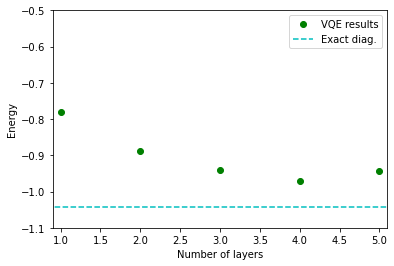

In [36]:
plt.plot(np.array([1,2,3,4,5]),Energy,'o', color = "green",label="VQE results")
plt.plot(np.array([0,1,2,3,4,5,6]),eigenvalues[0]*np.ones(7), ls = "--", color ="c", label = "Exact diag.")
plt.xlabel("Number of layers")
plt.ylabel("Energy")
plt.ylim(-1.1,-0.5)
plt.xlim(0.9,5.1)
plt.legend()

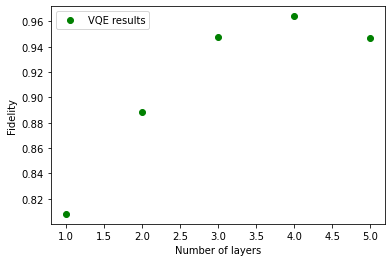

In [37]:
plt.plot(np.array([1,2,3,4,5]),Fidelity,'o', color = "green",label="VQE results")
plt.xlabel("Number of layers")
plt.ylabel("Fidelity")
plt.legend()